# Imports

In [1]:
import pandas as pd
import seaborn as sb
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier



from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import sklearn.tree as tree
import matplotlib.pyplot as plt
import numpy as np

from my_utils import split_and_train, split_and_train_conferences_together, train_evaluate_decision_tree_graph_old
from my_utils import train_evaluate_decision_tree_graph, train_evaluate_decision_tree_average, train_evaluate_decision_tree_years_back
from my_utils import plot_metrics_over_time, plot_metrics_over_time_test_train, plot_metrics_over_time_three
from my_utils import backwards_elimination, select_k_best


In [2]:
df_teams=pd.read_csv('data_merged.csv')

# Feature selection

## Agregation and manual selection

In [3]:
df_teams['performance'] = (df_teams['points'] + df_teams['rebounds'] +
                            df_teams['assists'] + df_teams['steals'] +
                            df_teams['blocks']) - (df_teams['turnovers'] +
                            0.4*df_teams['PF'])
df_teams['Postperformance'] = (df_teams['PostPoints'] + df_teams['PostRebounds'] +
                            df_teams['PostAssists'] + df_teams['PostSteals'] +
                            df_teams['PostBlocks']) - (df_teams['PostTurnovers'] +
                            0.4*df_teams['PostPF'])
                            
df_teams.drop(columns=['points', 'rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'PF', 'PostPoints', 'PostRebounds', 'PostAssists', 'PostSteals', 'PostBlocks', 'PostTurnovers', 'PostPF'], inplace=True)

In basketball, one can calculate the total points scored using the following formula:
Total Points = Free Throws Made (ftMade) + 2 * (Field Goals Made (fgMade) - Three-Pointers Made (threeMade)) + 3 * Three-Pointers Made (threeMade).
However, it's important to note that the given dataset already includes a dedicated column for total points. Consequently, the columns for Free Throws Made (ftMade), Field Goals Made (fgMade), and Three-Pointers Made (threeMade)  end up giving redundant information, and therefore, are not useful and can be deleted from the dataset.

In [4]:
points_made = 1 * df_teams['ftMade'] + 2 * (df_teams['fgMade'] - df_teams['threeMade']) + 3 * df_teams['threeMade']
points_attempted = 1 * df_teams['ftAttempted'] + 2 * (df_teams['fgAttempted'] - df_teams['threeAttempted']) + 3 * df_teams['threeAttempted']
df_teams['points_precision'] = points_attempted - points_made

post_points_made = 1 * df_teams['PostftMade'] + 2 * (df_teams['PostfgMade'] - df_teams['PostthreeMade']) + 3 * df_teams['PostthreeMade']
post_points_attempted = 1 * df_teams['PostftAttempted'] + 2 * (df_teams['PostfgAttempted'] - df_teams['PostthreeAttempted']) + 3 * df_teams['PostthreeAttempted']
df_teams['Postpoints_precision'] = post_points_attempted - post_points_made

df_teams.drop(columns=['ftMade', 'fgMade', 'threeMade', 'fgAttempted', 'ftAttempted', 'threeAttempted', 'PostftMade', 'PostfgMade', 'PostthreeMade', 'PostfgAttempted', 'PostftAttempted', 'PostthreeAttempted'], inplace=True)

The "won" and "lost" collumns is the sum of  "homeW","awayW", "homeL","awayL"


In [5]:
df_teams.drop(columns=["homeW","homeL","awayW","awayL"], inplace=True)

The rebound and postRebound are the sum of the offensive and defensive rebound. We can delete the offensive and defensive rebound columns.

In [6]:
df_teams.drop(columns=["oRebounds", "dRebounds", "PostoRebounds", "PostdRebounds"], inplace=True)

In [7]:
df_teams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   year                     142 non-null    int64  
 1   tmID                     142 non-null    object 
 2   rank                     142 non-null    float64
 3   playoff                  142 non-null    int64  
 4   confW                    142 non-null    float64
 5   confL                    142 non-null    float64
 6   min                      142 non-null    float64
 7   attend                   142 non-null    float64
 8   num_playoff_appearances  142 non-null    float64
 9   total_first_round_won    142 non-null    float64
 10  total_first_round_lost   142 non-null    float64
 11  total_semis_won          142 non-null    float64
 12  total_semis_lost         142 non-null    float64
 13  total_finals_won         142 non-null    float64
 14  total_finals_lost        1

Feature aggregationFrom the players we get the following statistics taht are repeated one for the normal season and one for the playoffs. To eliminate the redundancy we will sum the two columns and then delete the columns that are not needed.

# Train and test

## Functions

In [8]:


df_teams = df_teams[df_teams['year'] != 1]
df_teams = df_teams[df_teams['year'] != 2]

#one hot encoding sklearn to encode column tmID
encoder = OneHotEncoder()
onehotarray = encoder.fit_transform(df_teams[['tmID']]).toarray()
items = [f'tmID_{item}' for item in encoder.categories_[0]]
df_teams[items] = onehotarray
df_teams=df_teams.drop(['tmID'], axis=1)





df_teams.info()


<class 'pandas.core.frame.DataFrame'>
Index: 110 entries, 32 to 141
Data columns (total 58 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   year                     110 non-null    int64  
 1   rank                     110 non-null    float64
 2   playoff                  110 non-null    int64  
 3   confW                    110 non-null    float64
 4   confL                    110 non-null    float64
 5   min                      110 non-null    float64
 6   attend                   110 non-null    float64
 7   num_playoff_appearances  110 non-null    float64
 8   total_first_round_won    110 non-null    float64
 9   total_first_round_lost   110 non-null    float64
 10  total_semis_won          110 non-null    float64
 11  total_semis_lost         110 non-null    float64
 12  total_finals_won         110 non-null    float64
 13  total_finals_lost        110 non-null    float64
 14  mean_won                 110 n

No need to sample the data, as it is balanced.

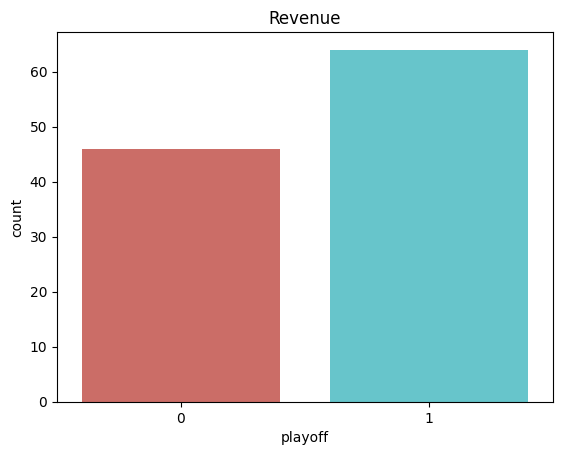

In [9]:
sb.countplot(x='playoff',data=df_teams, palette='hls')
plt.title("Revenue")
plt.show()

In [10]:
from sklearn.model_selection import ParameterGrid


def custom_grid_search(model, data, param_grid, scaling=False):
    """Performs a grid search over the given hyperparameter space and returns the best parameters and score.

    Args:
        model : the model to use for training and evaluation
        data : the data to use for training and evaluation
        param_grid : the hyperparameter space to search over
        scaling : whether or not to scale the data. Defaults to False.

    Returns:
        best_params : the best parameters found during the search
        best_score : the best score found during the search
    """

    best_params = None
    best_score = float('-inf')  # For maximizing, change to float('inf') for minimizing

    # Iterate through all combinations of hyperparameters
    for parms in ParameterGrid(param_grid):
        model.set_params(**parms)
        # Evaluate performance using the test_data_func
        score, _, _, _ = train_evaluate_decision_tree_average(model, data, scaling=scaling, years_back=9)

        # Update best_params and best_score if the current combination is better
        if score > best_score:
            print("New best score: ", score)
            print("New best params: ", parms)
            best_params = parms
            best_score = score

    return best_params, best_score

In [11]:
from sklearn.model_selection import ParameterSampler

def custom_randomized_grid_search(model, data, param_grid, scaling=False, n_iter=10):
    """Performs a randomized grid search over the given hyperparameter space and returns the best parameters and score.

    Args:
        model : the model to use for training and evaluation
        data : the data to use for training and evaluation
        param_grid : the hyperparameter space to search over
        scaling : whether or not to scale the data. Defaults to False.
        n_iter : number of random combinations to try. Defaults to 10.

    Returns:
        best_params : the best parameters found during the search
        best_score : the best score found during the search
    """

    best_params = None
    best_score = float('-inf')  # For maximizing, change to float('inf') for minimizing

    # Create a random parameter sampler
    param_samples = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=42))

    for parms in param_samples:
        model.set_params(**parms)

        score, _, _, _ = train_evaluate_decision_tree_average(model, data, scaling=scaling, years_back=9)

        # Update best_params and best_score if the current combination is better
        if score > best_score:
            print("New best score:", score)
            print("New best params:", parms)
            best_params = parms
            best_score = score

    return best_params, best_score

## Models

### Desicion Tree

#### Hyperparameter tuning

In [12]:
from  sklearn.model_selection import GridSearchCV

# model = DecisionTreeClassifier()
# param_grid = {'max_depth': [2, 3, 4, 5, 6, 7, 8, None],
#                 'min_samples_split': [2, 3, 4, 6],
#                 'min_samples_leaf': [1, 2, 3, 4, 5 ],
#                 'criterion': ['gini', 'entropy', 'log_loss'],
#                 'max_features': [None, 'sqrt', 'log2'],
#                 'splitter': ['best', 'random'],
                
#               }
# grid = GridSearchCV(model, param_grid, cv=None)
# X = df_teams.drop(columns=['playoff'])
# y = df_teams['playoff']
# grid.fit(X, y)
# print(grid.best_estimator_)
# DecisionTreeClassifier(criterion='entropy', min_samples_leaf=4, min_samples_split=4, splitter='random')


In [13]:
# model = DecisionTreeClassifier()

# features = backwards_elimination(df_teams,model)
# print(features)
# features_kbest = select_k_best(df_teams, model)
# print(features_kbest)

# years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams, title="Normal Training")
# years_tested, bidirectional_accuracy_scores, bidirectional_precision_scores, bidirectional_recall_scores, bidirectional_f1_scores = train_evaluate_decision_tree_graph(model, df_teams[features], title="Bidirectional Selection")
# years_tested, kbest_accuracy_scores, kbest_precision_scores, kbest_recall_scores, kbest_f1_scores = train_evaluate_decision_tree_graph(model, df_teams[features_kbest], title="KBest Selection")
# train_evaluate_decision_tree_years_back(model, df_teams)
# plot_metrics_over_time_three(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores, bidirectional_accuracy_scores, bidirectional_precision_scores, bidirectional_recall_scores, bidirectional_f1_scores, kbest_accuracy_scores, kbest_precision_scores, kbest_recall_scores, kbest_f1_scores)

### Random Forest

#### Hyperparameter tuning

In [14]:
from sklearn.model_selection import RandomizedSearchCV

# model = RandomForestClassifier()

# param_grid = {'max_depth': [4, 6, 10, 100, 200, None],
#                 'min_samples_split': [2, 3, 4, 6],
#                 'min_samples_leaf': [1, 2, 3, 4 ],
#                 'max_features': [None, 'sqrt', 'log2'],
#                 'max_leaf_nodes': [None,  6, 7, 10, 20],
#                 'min_impurity_decrease': [0, 0.1, 0.2],
#                 'bootstrap': [False, True],
#                 'class_weight': ['balanced', 'balanced_subsample', None],
#                 'n_jobs': [None, 2, 3],                
#               }
# grid = RandomizedSearchCV(model, param_grid, cv=None)
# X = df_teams.drop(columns=['playoff'])
# y = df_teams['playoff']
# grid.fit(X, y)
# print(grid.best_estimator_, grid.best_score_)


In [15]:
# RandomForestClassifier(bootstrap=False, max_depth=200, max_features='log2', min_impurity_decrease=0.2, n_jobs=2) 0.8975384615384616
# RandomForestClassifier(bootstrap=False, max_depth=200, max_features='log2',
                    #    max_leaf_nodes=6, min_impurity_decrease=0.2,
                    #    min_samples_split=6, n_jobs=3)


In [17]:
# model = RandomForestClassifier()

# features = backwards_elimination(df_teams, model)
# print(features)
# features_kbest = select_k_best(df_teams, model, years_back=5)
# print(features_kbest)
# years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams, title="Normal Training", years_back=5)
# years_tested, bidirectional_accuracy_scores, bidirectional_precision_scores, bidirectional_recall_scores, bidirectional_f1_scores = train_evaluate_decision_tree_graph(model, df_teams[features], title="Bidirectional Selection", years_back=5)
# years_tested, kbest_accuracy_scores, kbest_precision_scores, kbest_recall_scores, kbest_f1_scores = train_evaluate_decision_tree_graph(model, df_teams[features_kbest], title="KBest Selection", years_back=5)
# train_evaluate_decision_tree_years_back(model, df_teams)
# plot_metrics_over_time_three(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores, bidirectional_accuracy_scores, bidirectional_precision_scores, bidirectional_recall_scores, bidirectional_f1_scores, kbest_accuracy_scores, kbest_precision_scores, kbest_recall_scores, kbest_f1_scores)

### KNN

#### Hyperparameter tuning

In [18]:

# model = KNeighborsClassifier()

# param_grid = {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10],
#               'weights': ['uniform', 'distance'],
#               'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
#               'leaf_size': [5, 10, 20, 30, 40, 50],
#               'p': [1, 2, 3],
#               'metric': ['minkowski', 'euclidean', 'manhattan']          
#               }
# best_param, best_score = custom_grid_search(model, df_teams, param_grid, scaling=True)
# print(best_param, best_score)

# #{'algorithm': 'auto', 'leaf_size': 5, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 2, 'weights': 'distance'} 0.7747252747252746



['year', 'rank', 'confW', 'confL', 'attend', 'num_playoff_appearances', 'total_first_round_won', 'total_first_round_lost', 'total_semis_won', 'total_semis_lost', 'total_finals_won', 'total_finals_lost', 'confID_EA', 'GP', 'GS', 'minutes', 'PostGP', 'won', 'lost', 'award_count_y', 'tmID_DET', 'tmID_IND', 'tmID_NYL', 'tmID_SEA', 'tmID_WAS', 'playoff', 'confID_WE', 'tmID_ATL', 'tmID_CHA', 'tmID_CHI', 'tmID_CLE', 'tmID_CON', 'tmID_HOU', 'tmID_LAS', 'tmID_MIA', 'tmID_MIN', 'tmID_ORL', 'tmID_PHO', 'tmID_POR', 'tmID_SAC', 'tmID_SAS', 'tmID_UTA']
hightest_accuracy_score:  0.7985347985347985


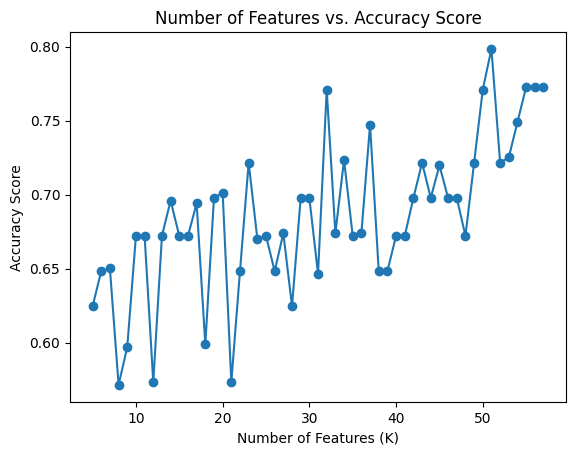

Index(['rank', 'confL', 'num_playoff_appearances', 'total_first_round_won',
       'total_first_round_lost', 'total_semis_won', 'total_semis_lost',
       'total_finals_won', 'mean_lost', 'confID_EA', 'confID_WE', 'GP', 'GS',
       'minutes', 'dq', 'PostGP', 'PostGS', 'PostMinutes', 'PostDQ', 'height',
       'weight', 'award_count_x', 'won', 'lost', 'post_wins', 'post_losses',
       'award_count_y', 'performance', 'Postperformance', 'points_precision',
       'Postpoints_precision', 'tmID_ATL', 'tmID_CHA', 'tmID_CHI', 'tmID_CLE',
       'tmID_CON', 'tmID_DET', 'tmID_HOU', 'tmID_IND', 'tmID_LAS', 'tmID_MIA',
       'tmID_MIN', 'tmID_NYL', 'tmID_ORL', 'tmID_PHO', 'tmID_POR', 'tmID_SAC',
       'tmID_SAS', 'tmID_SEA', 'tmID_UTA', 'tmID_WAS', 'playoff', 'year'],
      dtype='object')


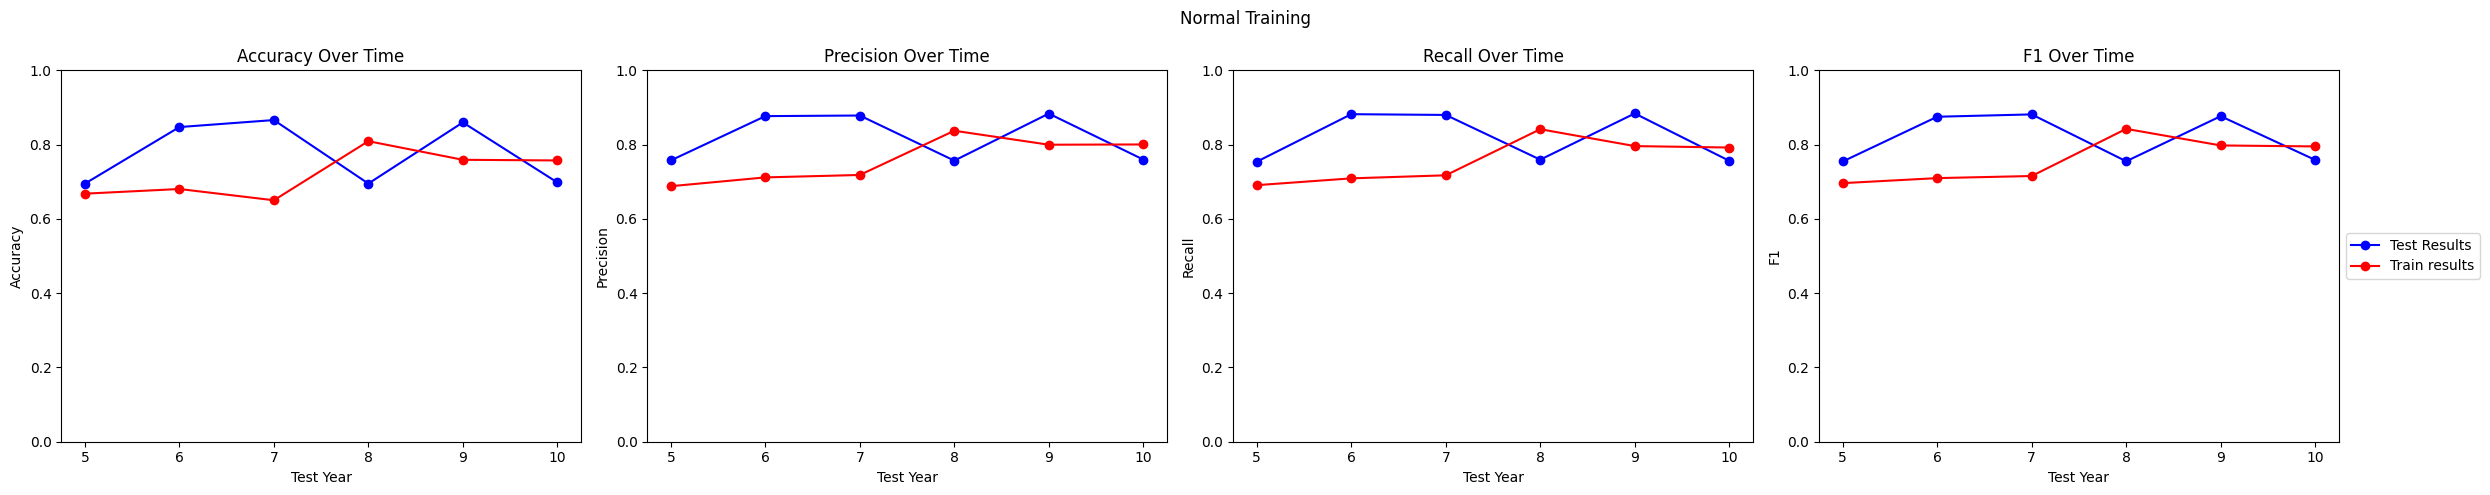

Normal Training
Accuracy: 0.77, Precision: 0.81, Recall: 0.81, F1: 0.81
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


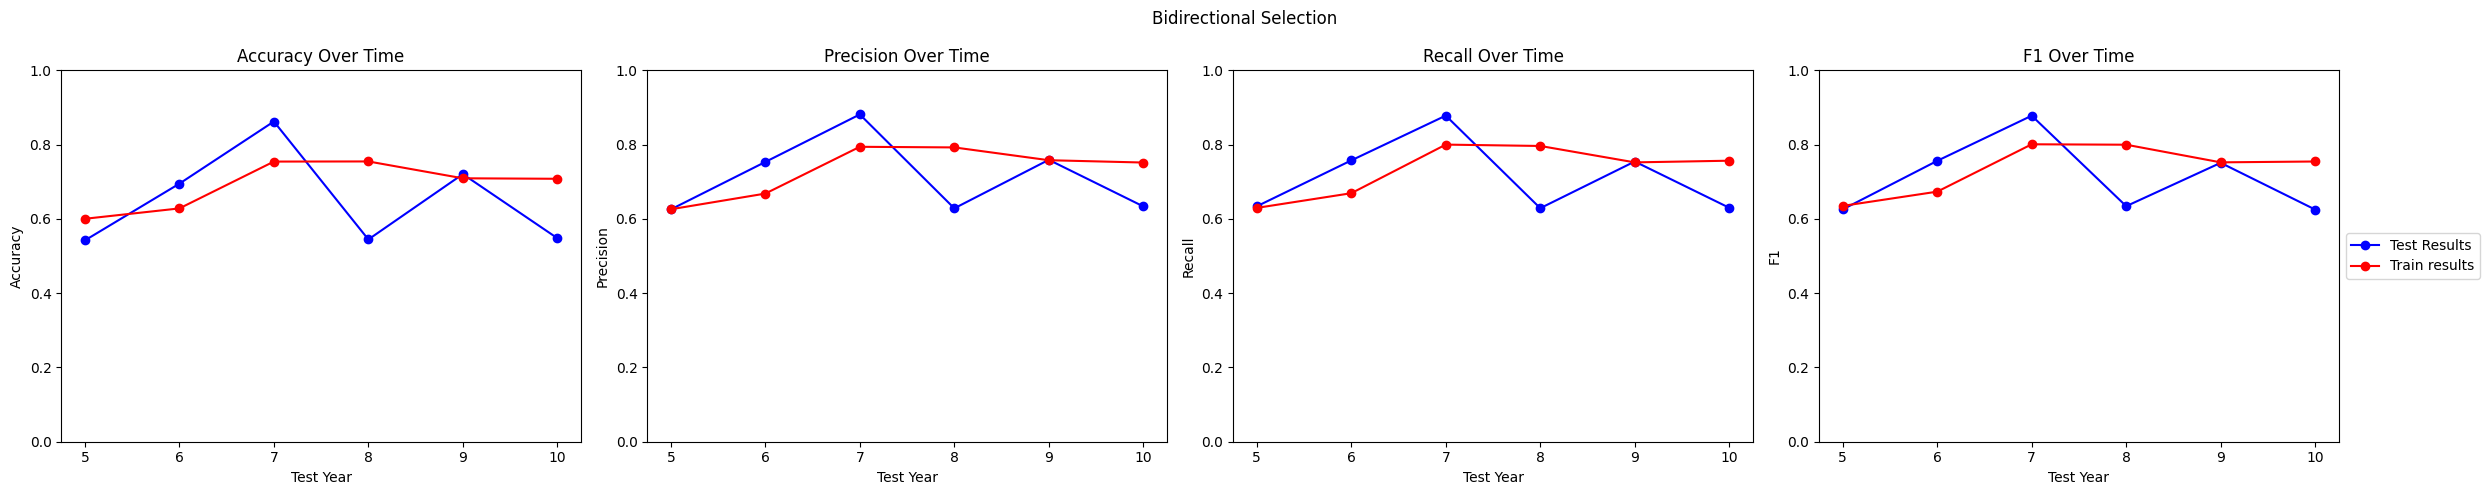

Bidirectional Selection
Accuracy: 0.65, Precision: 0.71, Recall: 0.71, F1: 0.71
10 year
Accuracy: 0.5384615384615384, Precision: 0.625, Recall: 0.625, F1: 0.625


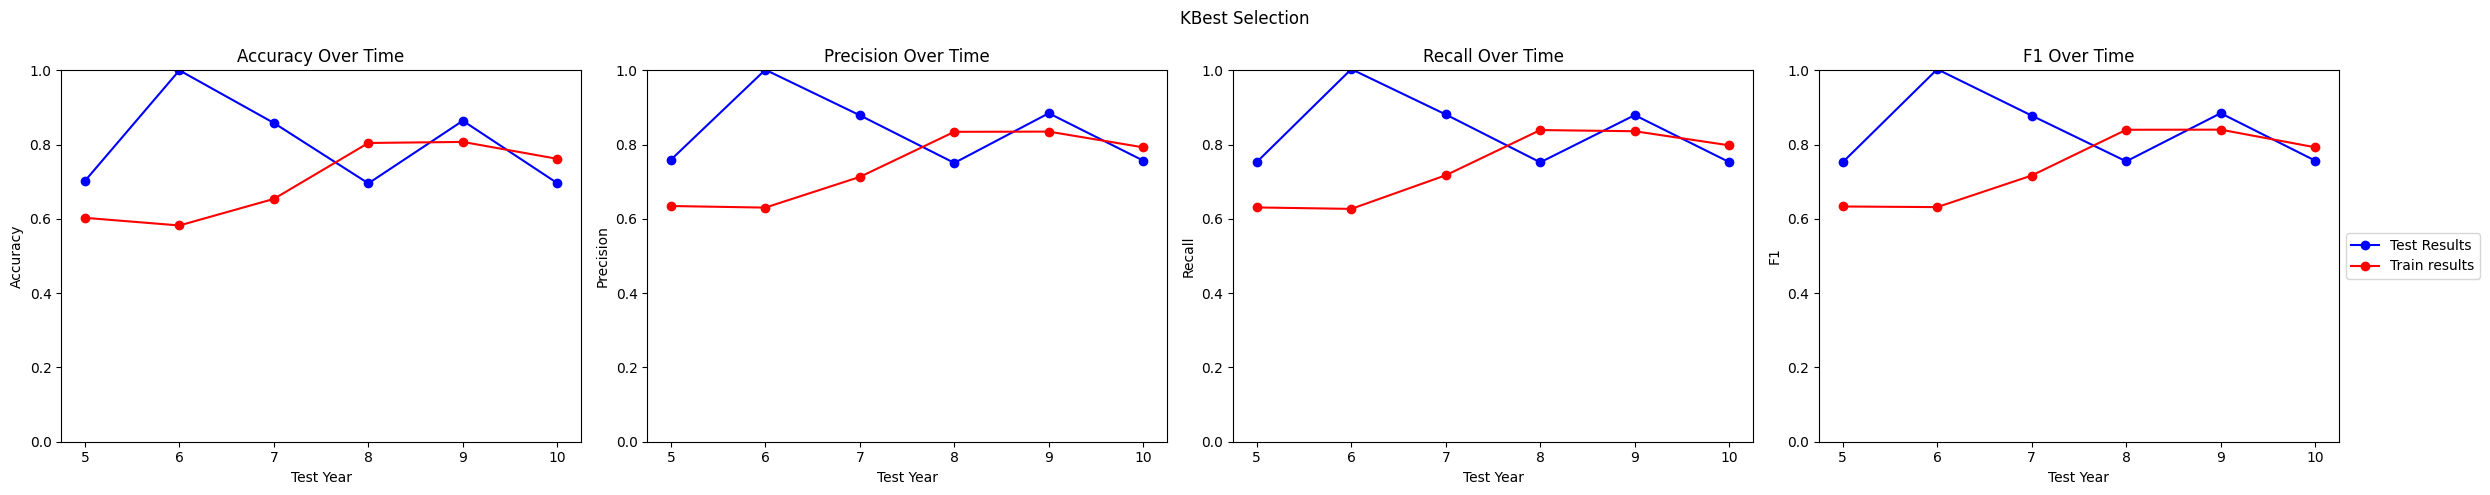

KBest Selection
Accuracy: 0.80, Precision: 0.83, Recall: 0.83, F1: 0.83
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


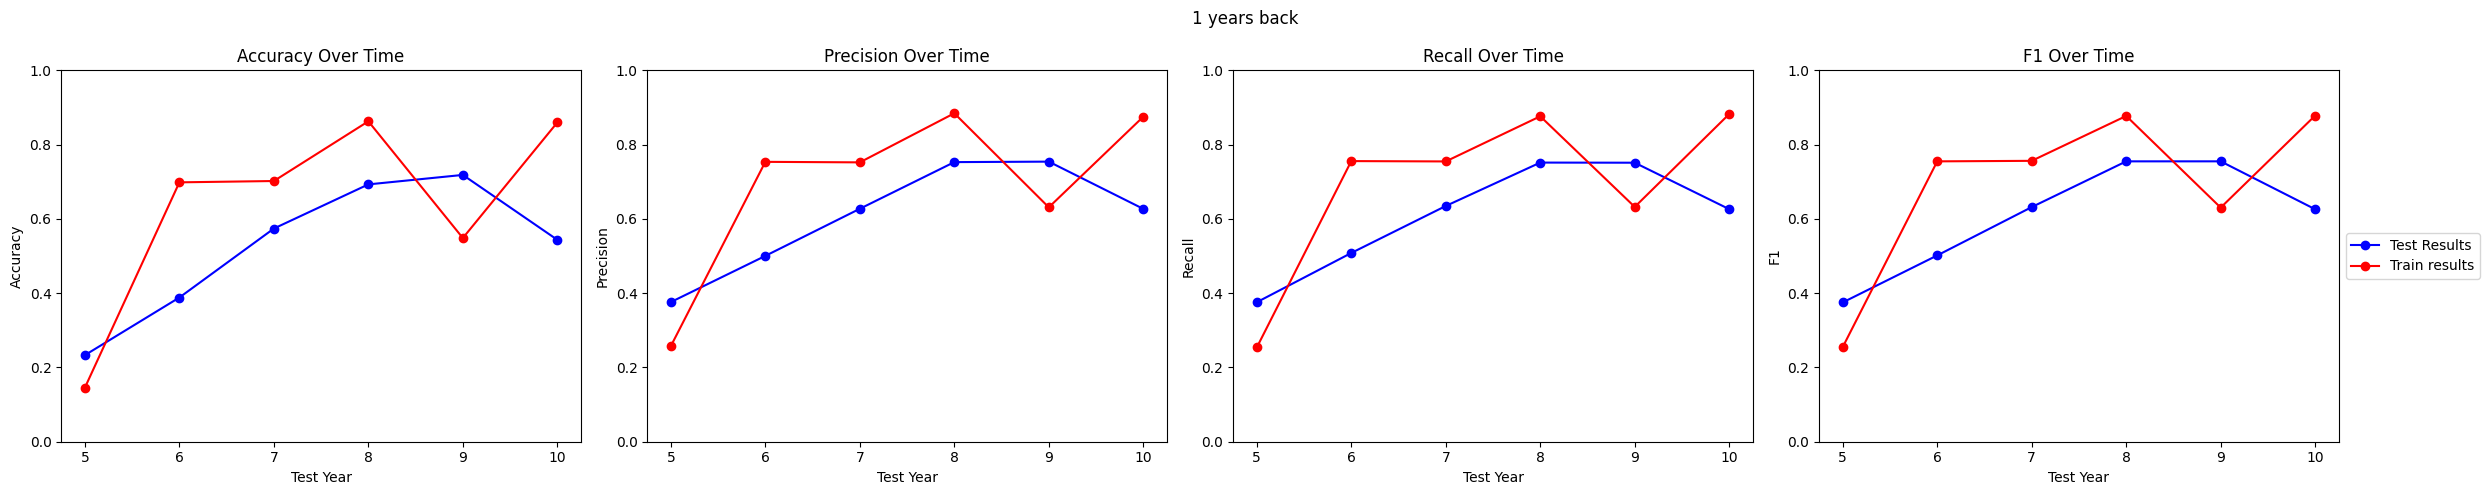

1 years back
Accuracy: 0.52, Precision: 0.60, Recall: 0.60, F1: 0.60
10 year
Accuracy: 0.5384615384615384, Precision: 0.625, Recall: 0.625, F1: 0.625


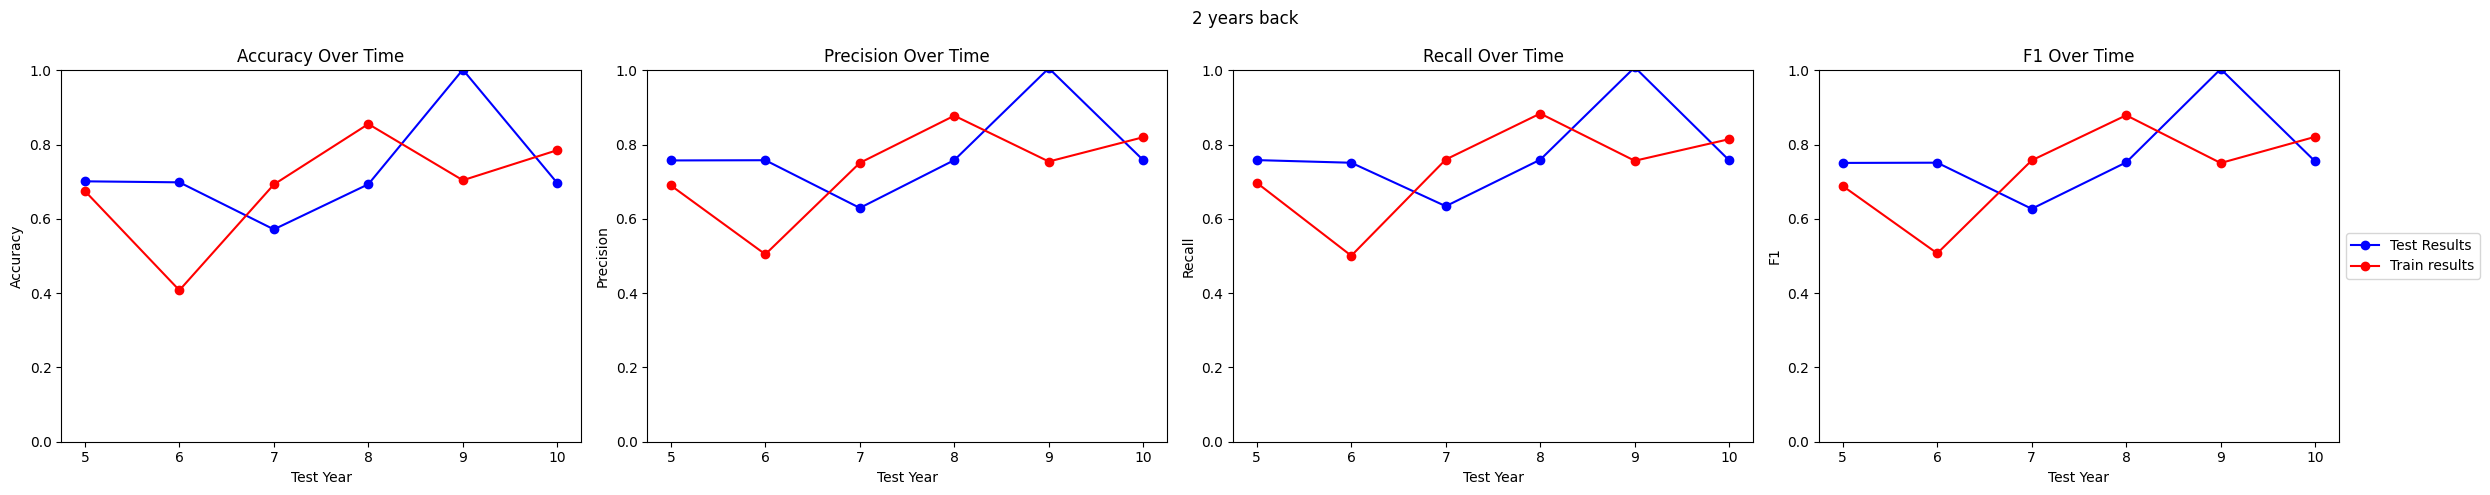

2 years back
Accuracy: 0.72, Precision: 0.77, Recall: 0.77, F1: 0.77
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


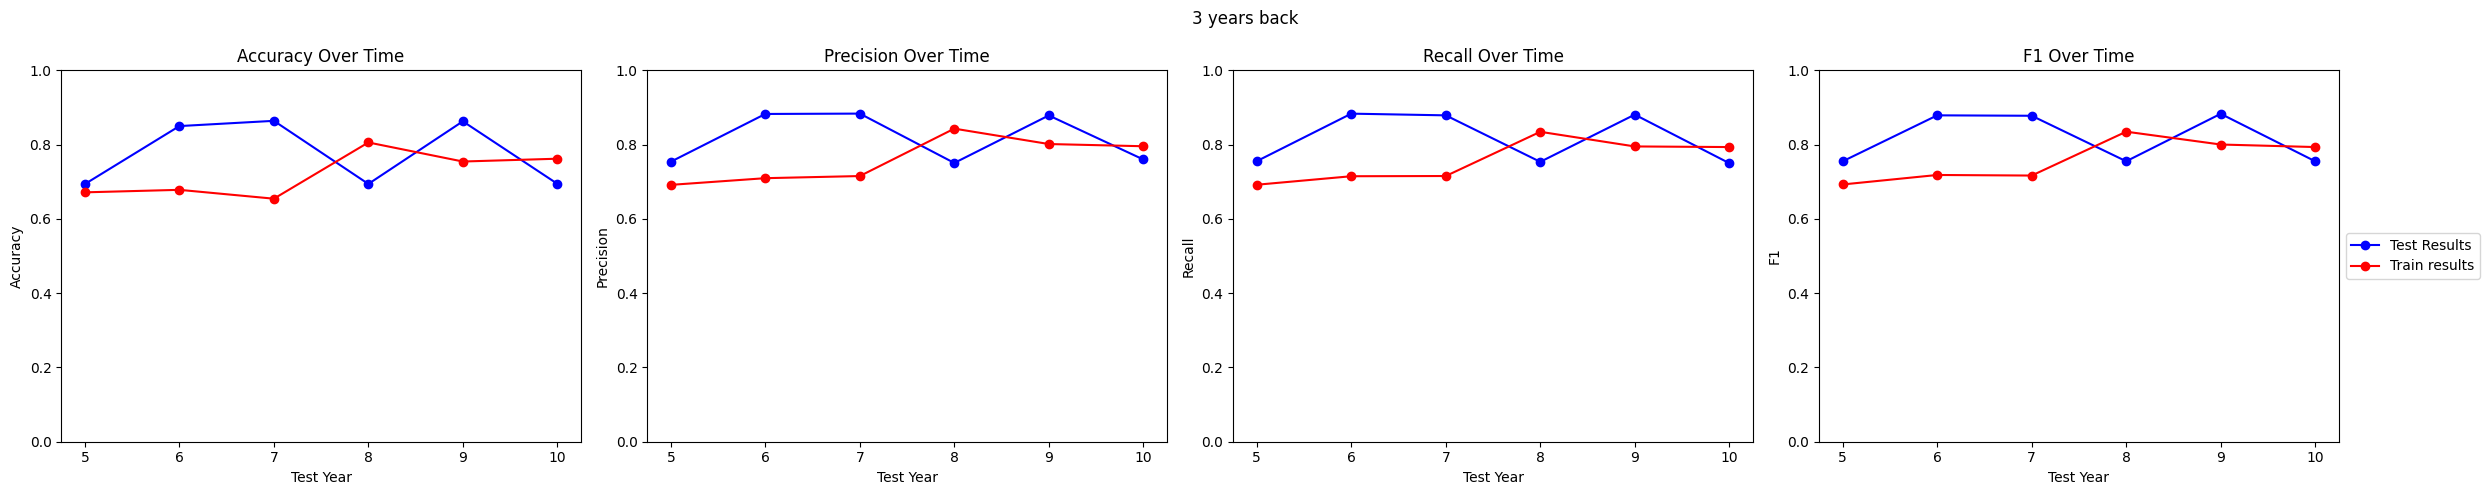

3 years back
Accuracy: 0.77, Precision: 0.81, Recall: 0.81, F1: 0.81
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


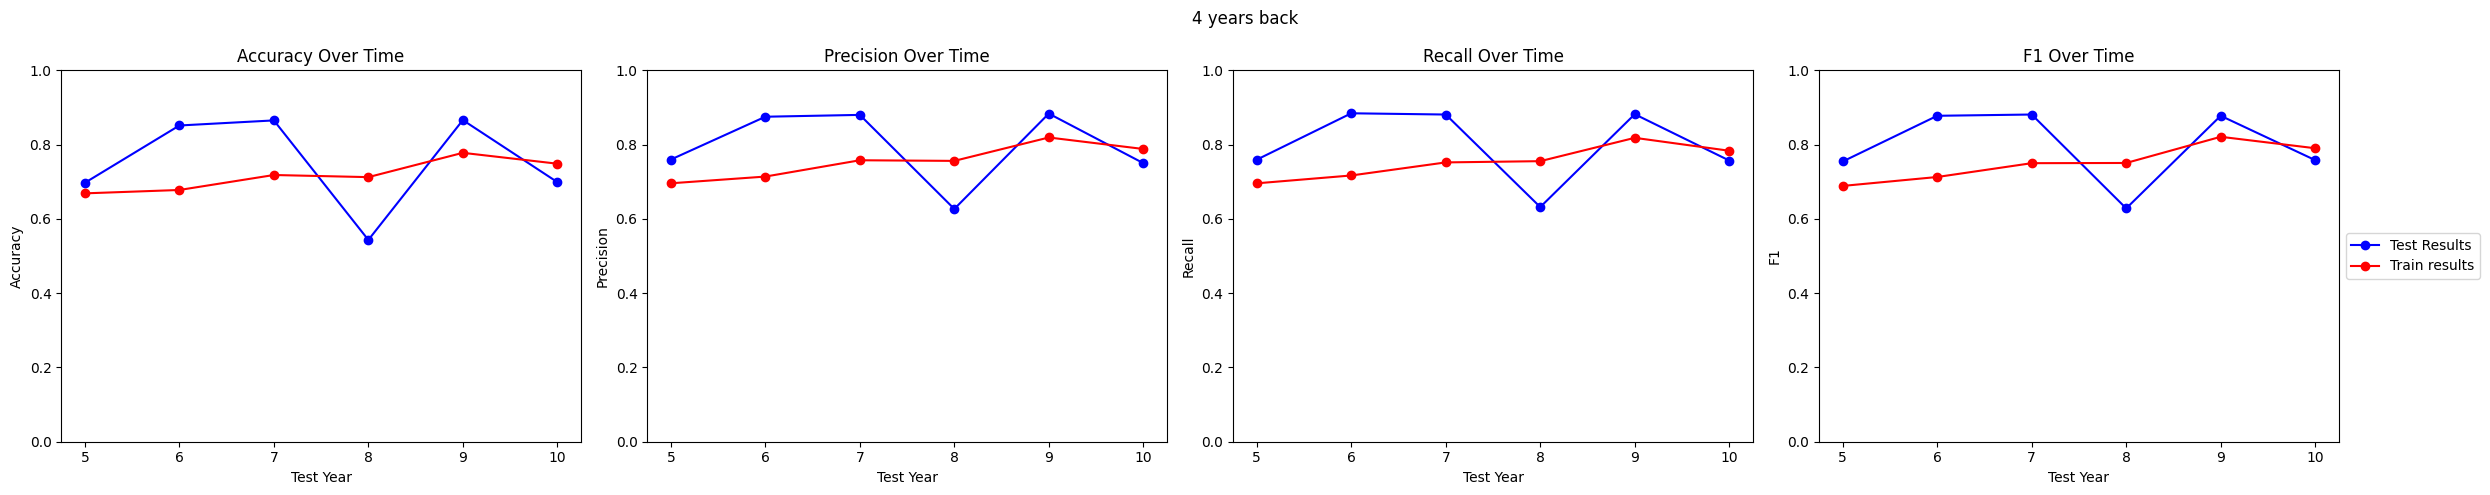

4 years back
Accuracy: 0.75, Precision: 0.79, Recall: 0.79, F1: 0.79
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


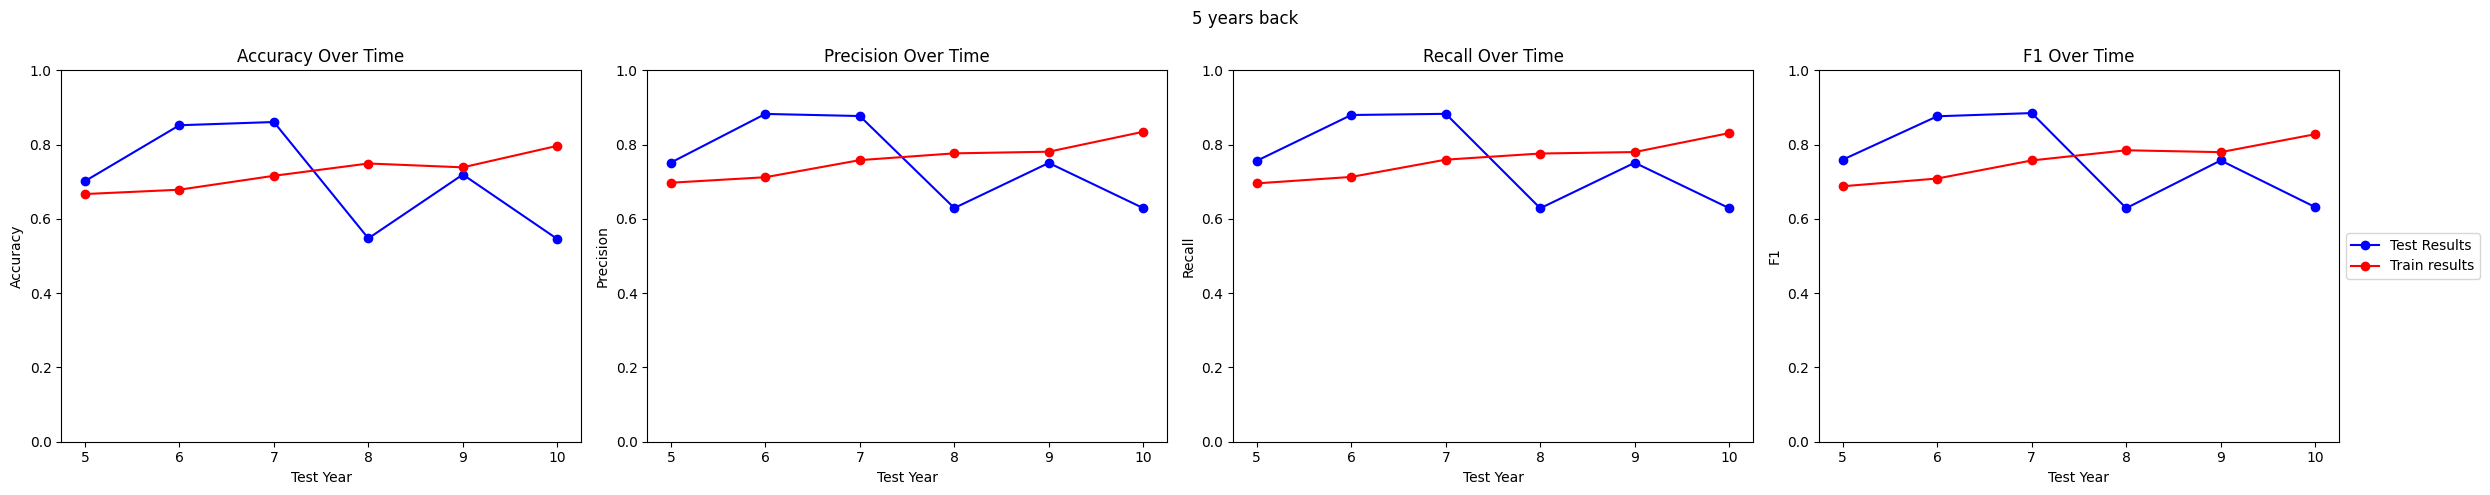

5 years back
Accuracy: 0.70, Precision: 0.75, Recall: 0.75, F1: 0.75
10 year
Accuracy: 0.5384615384615384, Precision: 0.625, Recall: 0.625, F1: 0.625


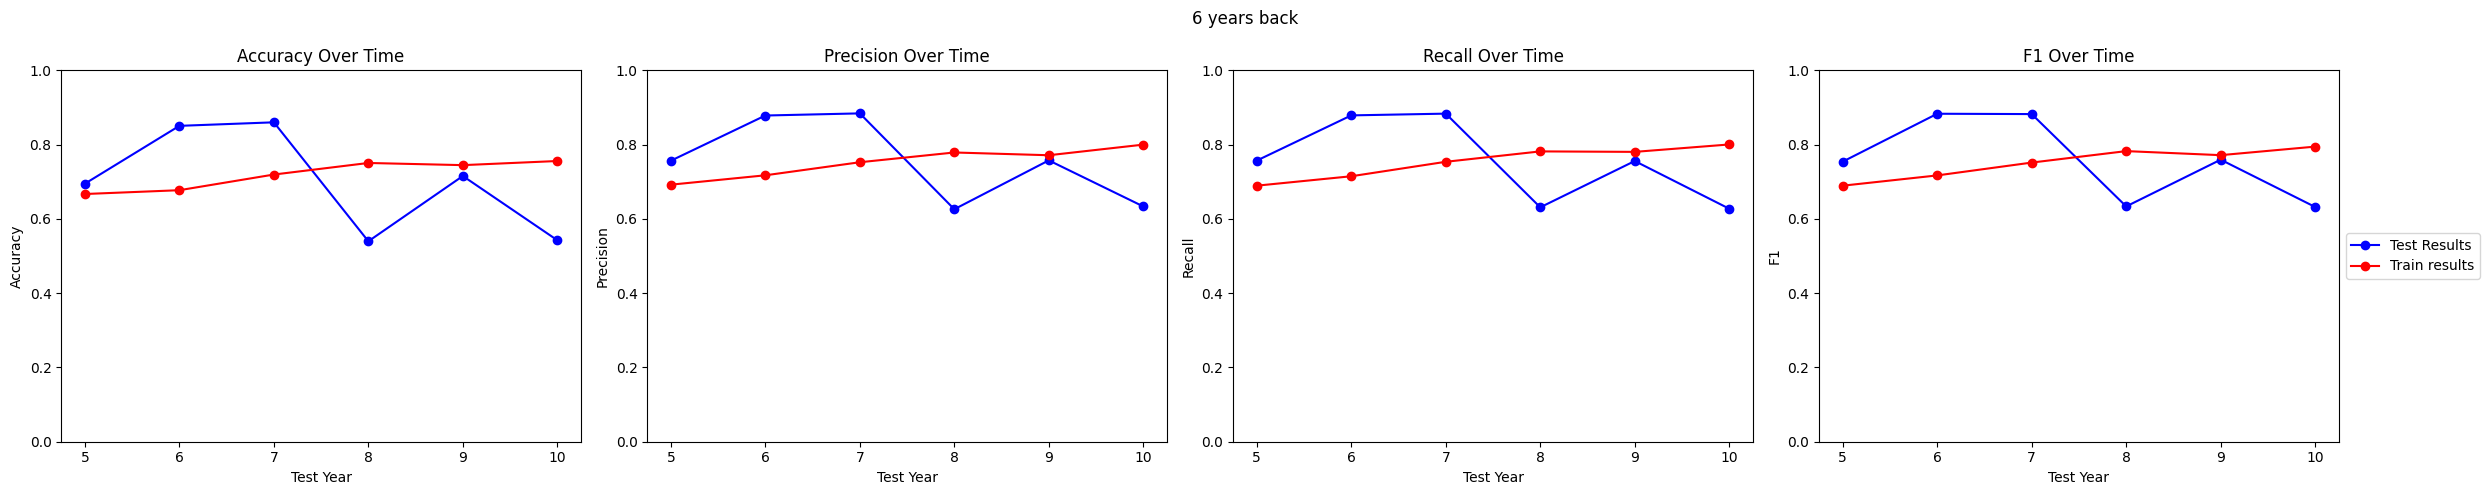

6 years back
Accuracy: 0.70, Precision: 0.75, Recall: 0.75, F1: 0.75
10 year
Accuracy: 0.5384615384615384, Precision: 0.625, Recall: 0.625, F1: 0.625


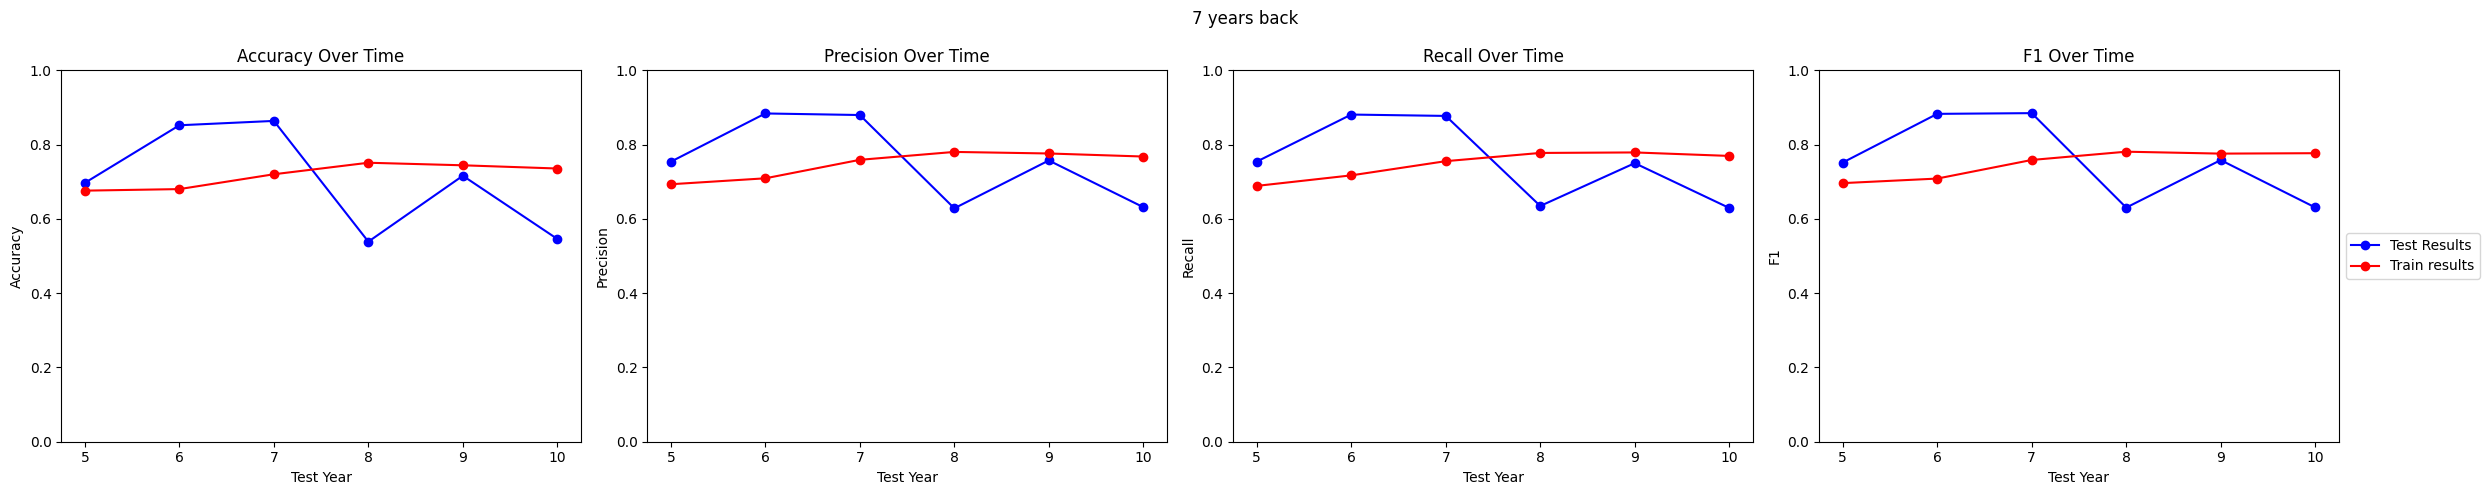

7 years back
Accuracy: 0.70, Precision: 0.75, Recall: 0.75, F1: 0.75
10 year
Accuracy: 0.5384615384615384, Precision: 0.625, Recall: 0.625, F1: 0.625


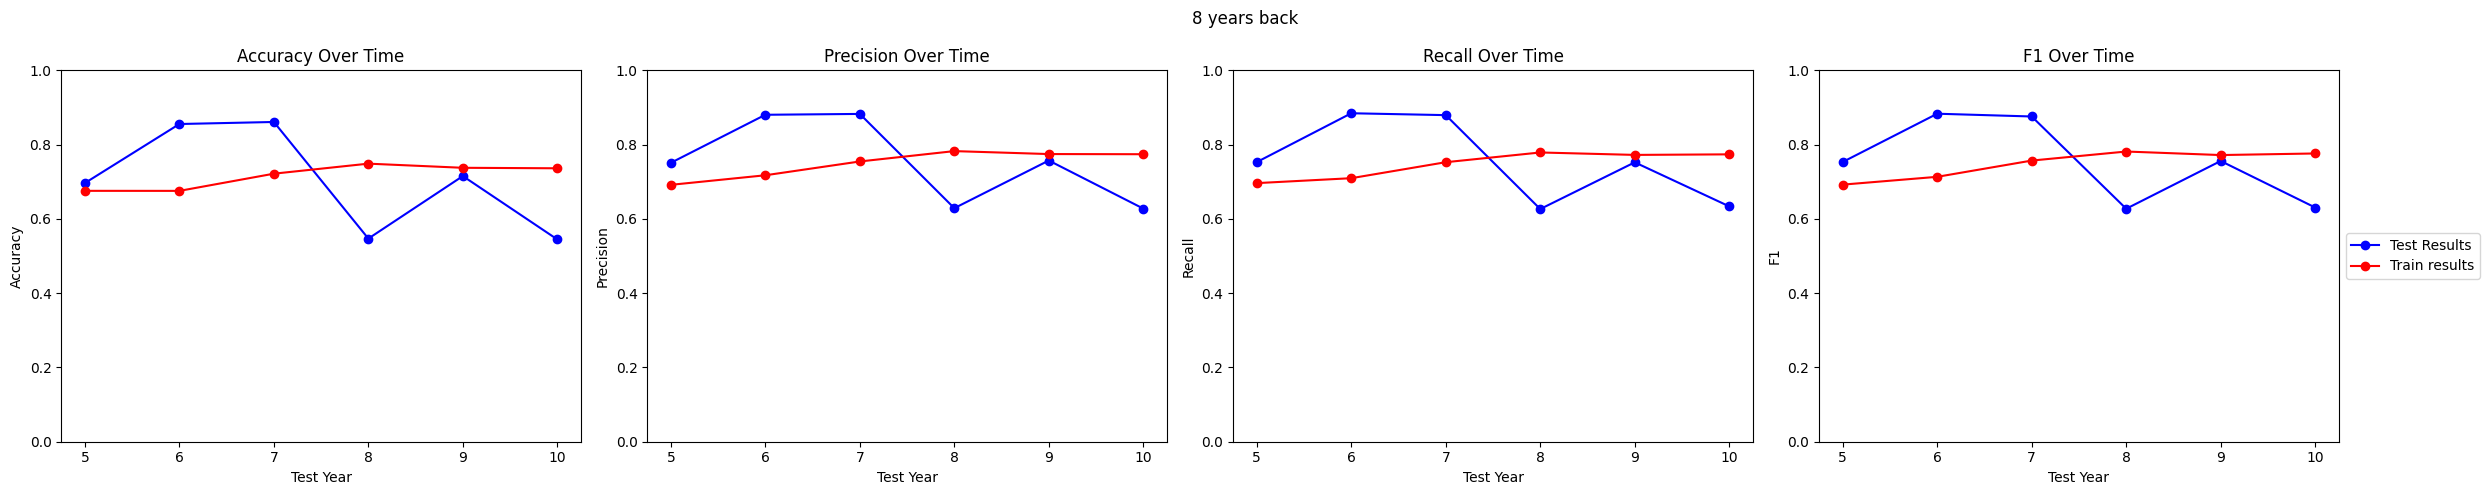

8 years back
Accuracy: 0.70, Precision: 0.75, Recall: 0.75, F1: 0.75
10 year
Accuracy: 0.5384615384615384, Precision: 0.625, Recall: 0.625, F1: 0.625


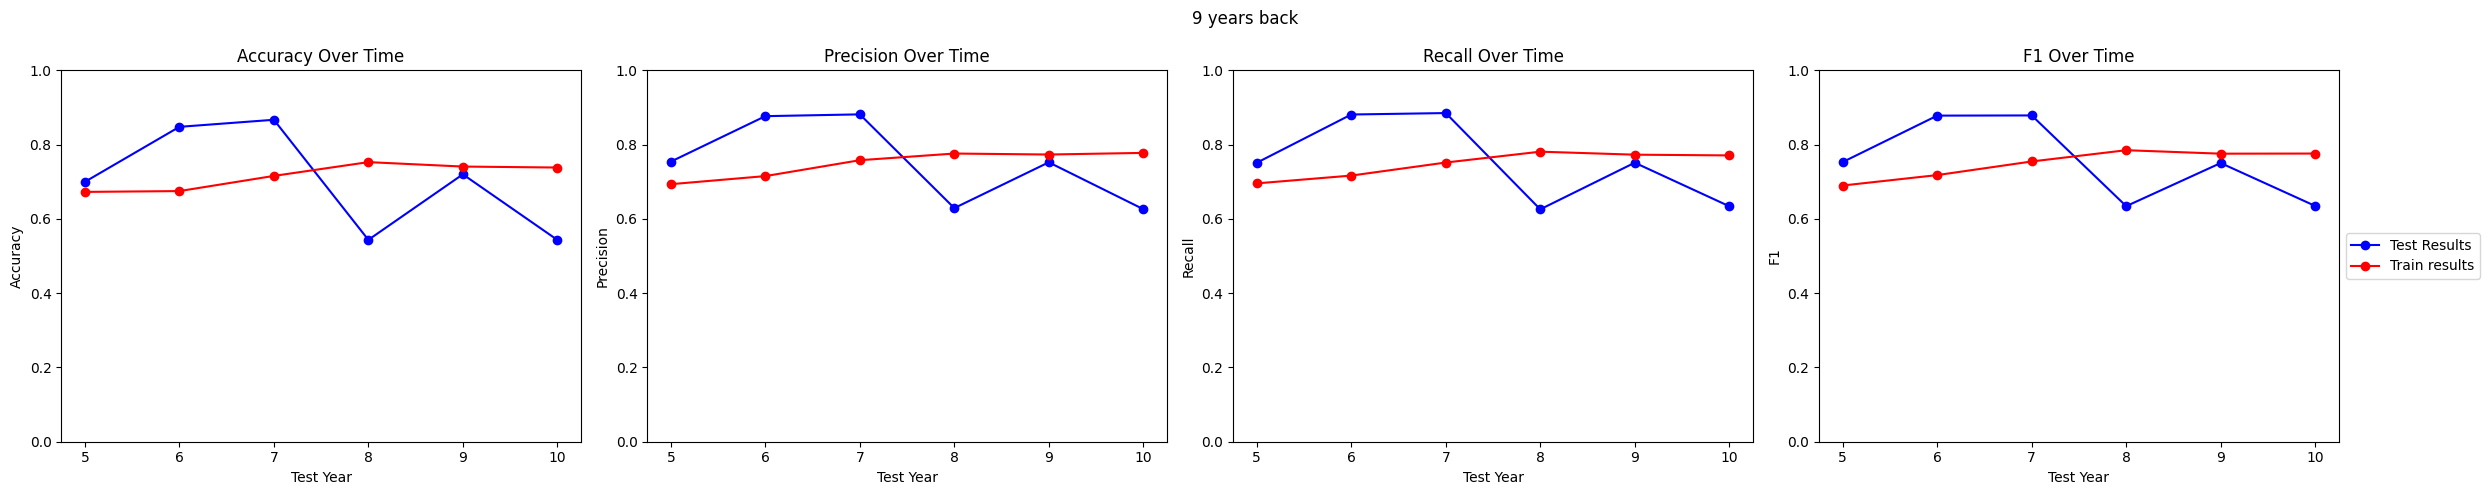

9 years back
Accuracy: 0.70, Precision: 0.75, Recall: 0.75, F1: 0.75
10 year
Accuracy: 0.5384615384615384, Precision: 0.625, Recall: 0.625, F1: 0.625


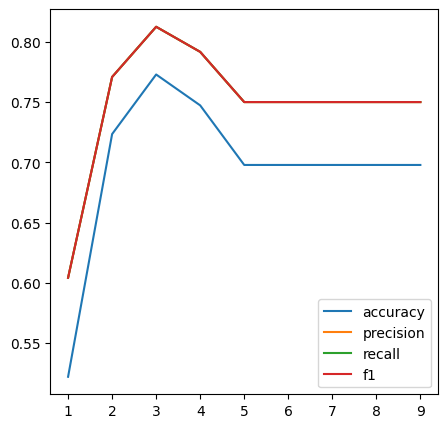

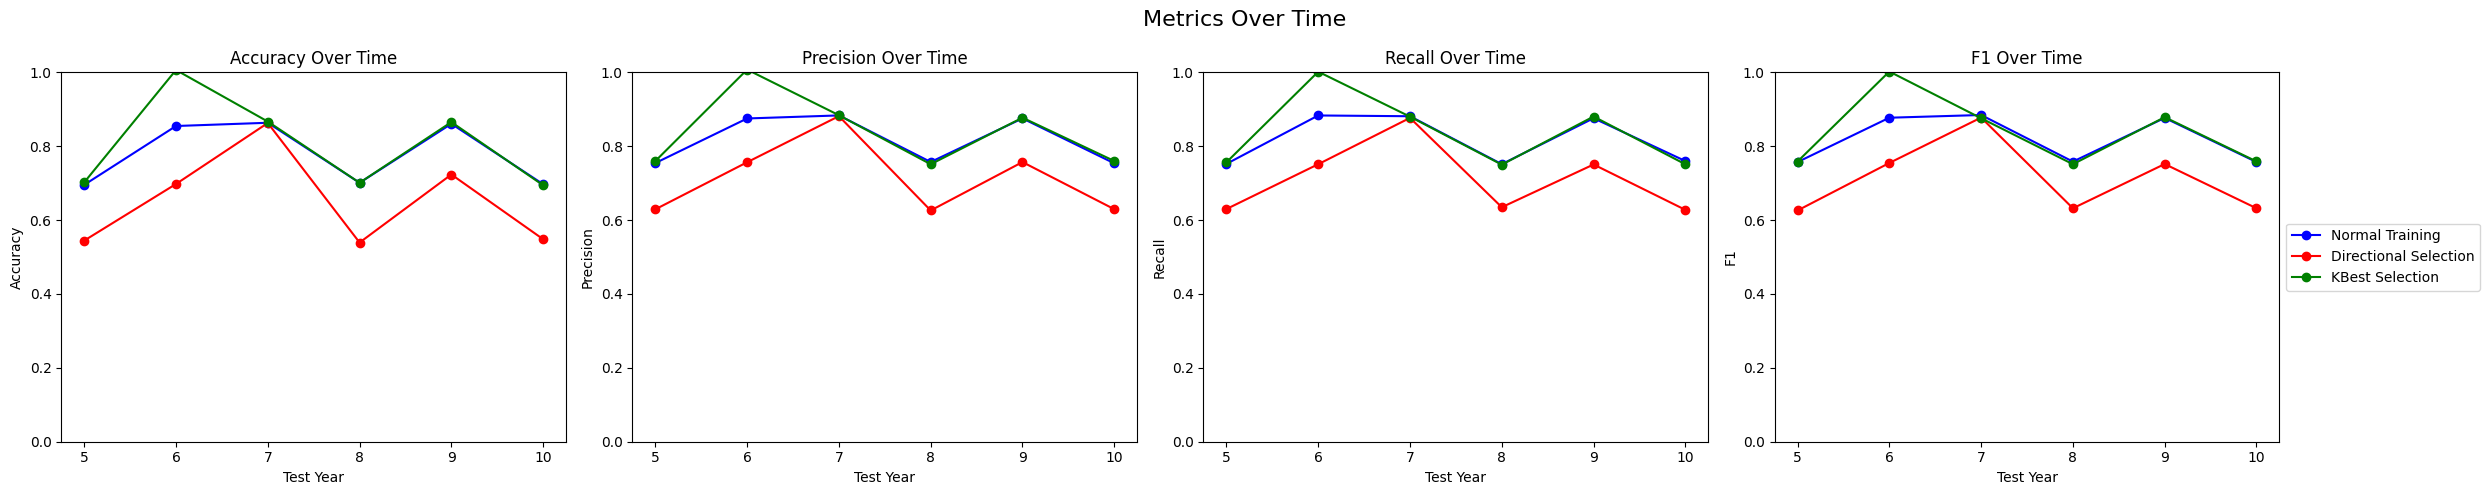

Normal Training
Accuracy: 0.77, Precision: 0.81, Recall: 0.81, F1: 0.81
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75
Directional Selection
Accuracy: 0.65, Precision: 0.71, Recall: 0.71, F1: 0.71
10 year
Accuracy: 0.5384615384615384, Precision: 0.625, Recall: 0.625, F1: 0.625
KBest Selection
Accuracy: 0.80, Precision: 0.83, Recall: 0.83, F1: 0.83
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


In [52]:
model =KNeighborsClassifier(algorithm='auto', leaf_size=5, metric='minkowski', n_neighbors=10, p=2)

features = backwards_elimination(df_teams,model, scaling=True)
print(features)
features_kbest = select_k_best(df_teams, model, scaling=True)
print(features_kbest)
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams, scaling=True, title="Normal Training")
years_tested, bidirectional_accuracy_scores, bidirectional_precision_scores, bidirectional_recall_scores, bidirectional_f1_scores = train_evaluate_decision_tree_graph(model, df_teams[features], scaling=True, title="Bidirectional Selection")
years_tested, kbest_accuracy_scores, kbest_precision_scores, kbest_recall_scores, kbest_f1_scores = train_evaluate_decision_tree_graph(model, df_teams[features_kbest], scaling=True, title="KBest Selection")
train_evaluate_decision_tree_years_back(model, df_teams, scaling=True)
plot_metrics_over_time_three(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores, bidirectional_accuracy_scores, bidirectional_precision_scores, bidirectional_recall_scores, bidirectional_f1_scores, kbest_accuracy_scores, kbest_precision_scores, kbest_recall_scores, kbest_f1_scores)

### XGBoost

#### Hyperparameter tuning

In [20]:

# model = XGBClassifier()

# param_grid = {'min_child_weight': [1, 5, 10],
#               'gamma': [0.5, 1, 1.5, 2, 5],
#               'subsample': [0.6, 0.8, 1.0],
#               'colsample_bytree': [0.6, 0.8, 1.0],
#               'max_depth': [3, 4, 5],
#               'n_estimators': [100, 200, 300],
#               'learning_rate': [0.01, 0.1, 0.2],     
#               }
# grid = RandomizedSearchCV(model, param_grid, cv=None)

# X = df_teams.drop(columns=['playoff'])
# y = df_teams['playoff']
# grid.fit(X, y)
# print(grid.best_estimator_, grid.best_score_)
# #XGBClassifier(colsample_bytree=1.0, gamma=5, learning_rate=0.01,max_depth=3, min_child_weight=10,  n_estimators=100) 0.8898461538461537


In [21]:
# features = backwards_elimination(df_teams, XGBClassifier())
# print(features)
# features_kbest = select_k_best(df_teams, XGBClassifier())
# print(features_kbest)
# model = XGBClassifier()
# years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams, title="Normal Training")
# years_tested, bidirectional_accuracy_scores, bidirectional_precision_scores, bidirectional_recall_scores, bidirectional_f1_scores = train_evaluate_decision_tree_graph(model, df_teams[features], title="Bidirectional Selection")
# years_tested, kbest_accuracy_scores, kbest_precision_scores, kbest_recall_scores, kbest_f1_scores = train_evaluate_decision_tree_graph(model, df_teams[features_kbest], title="KBest Selection")
# train_evaluate_decision_tree_years_back(model, df_teams)
# plot_metrics_over_time_three(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores, bidirectional_accuracy_scores, bidirectional_precision_scores, bidirectional_recall_scores, bidirectional_f1_scores, kbest_accuracy_scores, kbest_precision_scores, kbest_recall_scores, kbest_f1_scores)


### Naive bayes

#### Hyperparameter tuning

In [22]:

# model = GaussianNB()

# param_grid = {'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05],
#               'priors': [None, [0.5, 0.5], [0.6, 0.4], [0.4, 0.6], [0.7, 0.3], [0.3, 0.7], [0.8, 0.2], [0.2, 0.8], [0.9, 0.1], [0.1, 0.9]]
#                   }

              
# best_param, best_score = custom_grid_search(model, df_teams, param_grid)
# print(best_param, best_score)


# #{'priors': None, 'var_smoothing': 1e-09} 0.8223443223443224


['year', 'rank', 'confW', 'confL', 'min', 'attend', 'total_first_round_won', 'total_first_round_lost', 'total_semis_lost', 'total_finals_won', 'mean_lost', 'PostMinutes', 'weight', 'won', 'lost', 'post_wins', 'post_losses', 'performance', 'playoff', 'confID_EA', 'confID_WE', 'tmID_ATL', 'tmID_CHA', 'tmID_CHI', 'tmID_CLE', 'tmID_CON', 'tmID_DET', 'tmID_HOU', 'tmID_IND', 'tmID_LAS', 'tmID_MIA', 'tmID_MIN', 'tmID_NYL', 'tmID_ORL', 'tmID_PHO', 'tmID_POR', 'tmID_SAC', 'tmID_SAS', 'tmID_SEA', 'tmID_UTA', 'tmID_WAS']
hightest_accuracy_score:  0.8223443223443224


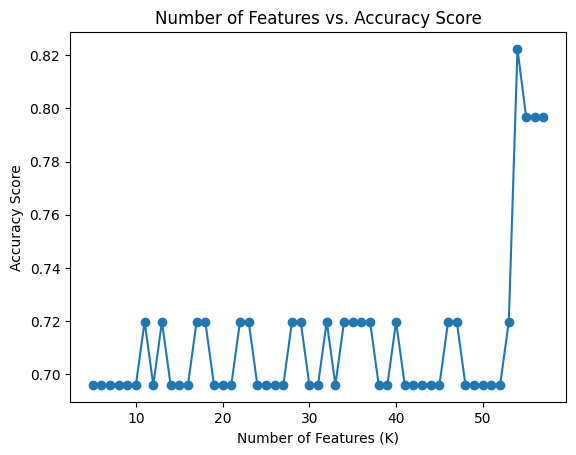

Index(['confW', 'confL', 'attend', 'num_playoff_appearances',
       'total_first_round_won', 'total_first_round_lost', 'total_semis_won',
       'total_semis_lost', 'total_finals_won', 'total_finals_lost', 'mean_won',
       'mean_lost', 'confID_EA', 'confID_WE', 'GP', 'GS', 'minutes', 'dq',
       'PostGP', 'PostGS', 'PostMinutes', 'PostDQ', 'height', 'weight',
       'award_count_x', 'won', 'lost', 'post_wins', 'post_losses',
       'award_count_y', 'performance', 'Postperformance', 'points_precision',
       'Postpoints_precision', 'tmID_ATL', 'tmID_CHA', 'tmID_CHI', 'tmID_CLE',
       'tmID_CON', 'tmID_DET', 'tmID_HOU', 'tmID_IND', 'tmID_LAS', 'tmID_MIA',
       'tmID_MIN', 'tmID_NYL', 'tmID_ORL', 'tmID_PHO', 'tmID_POR', 'tmID_SAC',
       'tmID_SAS', 'tmID_SEA', 'tmID_UTA', 'tmID_WAS', 'playoff', 'year'],
      dtype='object')


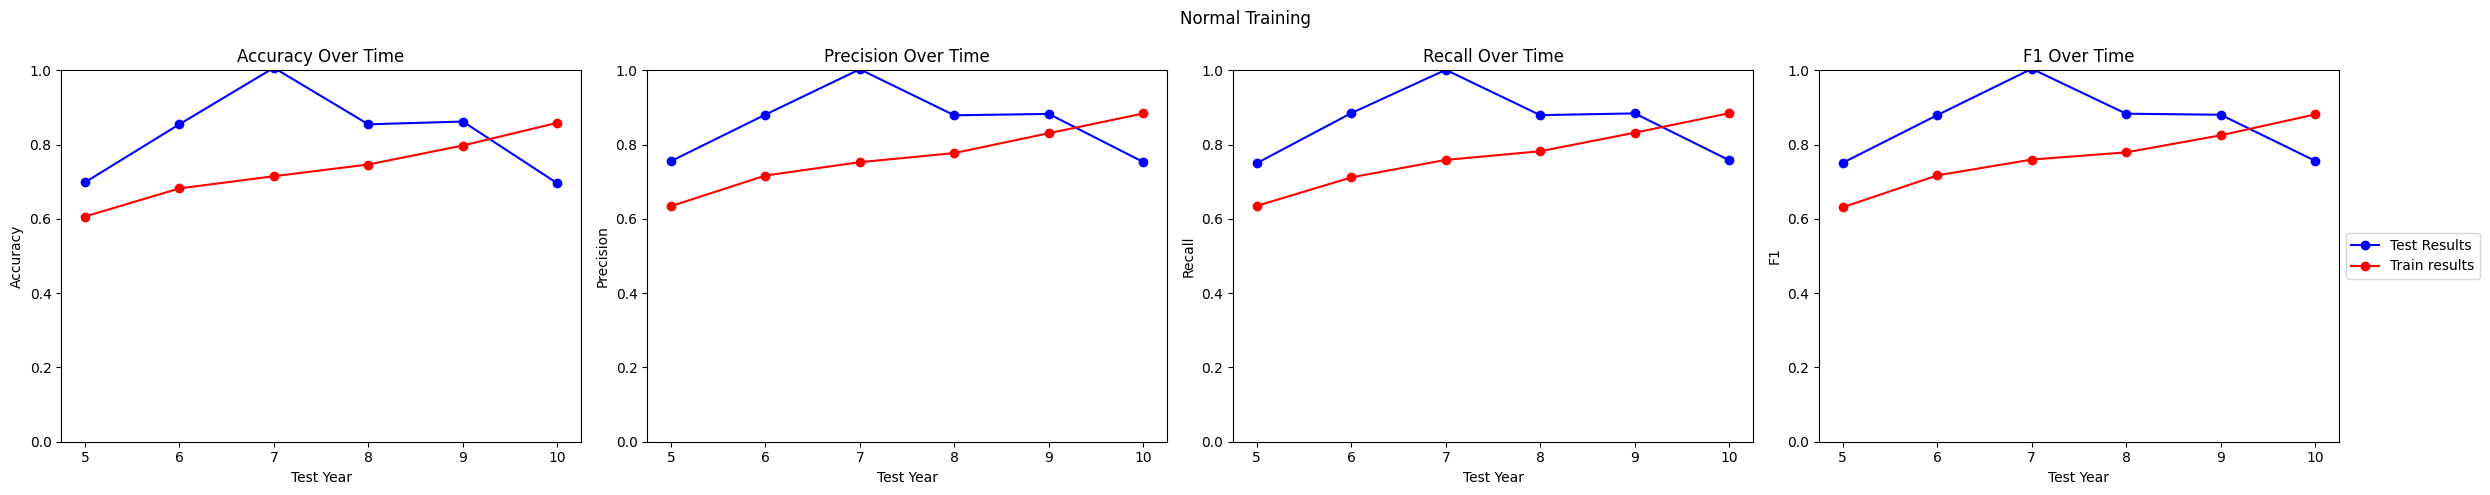

Normal Training
Accuracy: 0.82, Precision: 0.85, Recall: 0.85, F1: 0.85
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


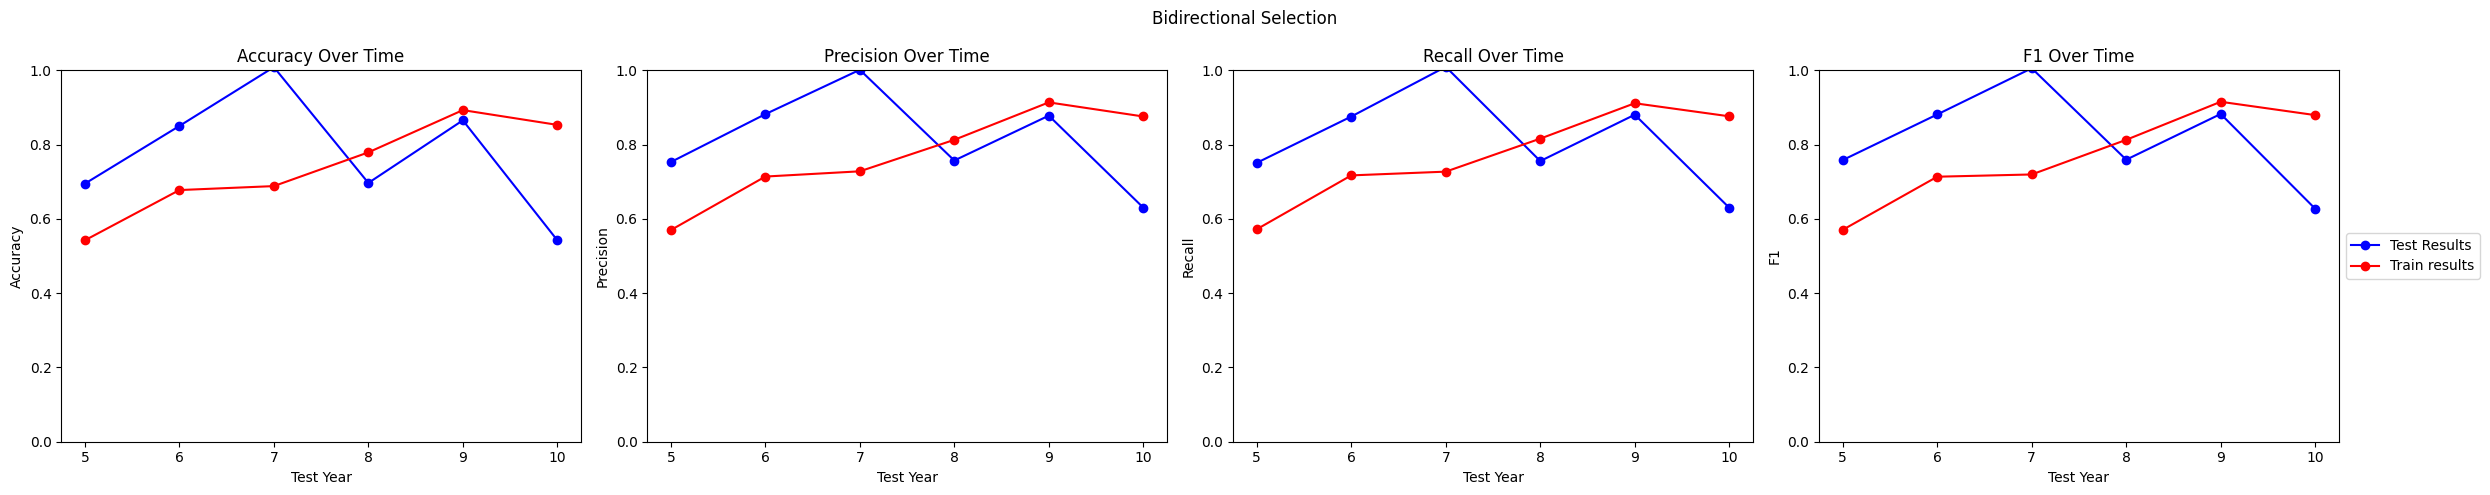

Bidirectional Selection
Accuracy: 0.77, Precision: 0.81, Recall: 0.81, F1: 0.81
10 year
Accuracy: 0.5384615384615384, Precision: 0.625, Recall: 0.625, F1: 0.625


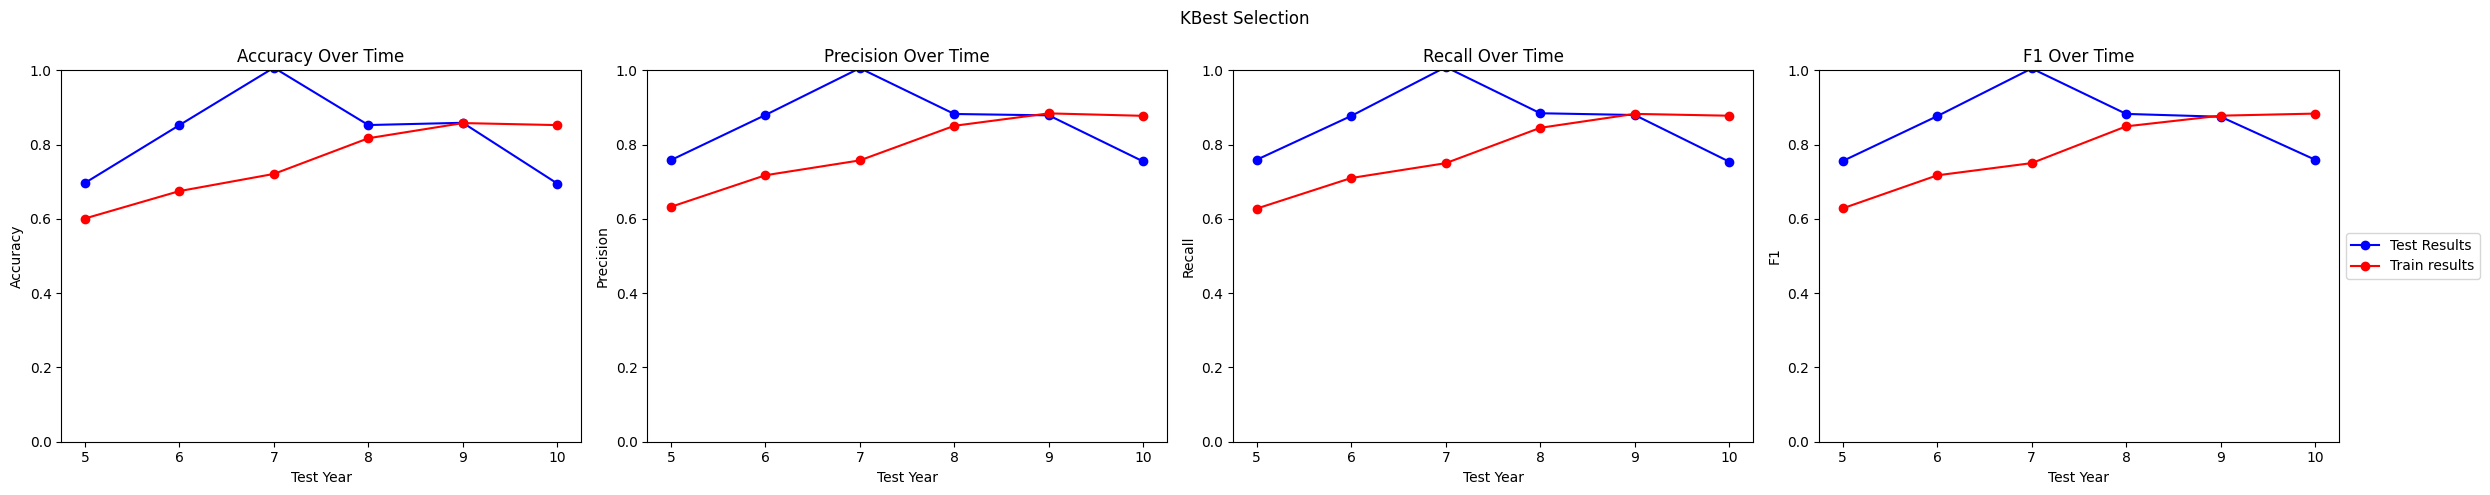

KBest Selection
Accuracy: 0.82, Precision: 0.85, Recall: 0.85, F1: 0.85
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


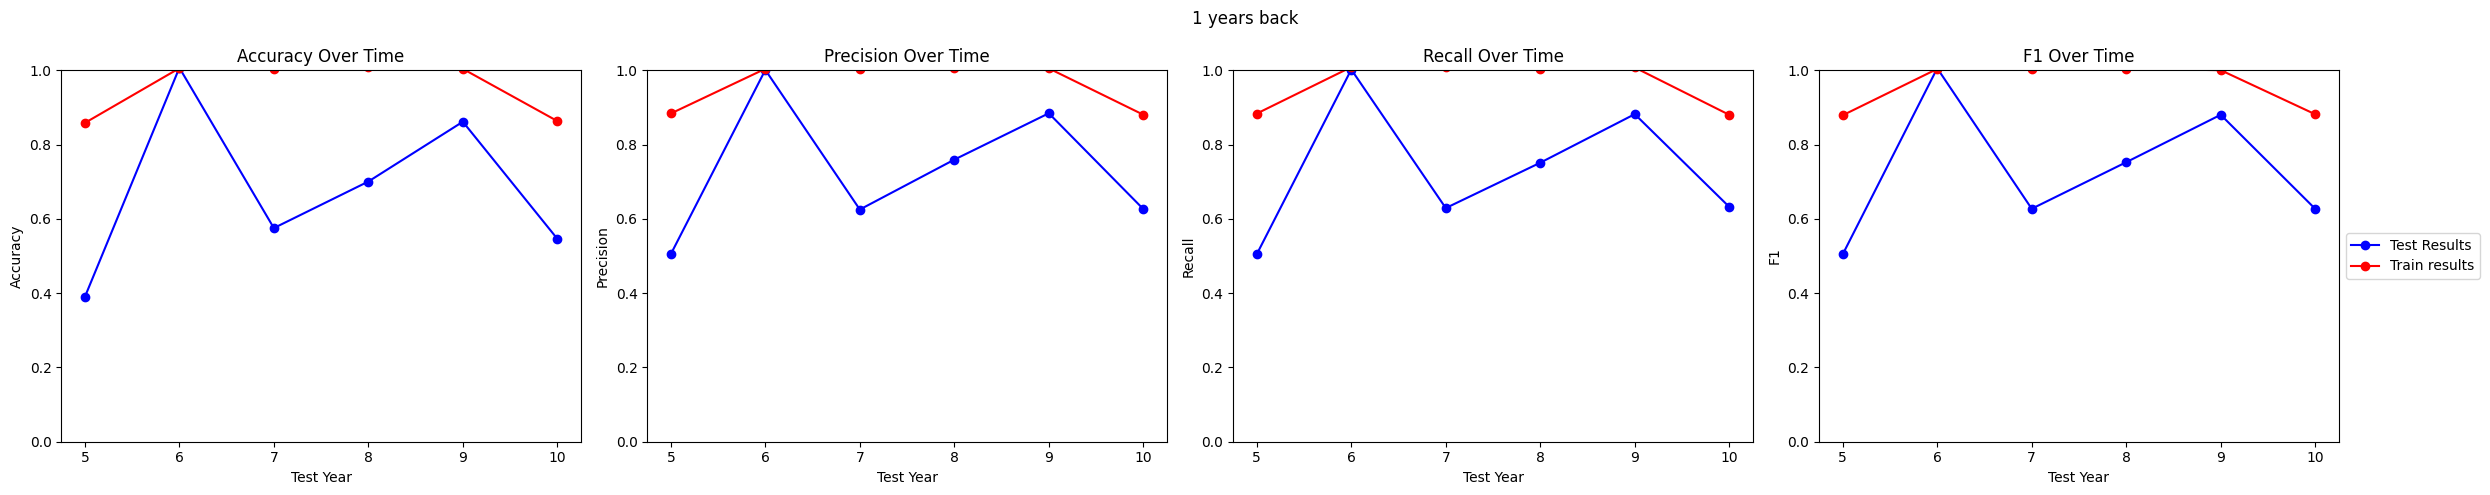

1 years back
Accuracy: 0.67, Precision: 0.73, Recall: 0.73, F1: 0.73
10 year
Accuracy: 0.5384615384615384, Precision: 0.625, Recall: 0.625, F1: 0.625


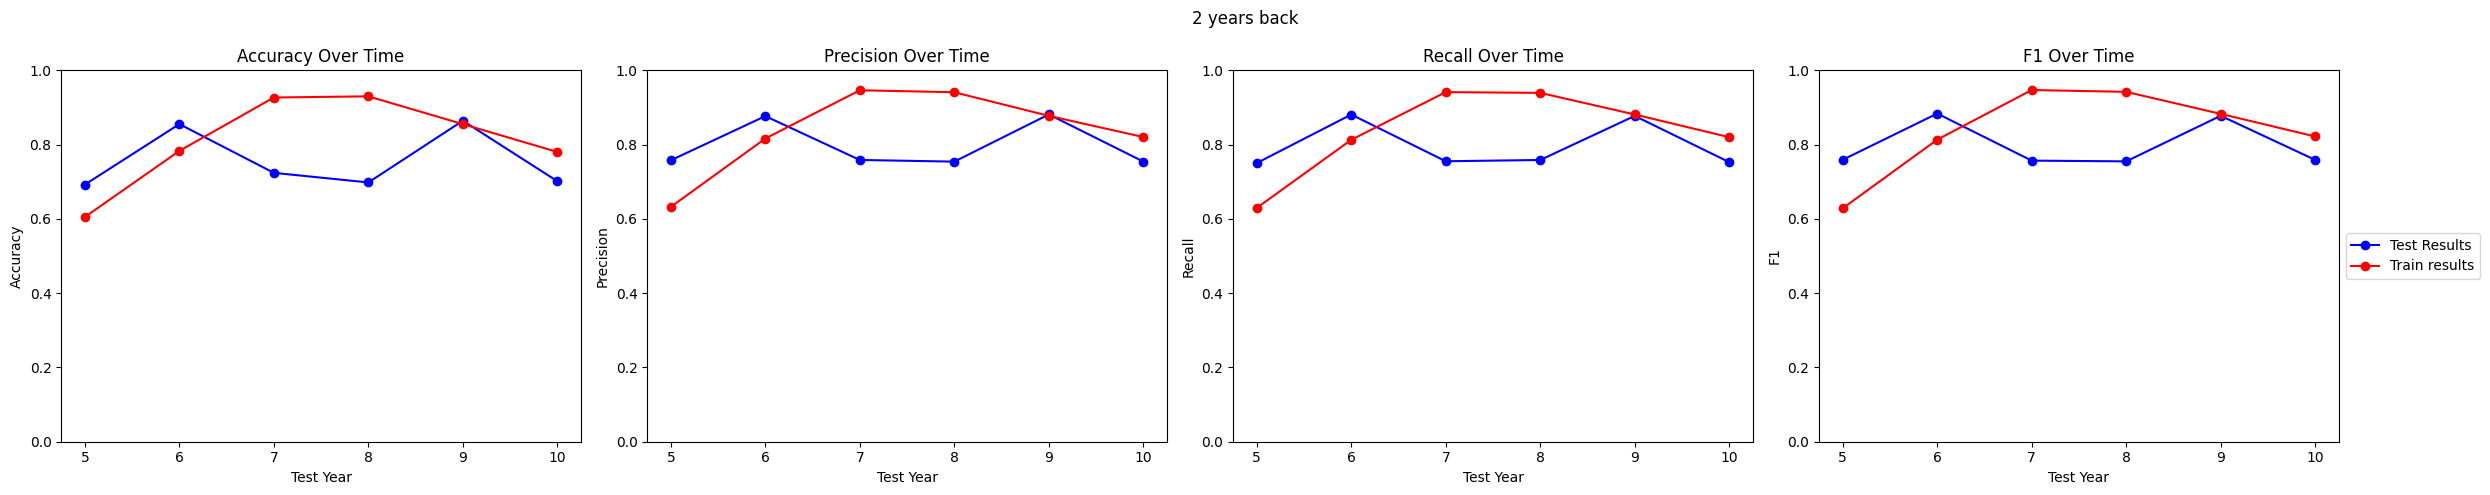

2 years back
Accuracy: 0.75, Precision: 0.79, Recall: 0.79, F1: 0.79
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


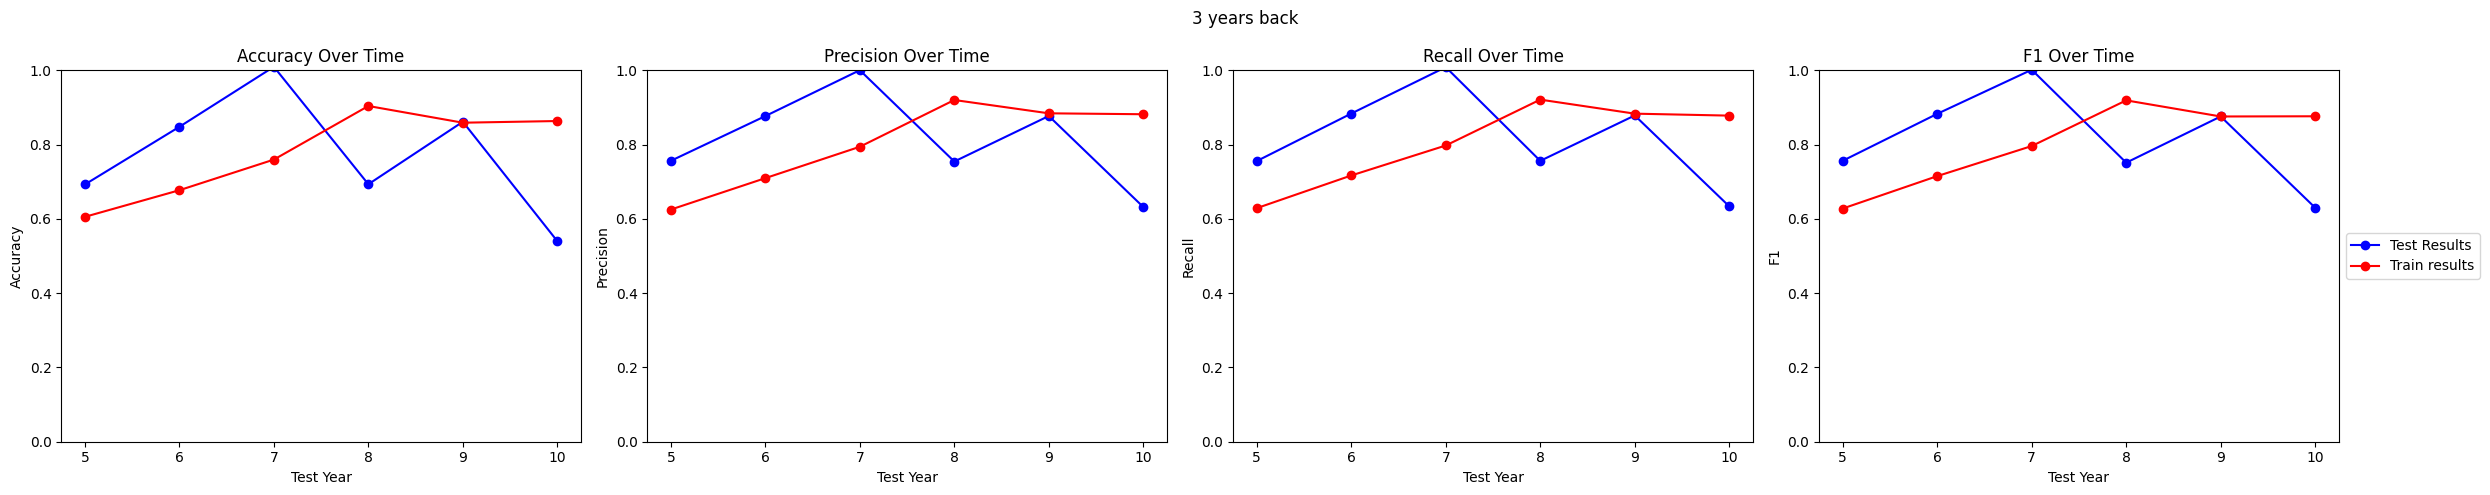

3 years back
Accuracy: 0.77, Precision: 0.81, Recall: 0.81, F1: 0.81
10 year
Accuracy: 0.5384615384615384, Precision: 0.625, Recall: 0.625, F1: 0.625


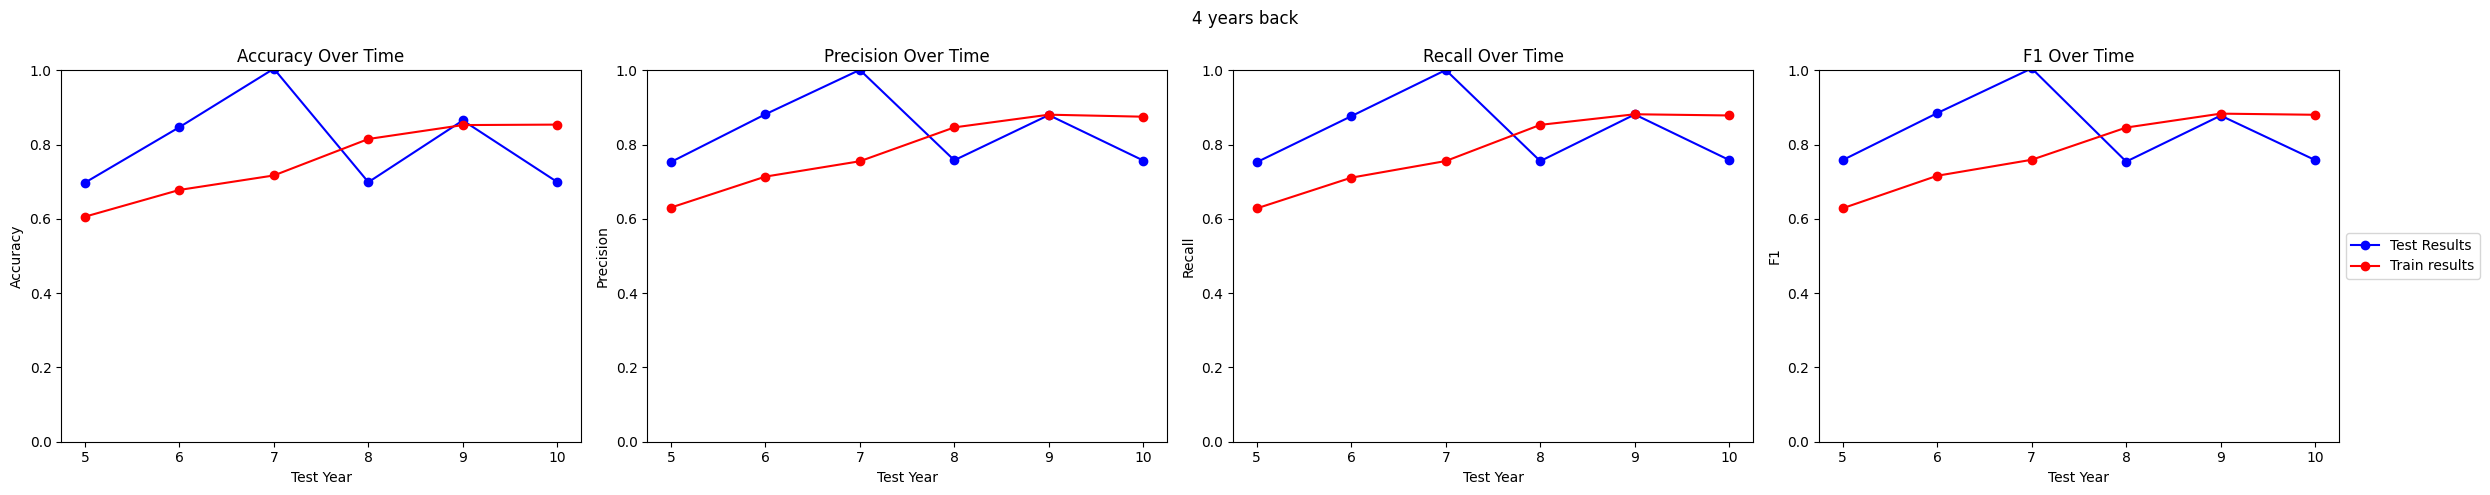

4 years back
Accuracy: 0.80, Precision: 0.83, Recall: 0.83, F1: 0.83
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


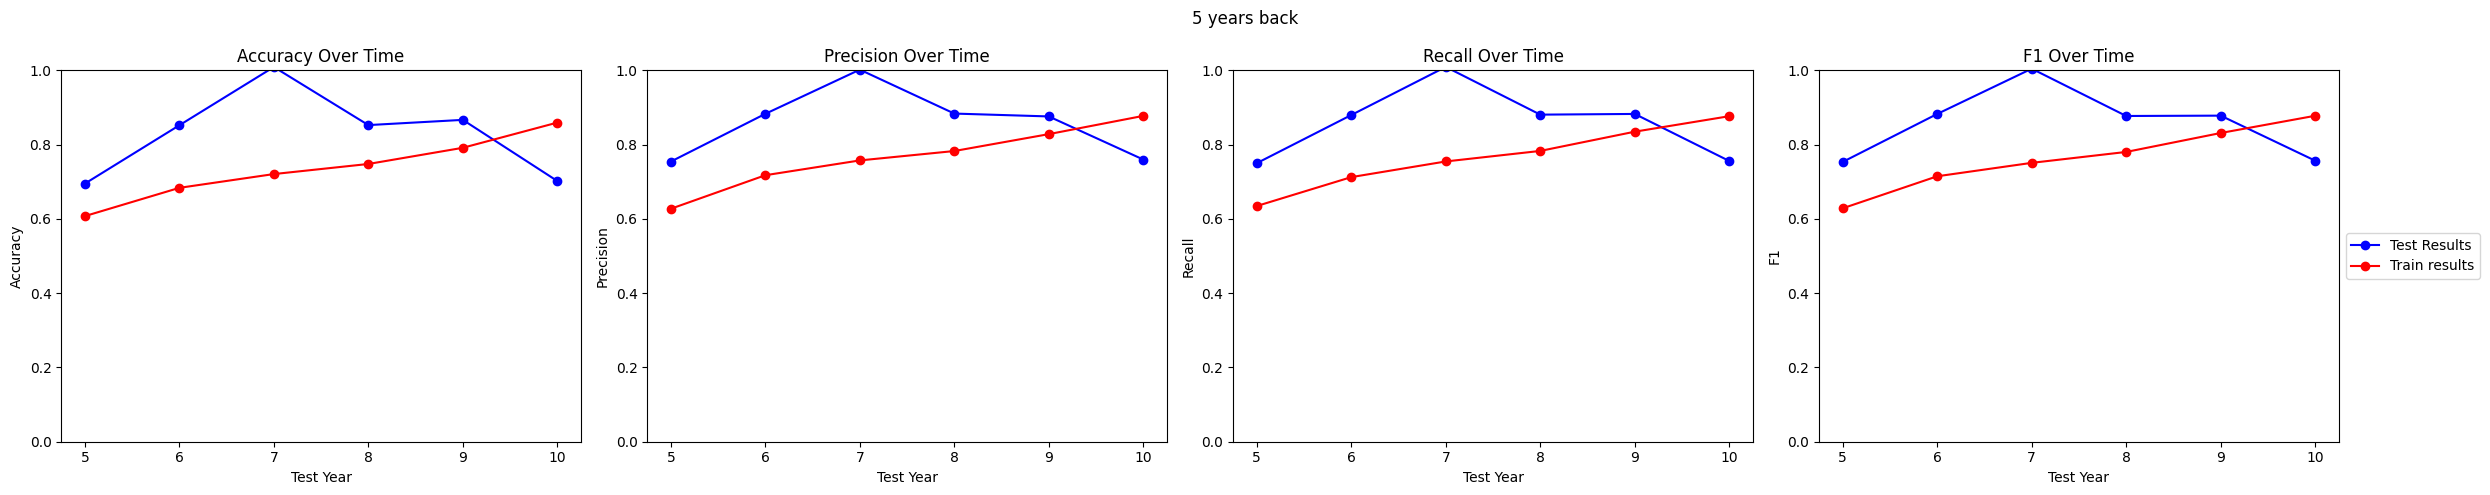

5 years back
Accuracy: 0.82, Precision: 0.85, Recall: 0.85, F1: 0.85
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


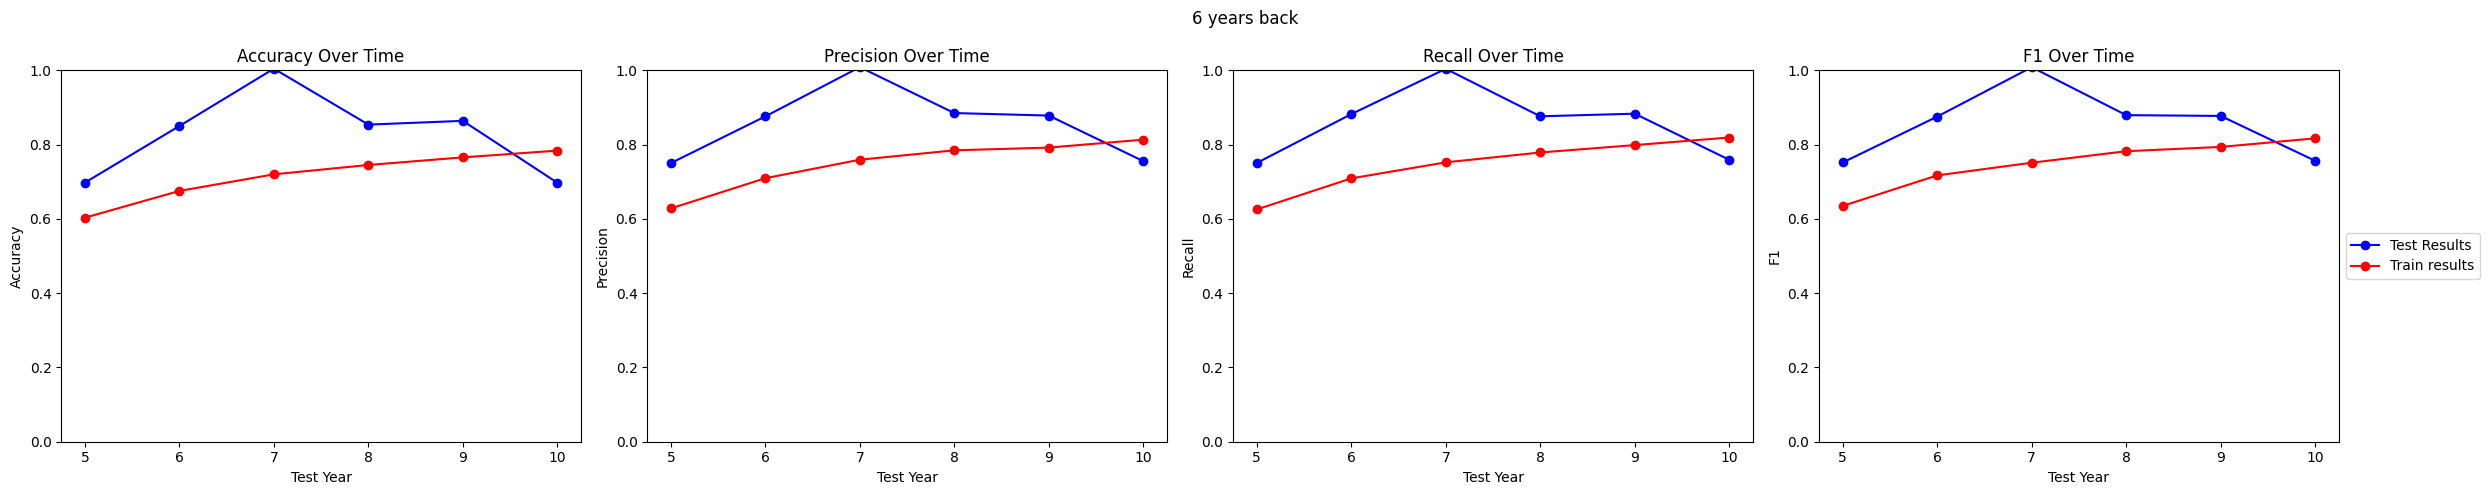

6 years back
Accuracy: 0.82, Precision: 0.85, Recall: 0.85, F1: 0.85
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


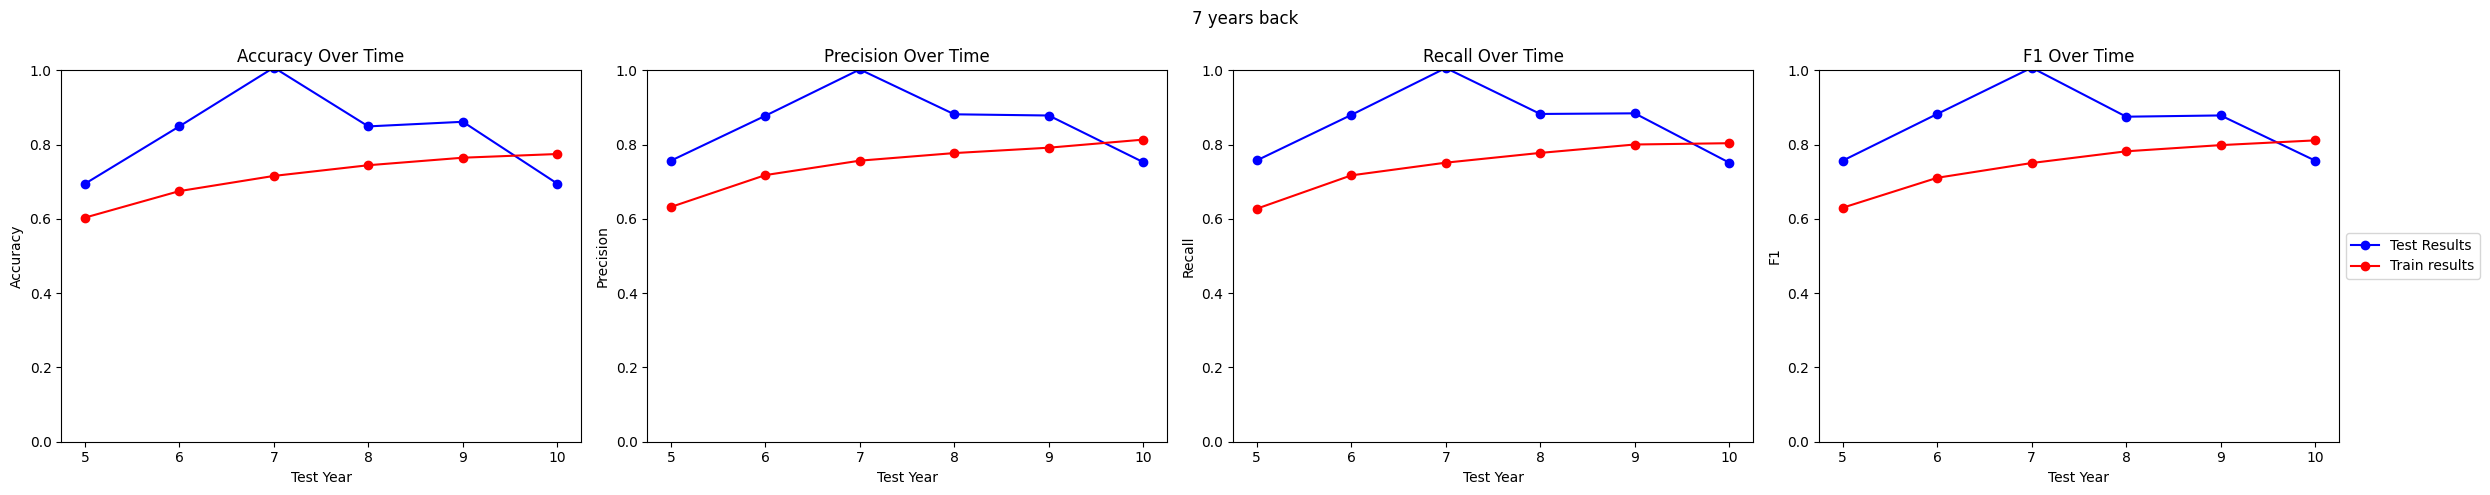

7 years back
Accuracy: 0.82, Precision: 0.85, Recall: 0.85, F1: 0.85
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


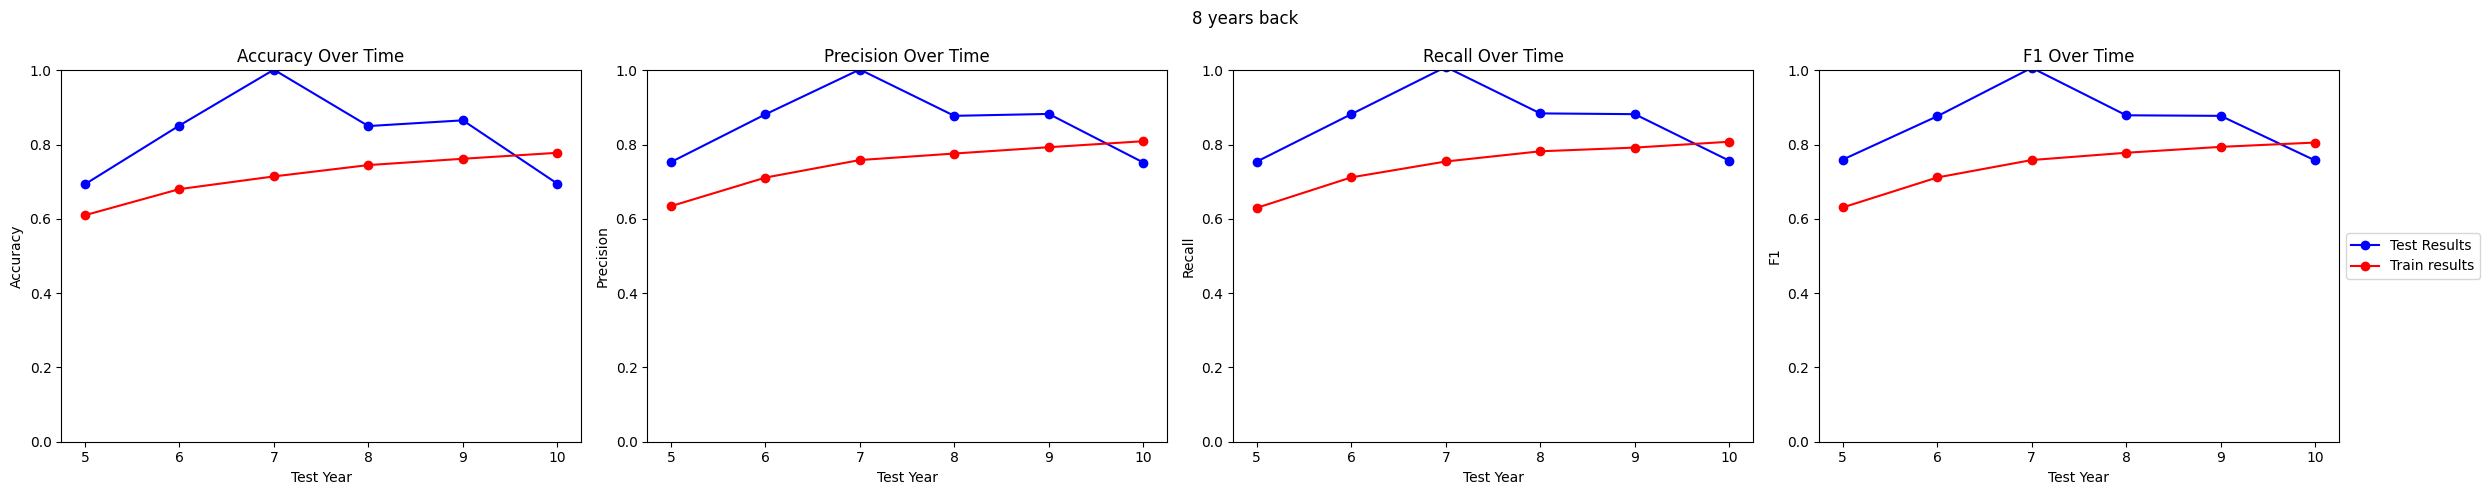

8 years back
Accuracy: 0.82, Precision: 0.85, Recall: 0.85, F1: 0.85
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


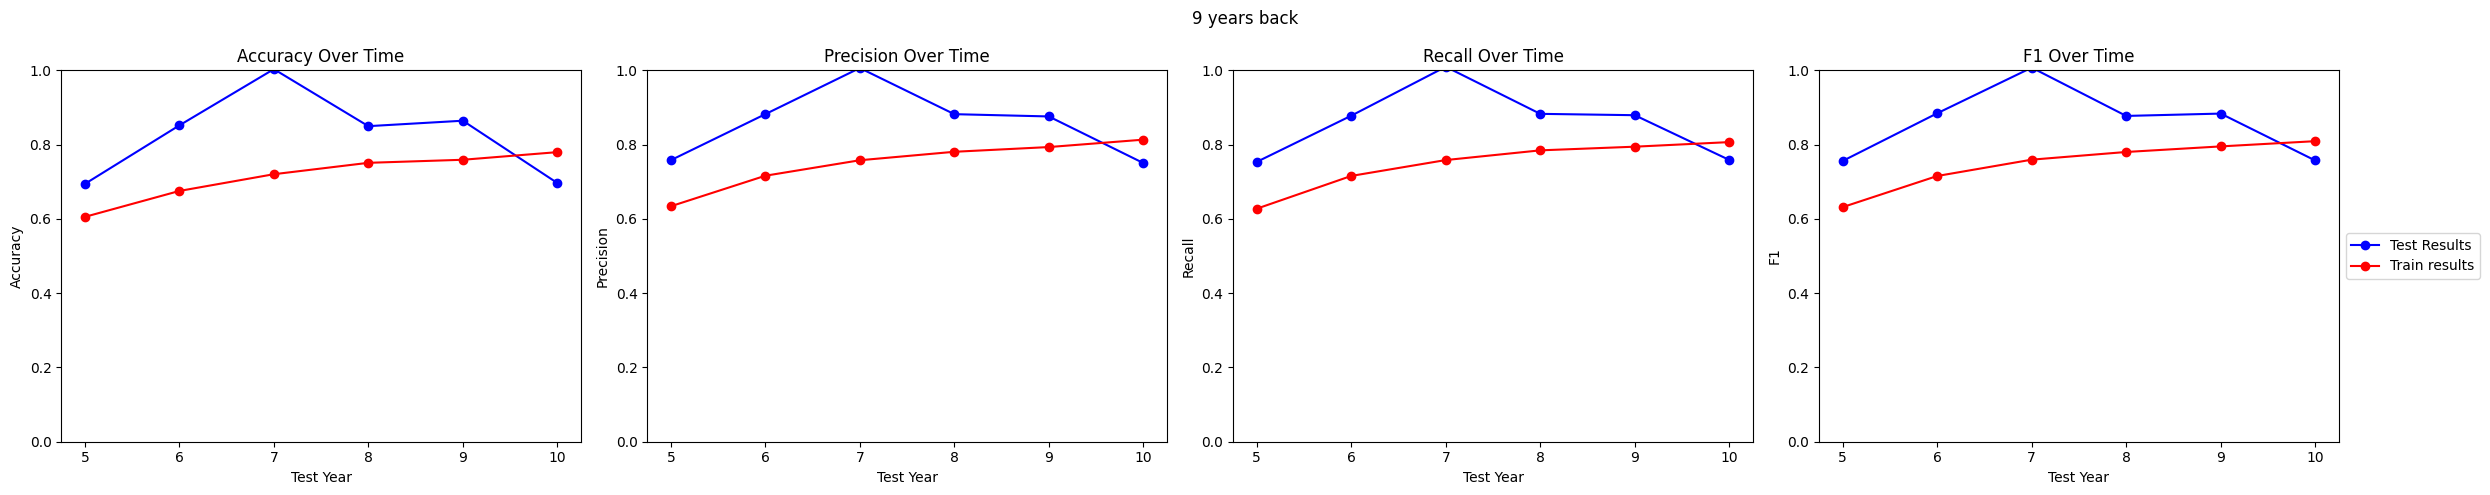

9 years back
Accuracy: 0.82, Precision: 0.85, Recall: 0.85, F1: 0.85
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


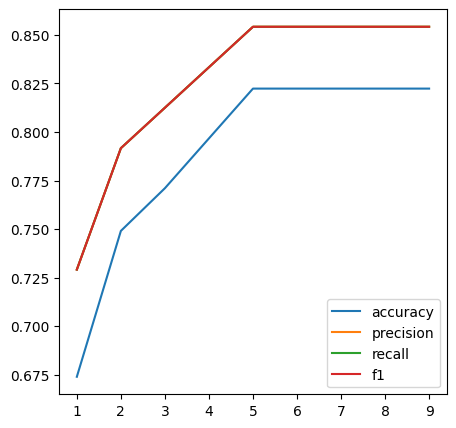

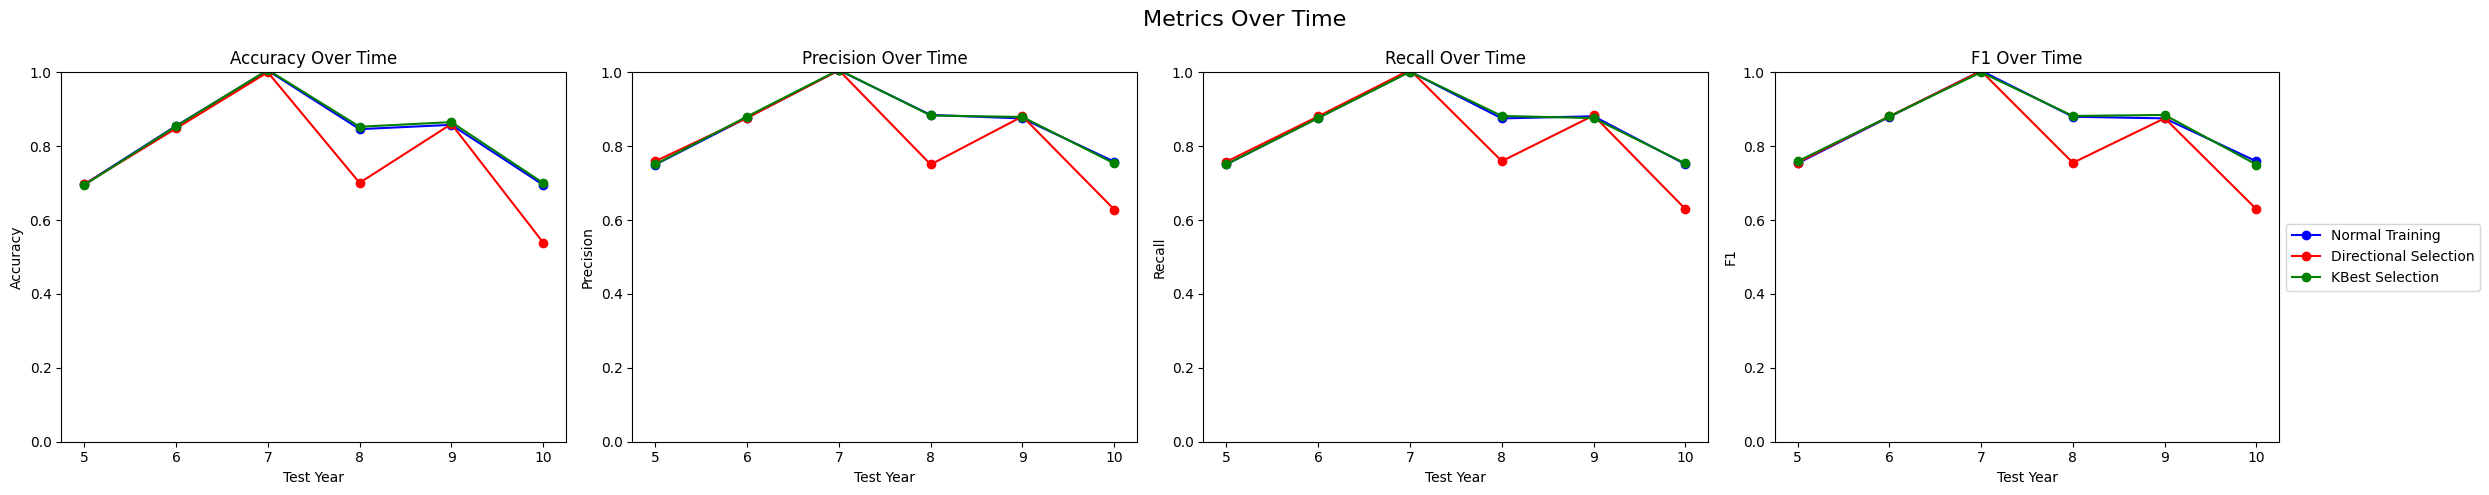

Normal Training
Accuracy: 0.82, Precision: 0.85, Recall: 0.85, F1: 0.85
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75
Directional Selection
Accuracy: 0.77, Precision: 0.81, Recall: 0.81, F1: 0.81
10 year
Accuracy: 0.5384615384615384, Precision: 0.625, Recall: 0.625, F1: 0.625
KBest Selection
Accuracy: 0.82, Precision: 0.85, Recall: 0.85, F1: 0.85
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


In [23]:
model =GaussianNB(priors=None, var_smoothing=1e-09)

features = backwards_elimination(df_teams, model)
print(features)
features_kbest = select_k_best(df_teams, model, years_back=4)
print(features_kbest)
model = model
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams, years_back=5,title="Normal Training")
years_tested, bidirectional_accuracy_scores, bidirectional_precision_scores, bidirectional_recall_scores, bidirectional_f1_scores = train_evaluate_decision_tree_graph(model, df_teams[features],years_back=4,  title="Bidirectional Selection")
years_tested, kbest_accuracy_scores, kbest_precision_scores, kbest_recall_scores, kbest_f1_scores = train_evaluate_decision_tree_graph(model, df_teams[features_kbest],years_back=4, title="KBest Selection")
train_evaluate_decision_tree_years_back(model, df_teams)
plot_metrics_over_time_three(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores, bidirectional_accuracy_scores, bidirectional_precision_scores, bidirectional_recall_scores, bidirectional_f1_scores, kbest_accuracy_scores, kbest_precision_scores, kbest_recall_scores, kbest_f1_scores)


### SVC

#### Hyperparameter tuning

In [24]:

# model = SVC(probability=True)
# param_grid = {'C': [0.001, 0.1, 1, 10],
#                 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#                 'degree': [1, 2, 3, 4, 5, 6],
#                 'gamma': [1,0.1,0.001,0.0001,'scale', 'auto'],
                    
#               }
              
# best_param, best_score = custom_grid_search(model, df_teams, param_grid, scaling=True)
# print(best_param, best_score)





#{'C': 0.1, 'degree': 5, 'gamma': 0.001, 'kernel': 'rbf'} 0.7197802197802198


In [25]:
# model = SVC(probability=True, C=0.1, degree=5, gamma=0.001, kernel='rbf')
# features = backwards_elimination(df_teams, model, scaling=True )
# print(features)

# features_kbest = select_k_best(df_teams, model, scaling=True)
# print(features_kbest)
# years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams, scaling=True, title="Normal Training")
# years_tested, bidirectional_accuracy_scores, bidirectional_precision_scores, bidirectional_recall_scores, bidirectional_f1_scores = train_evaluate_decision_tree_graph(model, df_teams[features], scaling=True, title="Bidirectional Selection")
# years_tested, kbest_accuracy_scores, kbest_precision_scores, kbest_recall_scores, kbest_f1_scores = train_evaluate_decision_tree_graph(model, df_teams[features_kbest], scaling=True, title="KBest Selection")
# train_evaluate_decision_tree_years_back(model, df_teams, scaling=True)
# plot_metrics_over_time_three(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores, bidirectional_accuracy_scores, bidirectional_precision_scores, bidirectional_recall_scores, bidirectional_f1_scores, kbest_accuracy_scores, kbest_precision_scores, kbest_recall_scores, kbest_f1_scores)


### Logistic regression

#### Hyperparameter tuning

In [26]:

# model = LogisticRegression()
# param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000],
#                 'penalty': [ 'l2'],
#                 'solver': [ 'lbfgs', 'sag', 'saga', 'newton-cg'],
#                 'max_iter': [100, 200, 300, 400, 500],
#                 'multi_class': ['auto', 'ovr', 'multinomial'],
#                 'class_weight': ['balanced', None],
                    
#               }
# best_param, best_score = custom_grid_search(model, df_teams, param_grid, scaling=True)
# print(best_param, best_score)

# #{'C': 0.01, 'class_weight': 'balanced', 'max_iter': 100, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'lbfgs'} 0.771062271062271


['attend', 'total_semis_won', 'total_semis_lost', 'GP', 'lost', 'points_precision', 'tmID_SEA', 'playoff', 'year', 'confID_EA', 'confID_WE', 'tmID_ATL', 'tmID_CHA', 'tmID_CHI', 'tmID_CLE', 'tmID_CON', 'tmID_DET', 'tmID_HOU', 'tmID_IND', 'tmID_LAS', 'tmID_MIA', 'tmID_MIN', 'tmID_NYL', 'tmID_ORL', 'tmID_PHO', 'tmID_POR', 'tmID_SAC', 'tmID_SAS', 'tmID_UTA', 'tmID_WAS']
hightest_accuracy_score:  0.7967032967032966


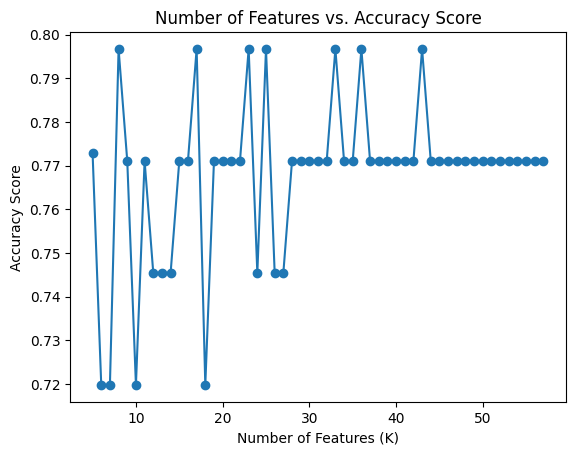

Index(['total_first_round_won', 'total_semis_won', 'minutes', 'PostGS',
       'PostMinutes', 'performance', 'points_precision', 'tmID_ATL', 'playoff',
       'year', 'confID_EA', 'confID_WE', 'tmID_CHA', 'tmID_CHI', 'tmID_CLE',
       'tmID_CON', 'tmID_DET', 'tmID_HOU', 'tmID_IND', 'tmID_LAS', 'tmID_MIA',
       'tmID_MIN', 'tmID_NYL', 'tmID_ORL', 'tmID_PHO', 'tmID_POR', 'tmID_SAC',
       'tmID_SAS', 'tmID_SEA', 'tmID_UTA', 'tmID_WAS'],
      dtype='object')


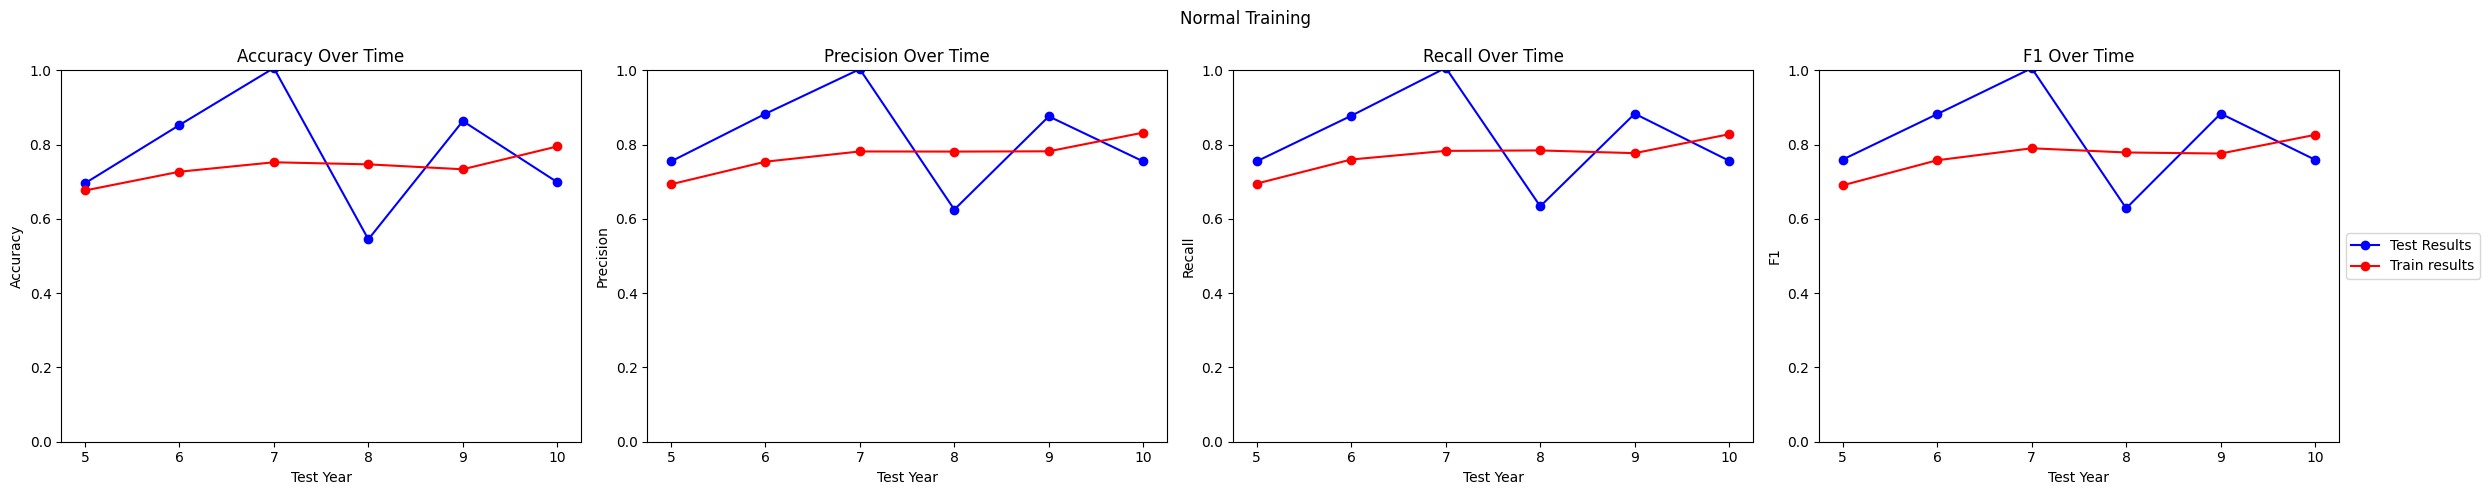

Normal Training
Accuracy: 0.77, Precision: 0.81, Recall: 0.81, F1: 0.81
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


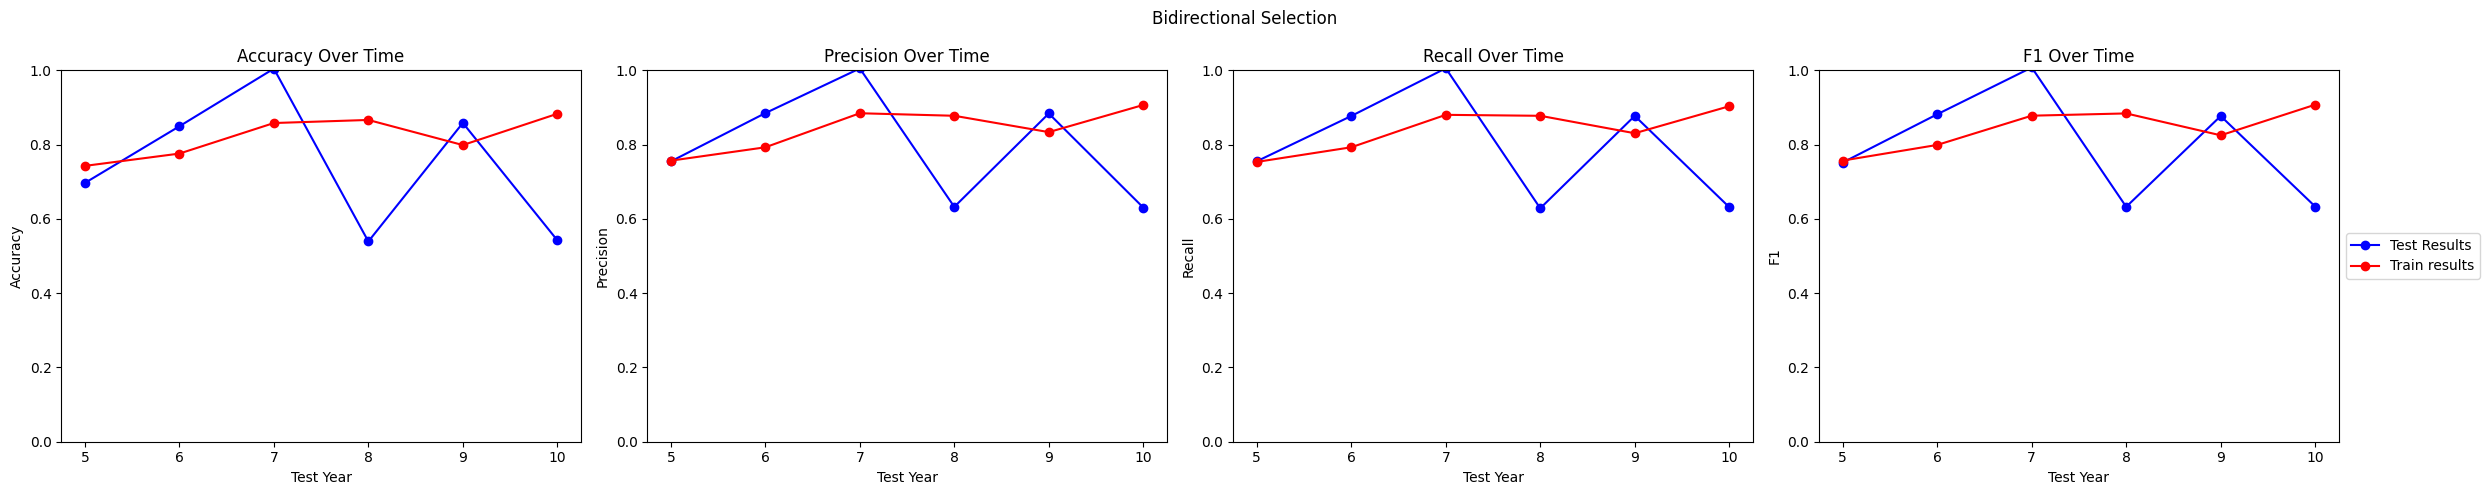

Bidirectional Selection
Accuracy: 0.75, Precision: 0.79, Recall: 0.79, F1: 0.79
10 year
Accuracy: 0.5384615384615384, Precision: 0.625, Recall: 0.625, F1: 0.625


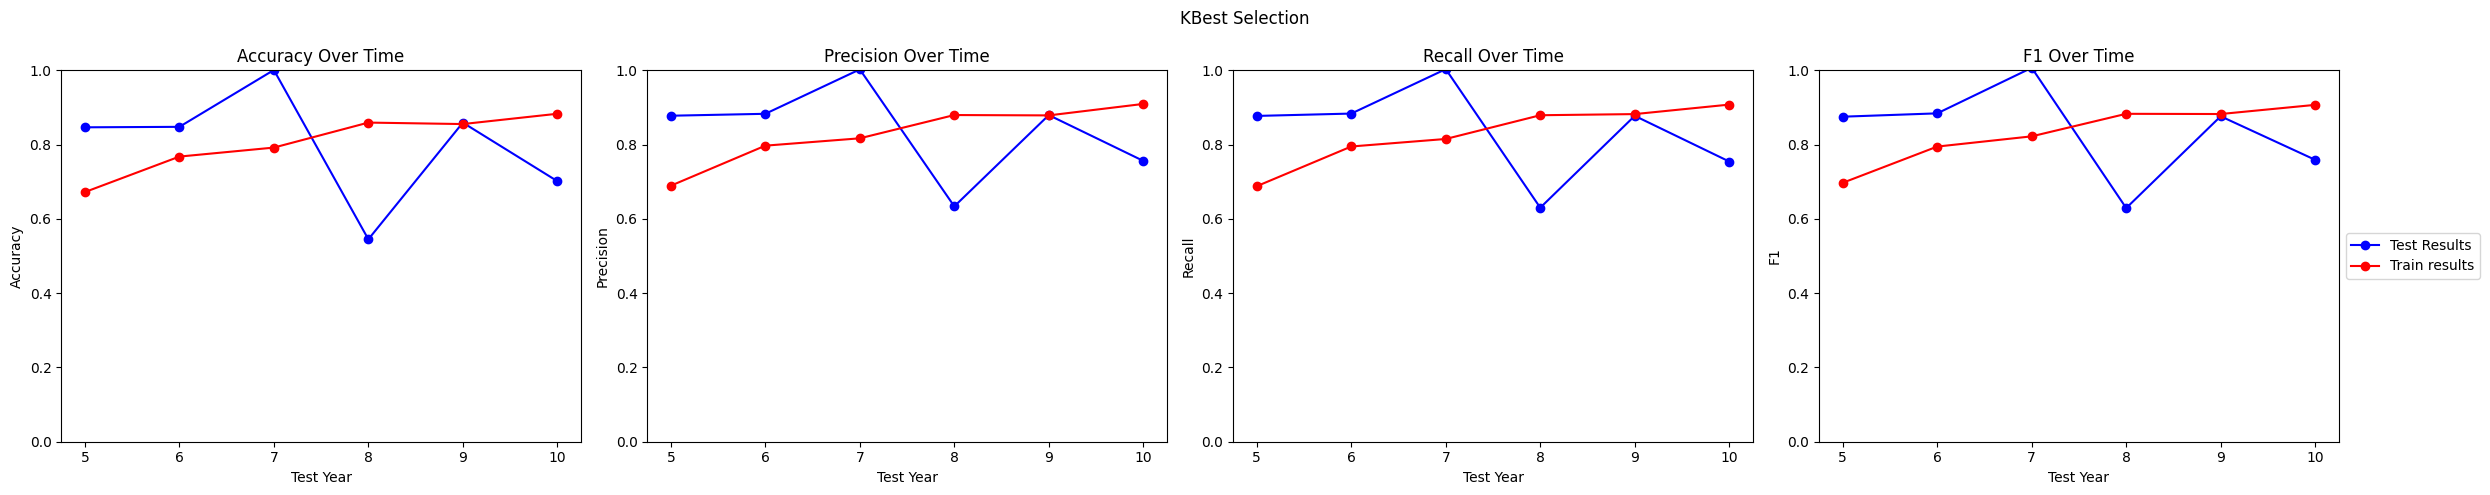

KBest Selection
Accuracy: 0.80, Precision: 0.83, Recall: 0.83, F1: 0.83
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


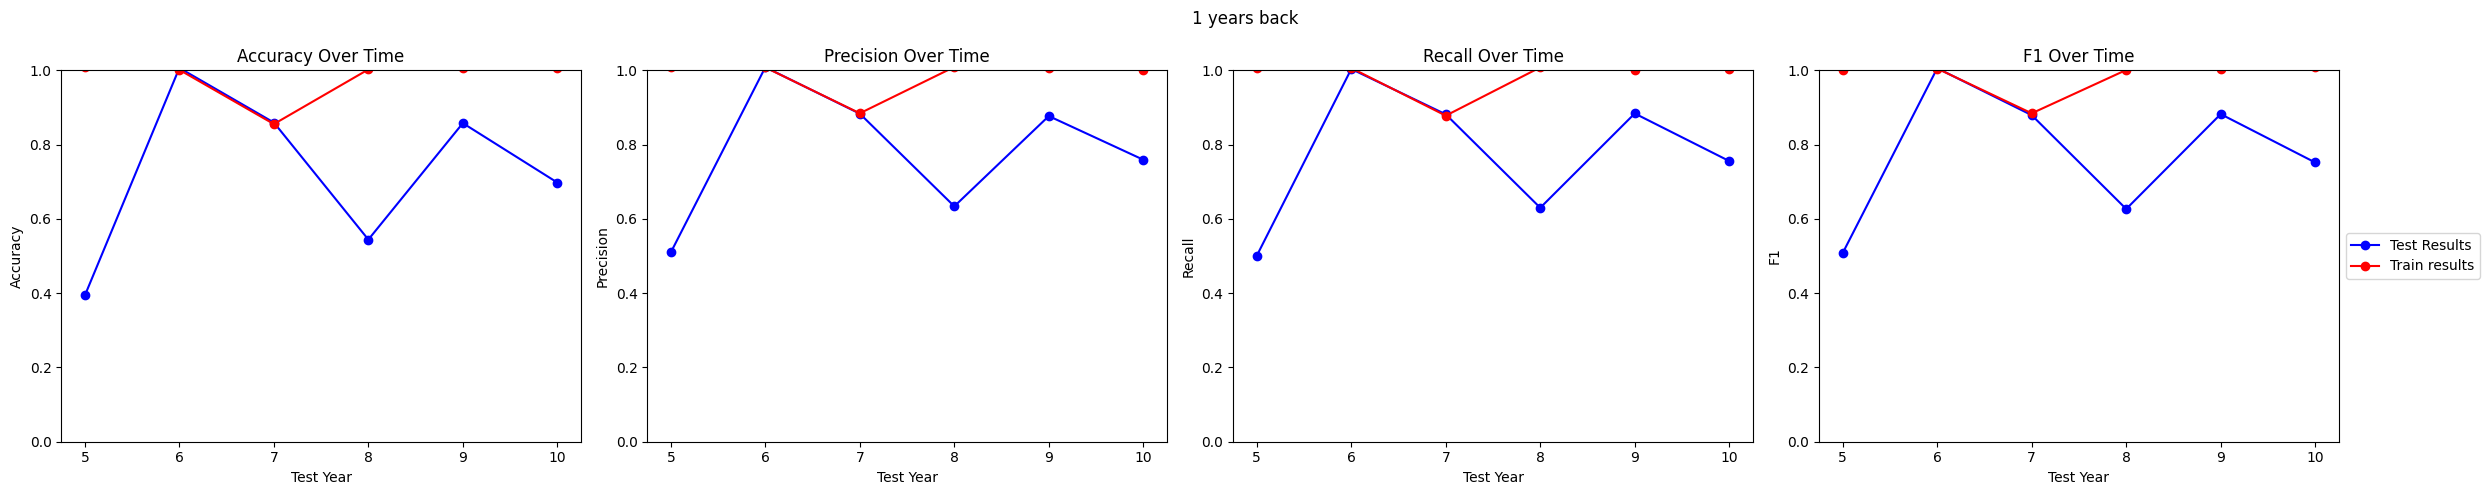

1 years back
Accuracy: 0.72, Precision: 0.77, Recall: 0.77, F1: 0.77
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


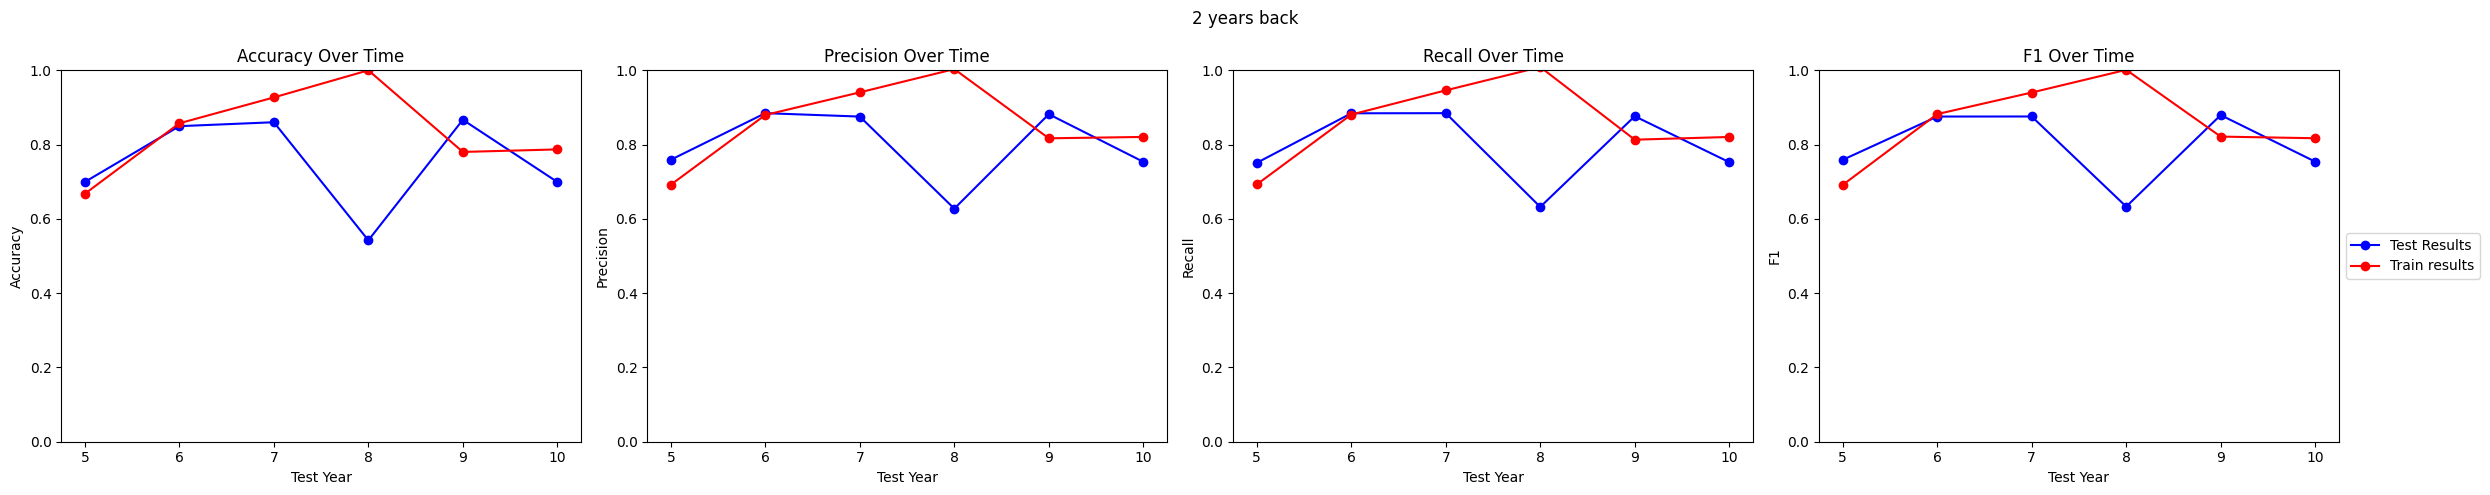

2 years back
Accuracy: 0.75, Precision: 0.79, Recall: 0.79, F1: 0.79
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


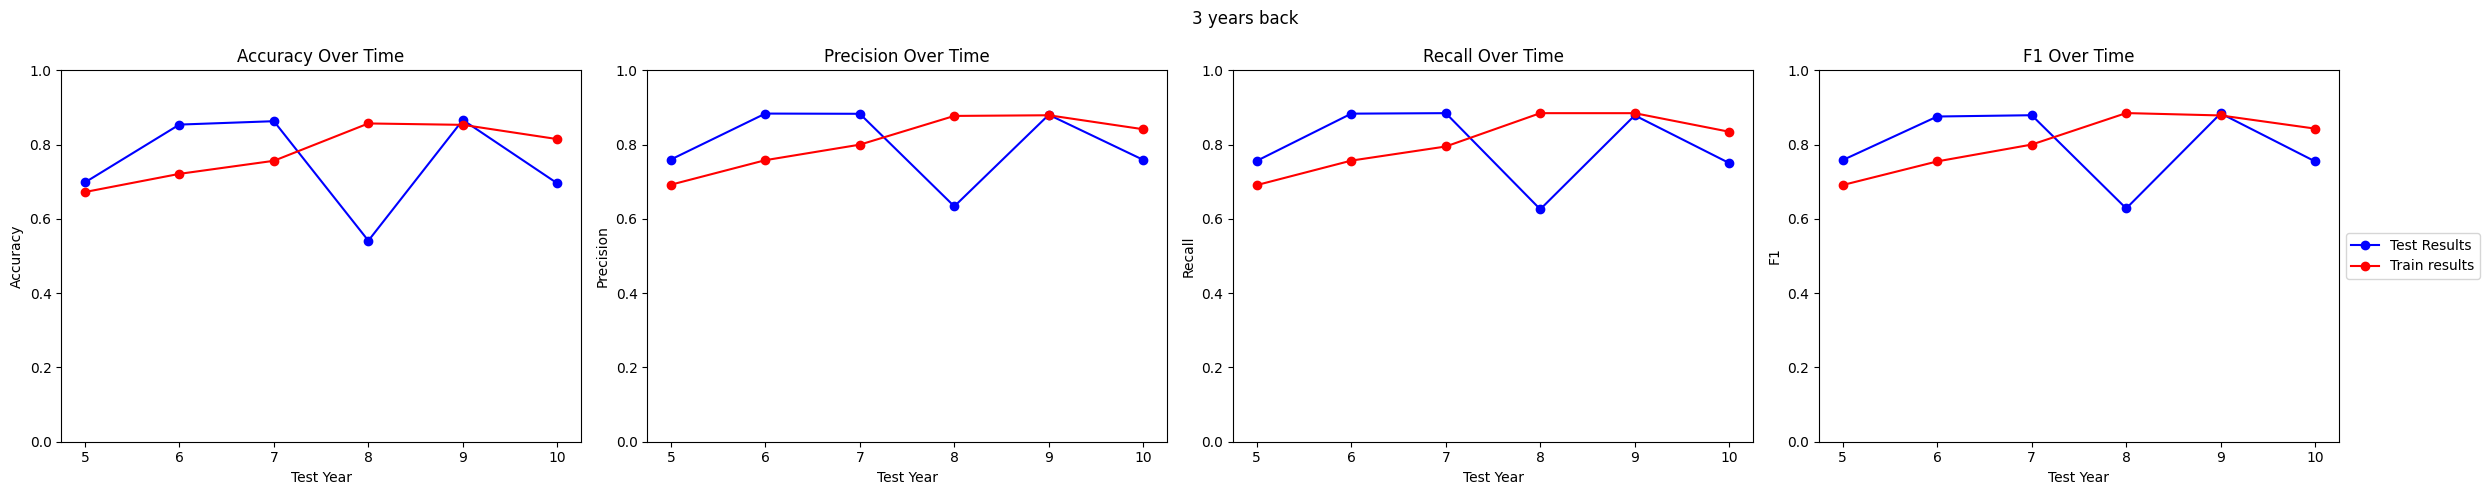

3 years back
Accuracy: 0.75, Precision: 0.79, Recall: 0.79, F1: 0.79
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


4 years back
Accuracy: 0.77, Precision: 0.81, Recall: 0.81, F1: 0.81
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


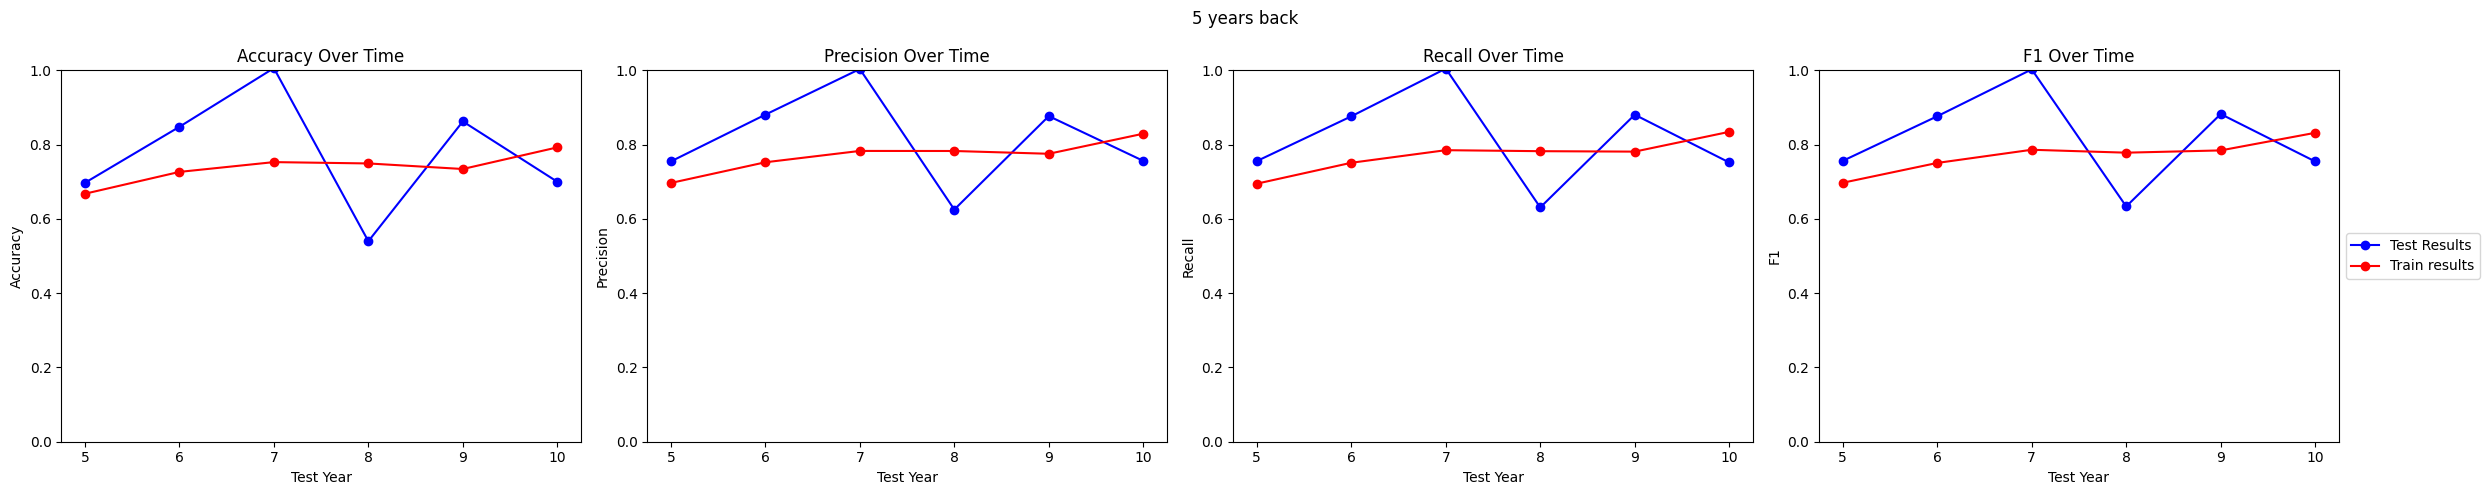

5 years back
Accuracy: 0.77, Precision: 0.81, Recall: 0.81, F1: 0.81
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


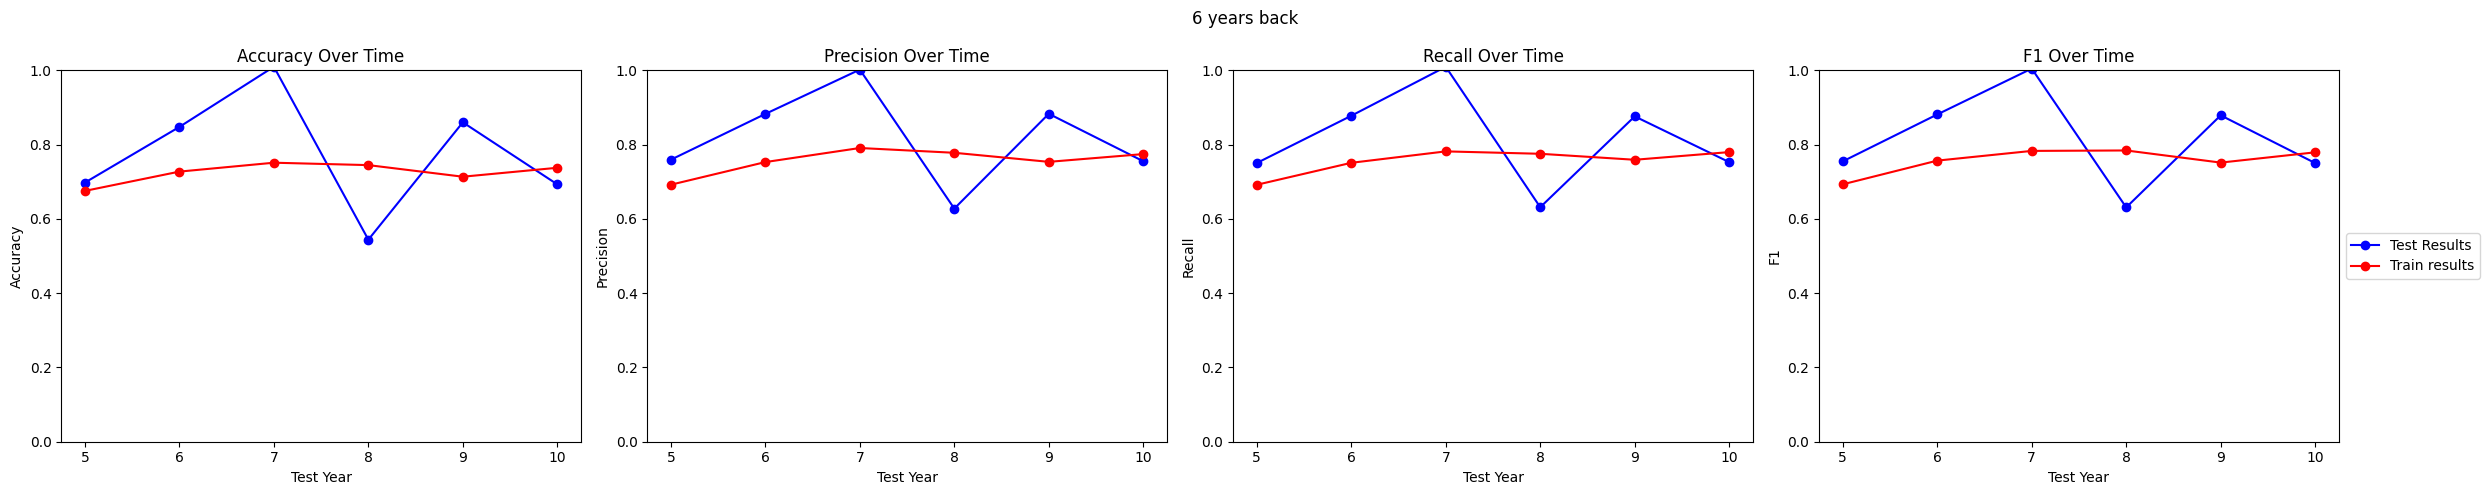

6 years back
Accuracy: 0.77, Precision: 0.81, Recall: 0.81, F1: 0.81
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


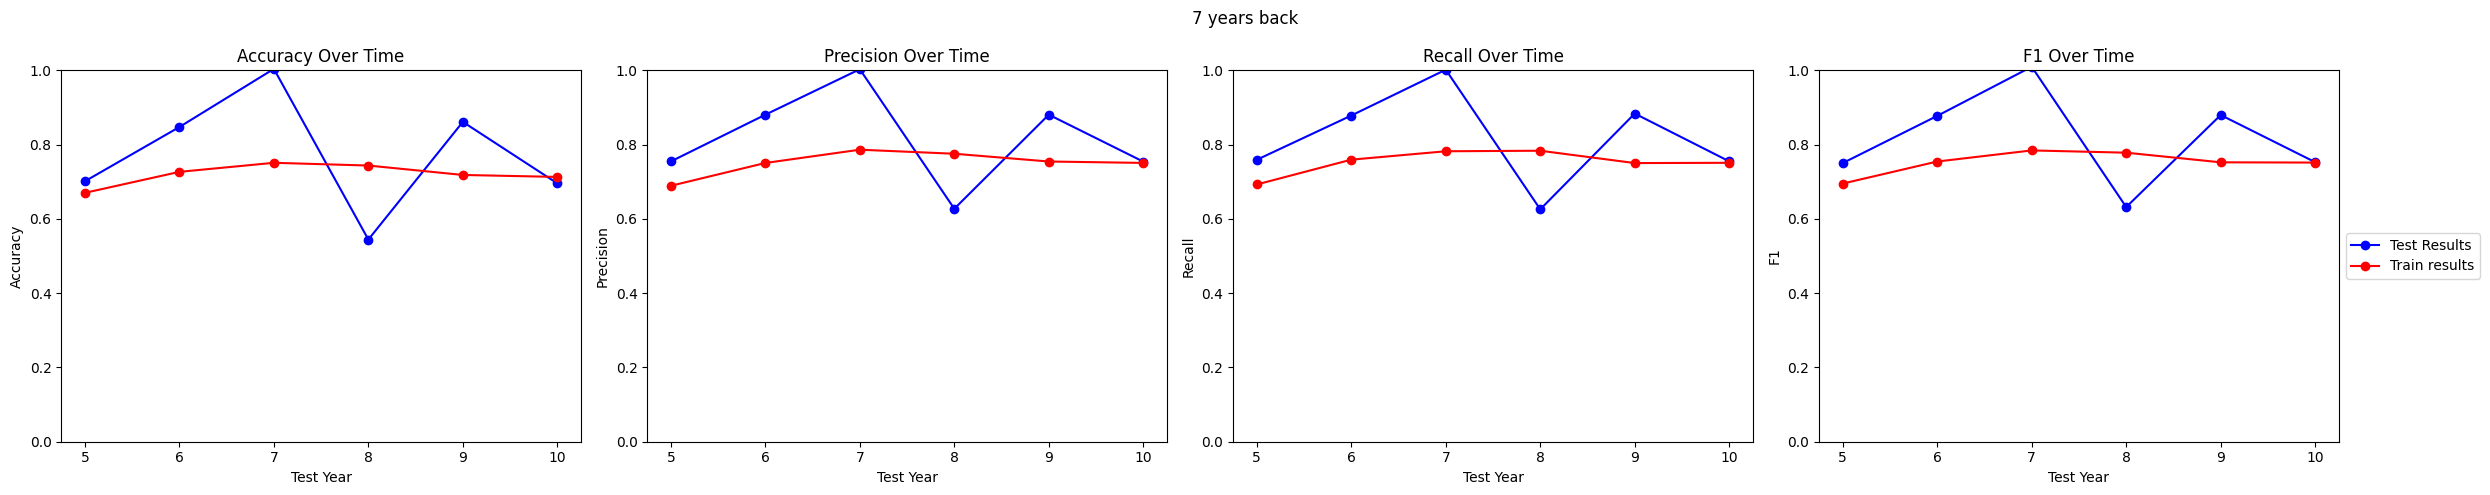

7 years back
Accuracy: 0.77, Precision: 0.81, Recall: 0.81, F1: 0.81
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


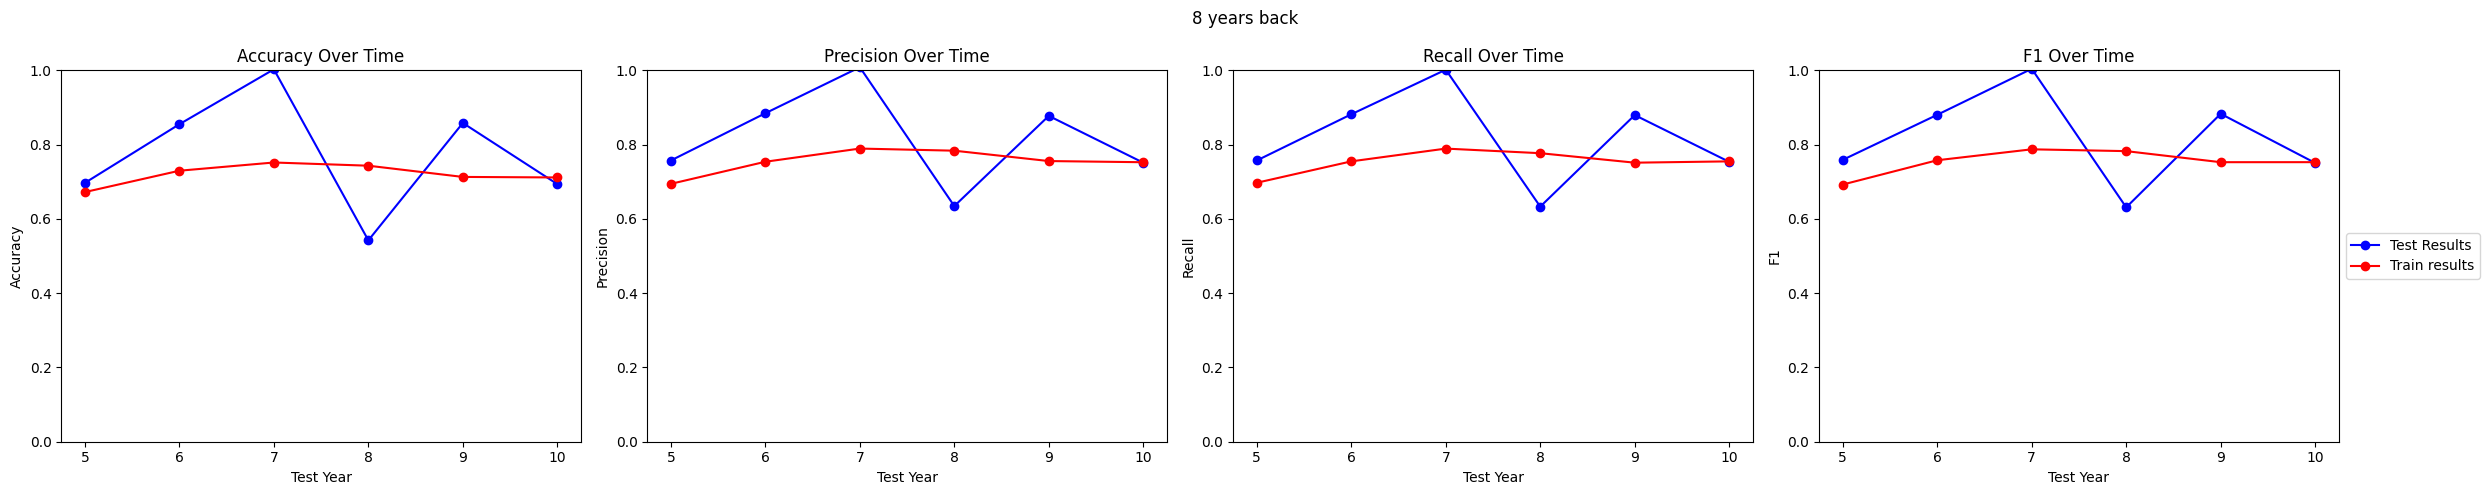

8 years back
Accuracy: 0.77, Precision: 0.81, Recall: 0.81, F1: 0.81
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


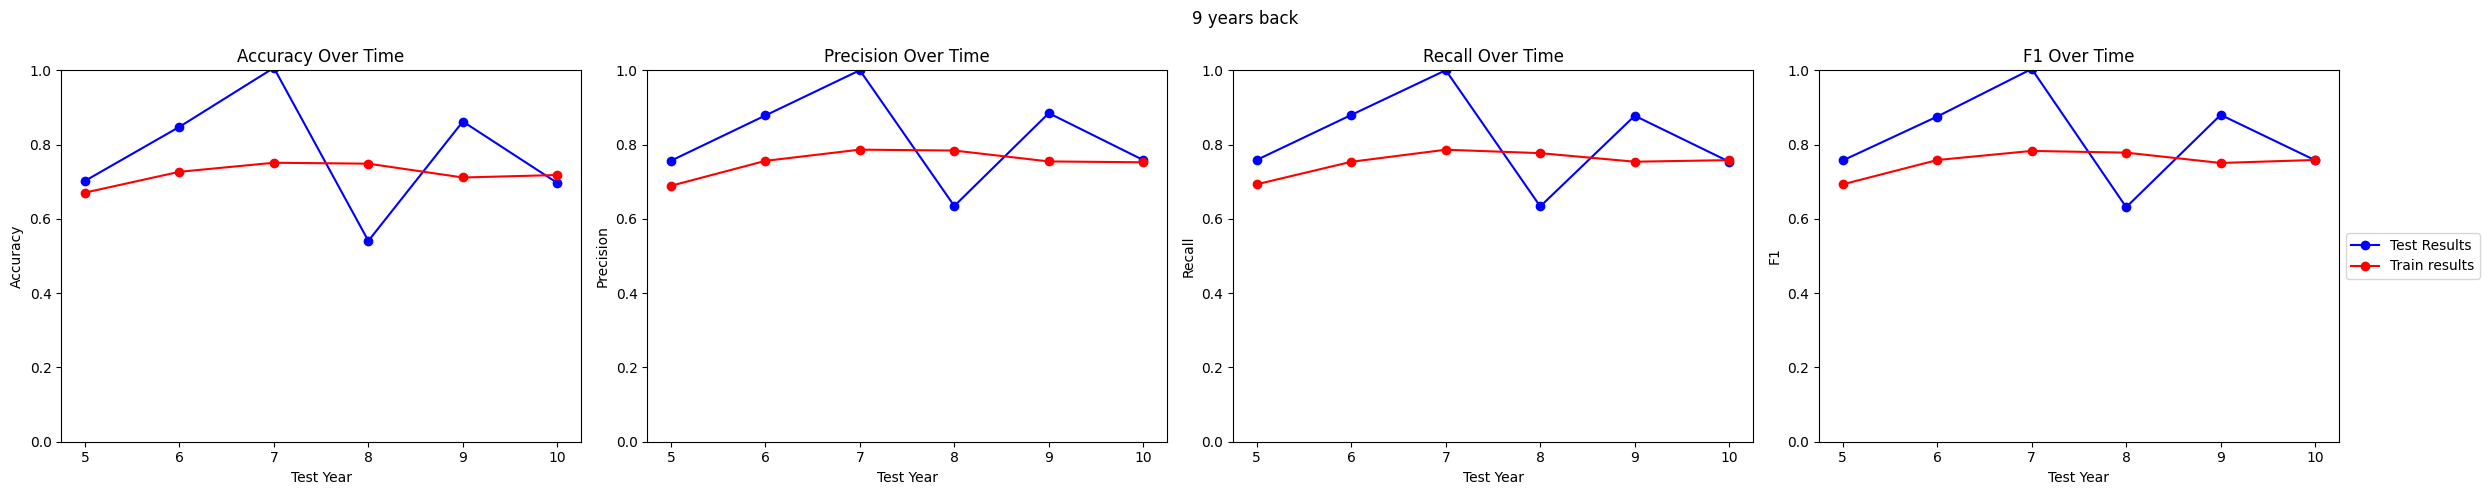

9 years back
Accuracy: 0.77, Precision: 0.81, Recall: 0.81, F1: 0.81
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


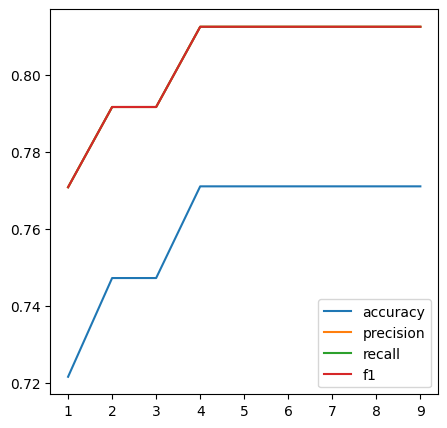

Normal Training
Accuracy: 0.77, Precision: 0.81, Recall: 0.81, F1: 0.81
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75
Directional Selection
Accuracy: 0.75, Precision: 0.79, Recall: 0.79, F1: 0.79
10 year
Accuracy: 0.5384615384615384, Precision: 0.625, Recall: 0.625, F1: 0.625
KBest Selection
Accuracy: 0.80, Precision: 0.83, Recall: 0.83, F1: 0.83
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


In [27]:
model = LogisticRegression(C=0.01, class_weight='balanced', max_iter=100, multi_class='auto', penalty='l2', solver='lbfgs')
features = backwards_elimination(df_teams, model, scaling=True)
print(features)
features_kbest = select_k_best(df_teams, model, scaling=True, years_back=5)
print(features_kbest)
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams, scaling=True,years_back=5, title="Normal Training")
years_tested, bidirectional_accuracy_scores, bidirectional_precision_scores, bidirectional_recall_scores, bidirectional_f1_scores = train_evaluate_decision_tree_graph(model, df_teams[features], scaling=True,years_back=5, title="Bidirectional Selection")
years_tested, kbest_accuracy_scores, kbest_precision_scores, kbest_recall_scores, kbest_f1_scores = train_evaluate_decision_tree_graph(model, df_teams[features_kbest], scaling=True,years_back=5, title="KBest Selection")
train_evaluate_decision_tree_years_back(model, df_teams, scaling=True)
plot_metrics_over_time_three(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores, bidirectional_accuracy_scores, bidirectional_precision_scores, bidirectional_recall_scores, bidirectional_f1_scores, kbest_accuracy_scores, kbest_precision_scores, kbest_recall_scores, kbest_f1_scores)

### MPL

#### Hyperparameter tuning

In [32]:

# model = MLPClassifier(random_state=42)
# param_grid = {
#     'hidden_layer_sizes': [(10,30,10),(20,), (50, 50), (100, 100), (100,)],
#     'activation': ['tanh', 'relu', 'logistic', 'identity'],
#     'solver': ['adam', 'lbfgs'],
#     'alpha': [0.00001, 0.0001, 0.001],
#     'max_iter': [100, 200, 300, 400],
# }
# best_param, best_score = custom_grid_search(model, df_teams, param_grid, scaling=True)
# print(best_param, best_score)
# #{'activation': 'identity', 'alpha': 1e-05, 'hidden_layer_sizes': (50, 50), 'max_iter': 100, 'solver': 'sgd'} 0.7985347985347985
# #{'activation': 'logistic', 'alpha': 1e-05, 'hidden_layer_sizes': (20,), 'max_iter': 100, 'solver': 'adam'} 0.7472527472527473



C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\A

New best score:  0.6978021978021979
New best params:  {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (10, 30, 10), 'max_iter': 100, 'solver': 'adam'}


C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_m

New best score:  0.7216117216117216
New best params:  {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (20,), 'max_iter': 100, 'solver': 'adam'}


C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\A

New best score:  0.7234432234432234
New best params:  {'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (20,), 'max_iter': 200, 'solver': 'adam'}


C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\A

New best score:  0.7472527472527473
New best params:  {'activation': 'logistic', 'alpha': 1e-05, 'hidden_layer_sizes': (20,), 'max_iter': 100, 'solver': 'adam'}


C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\A

{'activation': 'logistic', 'alpha': 1e-05, 'hidden_layer_sizes': (20,), 'max_iter': 100, 'solver': 'adam'} 0.7472527472527473


C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


['year', 'confL', 'num_playoff_appearances', 'total_first_round_won', 'total_first_round_lost', 'total_semis_won', 'total_finals_won', 'mean_lost', 'confID_EA', 'confID_WE', 'GP', 'GS', 'dq', 'PostMinutes', 'PostDQ', 'height', 'weight', 'award_count_x', 'post_wins', 'post_losses', 'performance', 'Postperformance', 'points_precision', 'Postpoints_precision', 'tmID_CHI', 'tmID_IND', 'tmID_MIA', 'tmID_MIN', 'tmID_ORL', 'tmID_PHO', 'tmID_SAC', 'playoff', 'tmID_ATL', 'tmID_CHA', 'tmID_CLE', 'tmID_CON', 'tmID_DET', 'tmID_HOU', 'tmID_LAS', 'tmID_NYL', 'tmID_POR', 'tmID_SAS', 'tmID_SEA', 'tmID_UTA', 'tmID_WAS']


C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\A

hightest_accuracy_score:  0.7728937728937728


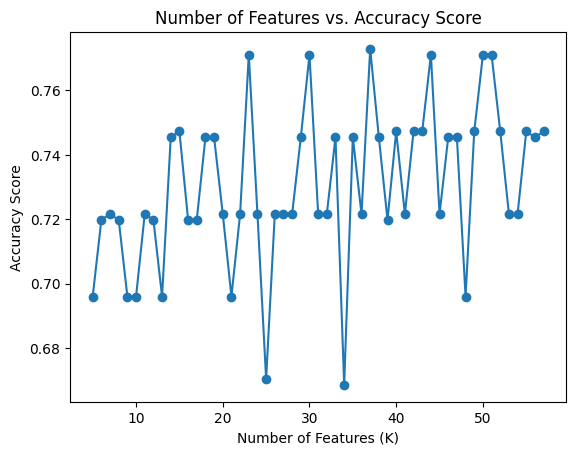

Index(['rank', 'confL', 'num_playoff_appearances', 'total_first_round_won',
       'total_semis_won', 'total_semis_lost', 'total_finals_won', 'mean_won',
       'mean_lost', 'confID_EA', 'GP', 'GS', 'minutes', 'PostGP', 'PostGS',
       'PostMinutes', 'PostDQ', 'award_count_x', 'won', 'post_wins',
       'performance', 'Postperformance', 'points_precision',
       'Postpoints_precision', 'tmID_ATL', 'tmID_CHA', 'tmID_IND', 'tmID_MIA',
       'tmID_MIN', 'tmID_ORL', 'tmID_PHO', 'tmID_POR', 'tmID_SAC', 'tmID_SAS',
       'tmID_SEA', 'tmID_UTA', 'tmID_WAS', 'playoff', 'year', 'confID_WE',
       'tmID_CHI', 'tmID_CLE', 'tmID_CON', 'tmID_DET', 'tmID_HOU', 'tmID_LAS',
       'tmID_NYL'],
      dtype='object')


C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\A

Normal Training
Accuracy: 0.75, Precision: 0.79, Recall: 0.79, F1: 0.79
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\A

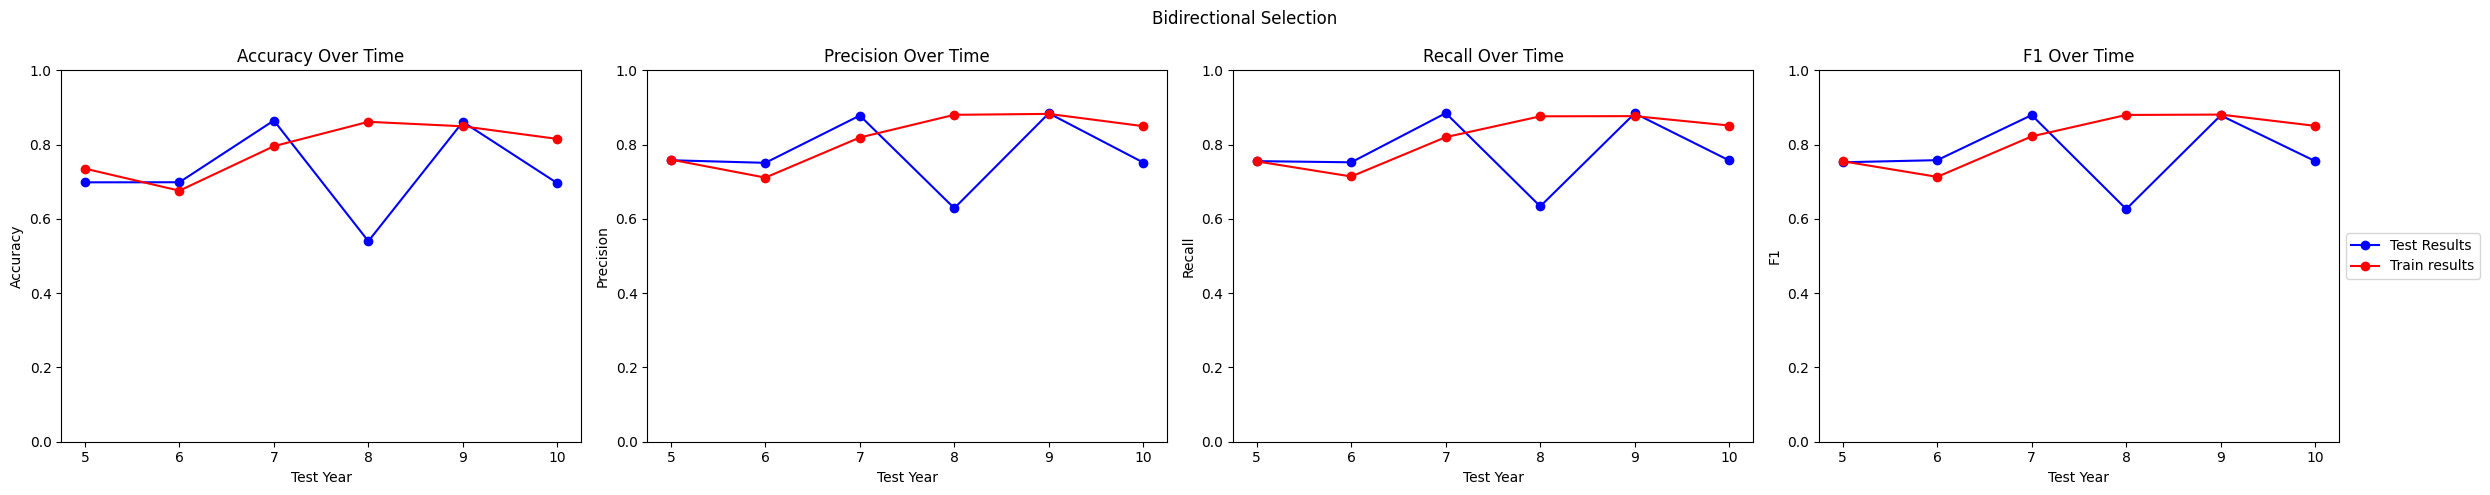

Bidirectional Selection
Accuracy: 0.72, Precision: 0.77, Recall: 0.77, F1: 0.77
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\A

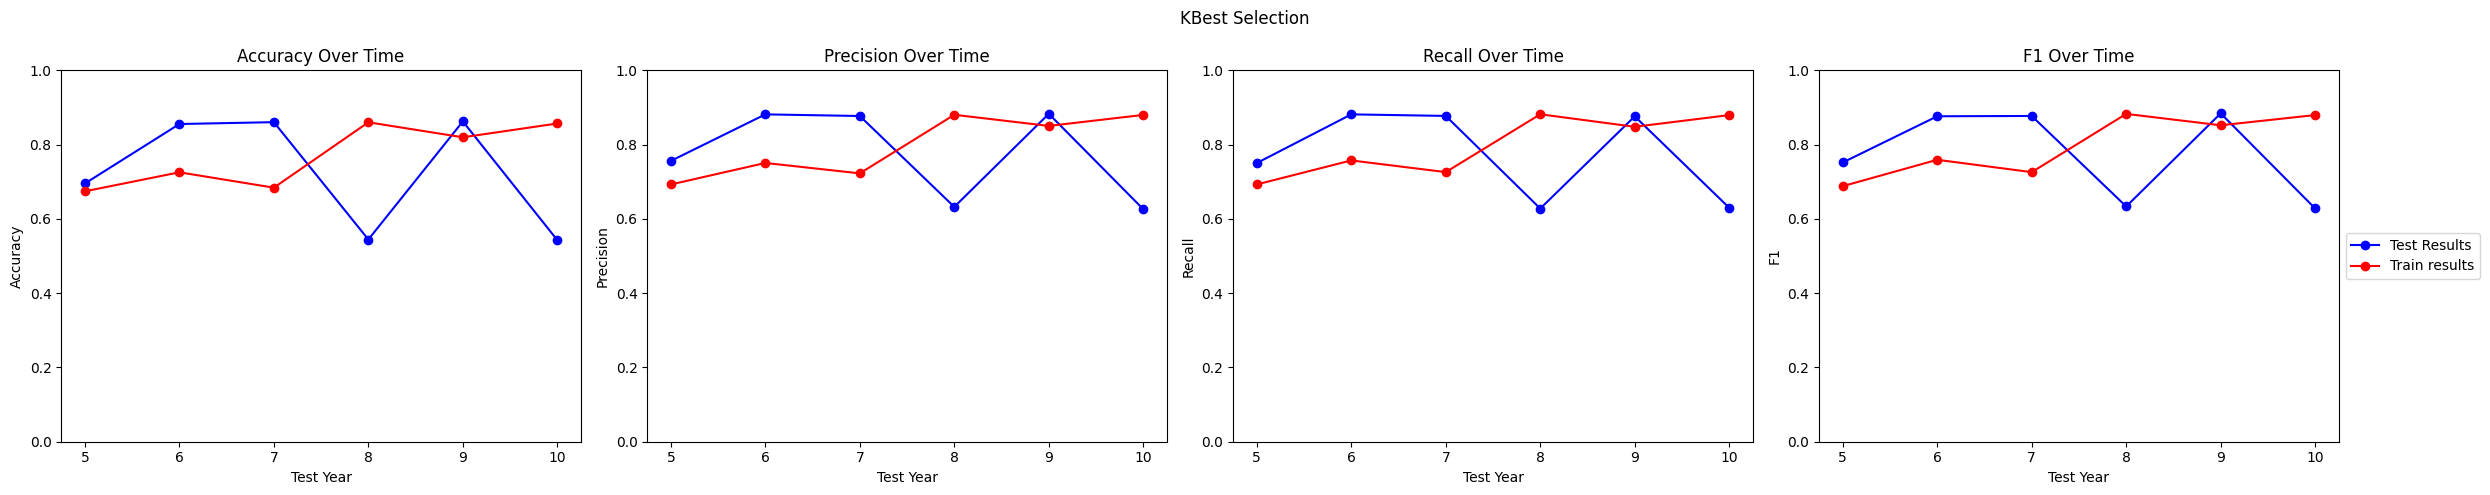

KBest Selection
Accuracy: 0.72, Precision: 0.77, Recall: 0.77, F1: 0.77
10 year
Accuracy: 0.5384615384615384, Precision: 0.625, Recall: 0.625, F1: 0.625


C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\A

1 years back
Accuracy: 0.64, Precision: 0.71, Recall: 0.71, F1: 0.71
10 year
Accuracy: 0.5384615384615384, Precision: 0.625, Recall: 0.625, F1: 0.625


C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\A

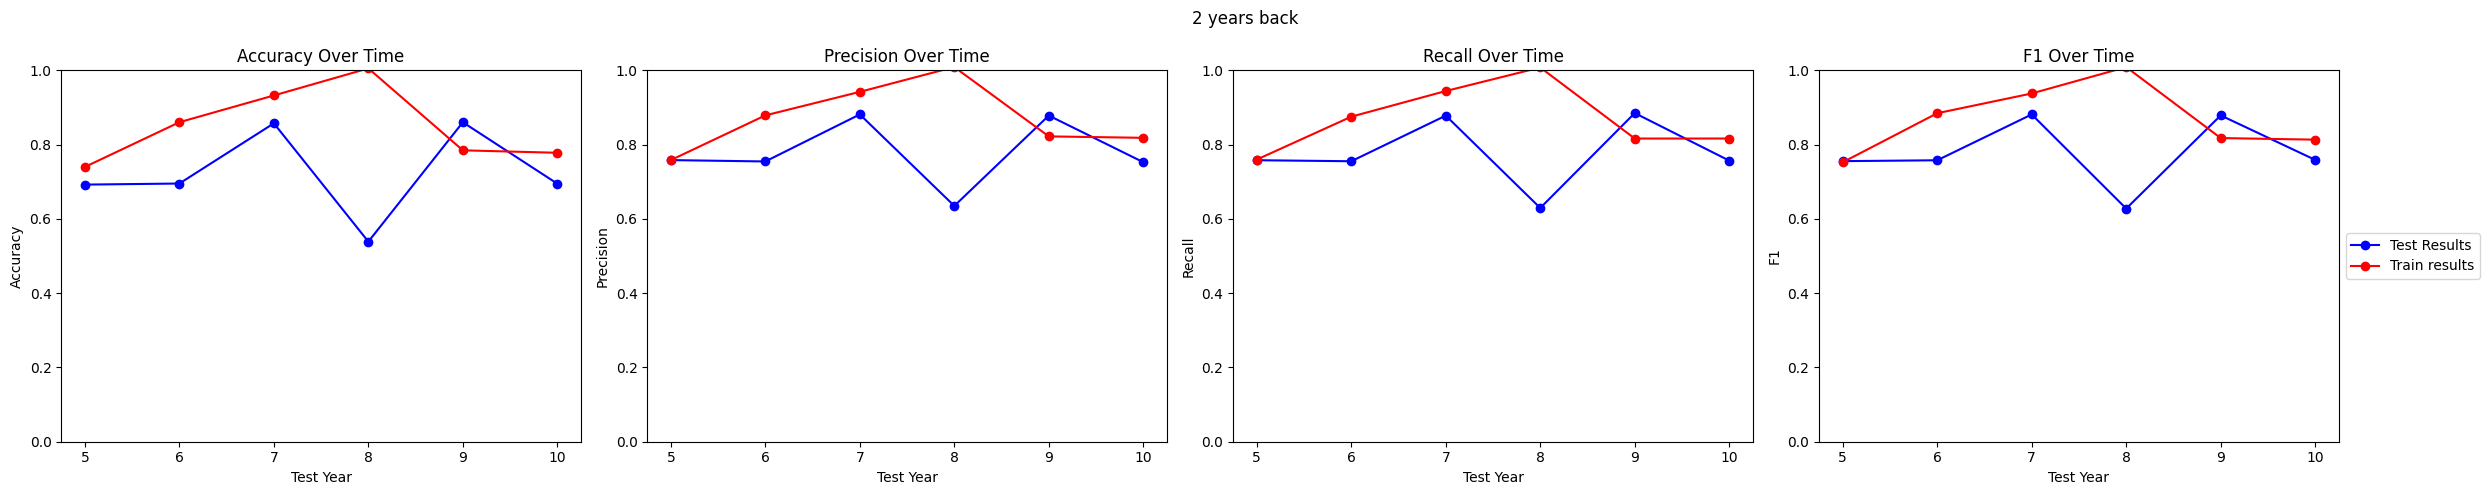

2 years back
Accuracy: 0.72, Precision: 0.77, Recall: 0.77, F1: 0.77
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\A

3 years back
Accuracy: 0.72, Precision: 0.77, Recall: 0.77, F1: 0.77
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\A

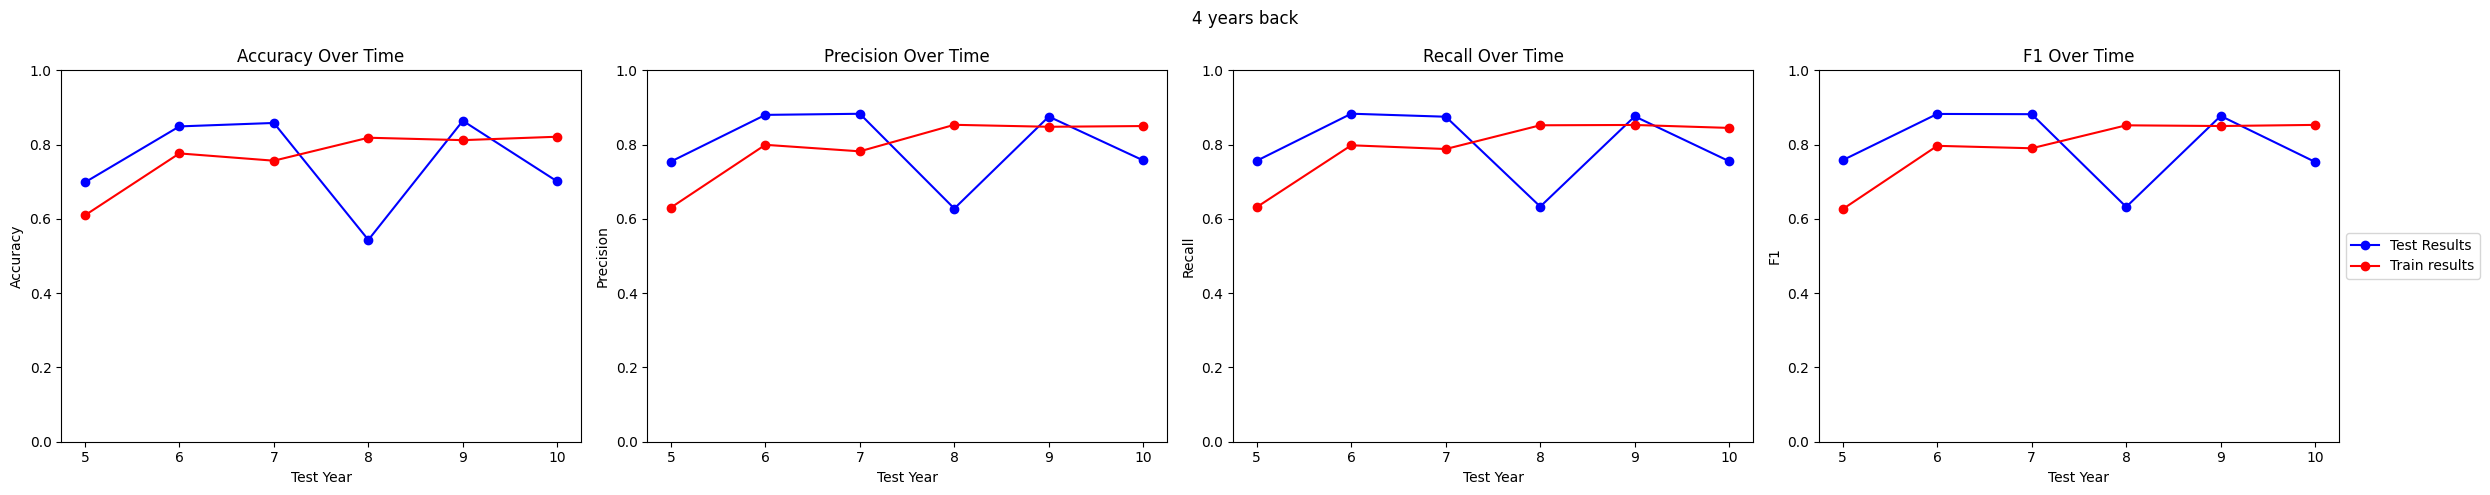

4 years back
Accuracy: 0.75, Precision: 0.79, Recall: 0.79, F1: 0.79
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\A

5 years back
Accuracy: 0.72, Precision: 0.77, Recall: 0.77, F1: 0.77
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\A

6 years back
Accuracy: 0.72, Precision: 0.77, Recall: 0.77, F1: 0.77
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\A

7 years back
Accuracy: 0.77, Precision: 0.81, Recall: 0.81, F1: 0.81
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\A

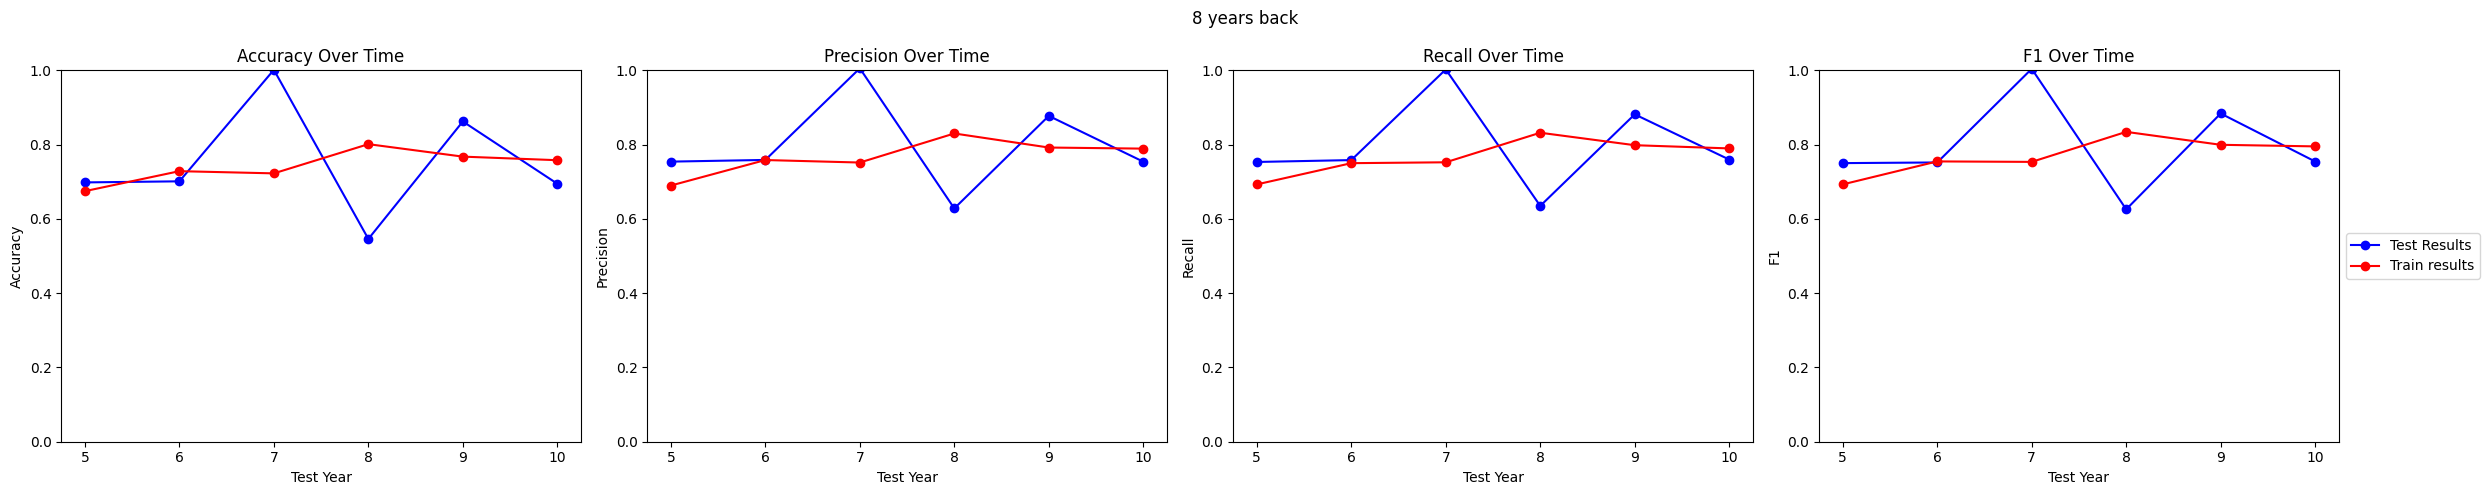

8 years back
Accuracy: 0.75, Precision: 0.79, Recall: 0.79, F1: 0.79
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\A

9 years back
Accuracy: 0.75, Precision: 0.79, Recall: 0.79, F1: 0.79
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


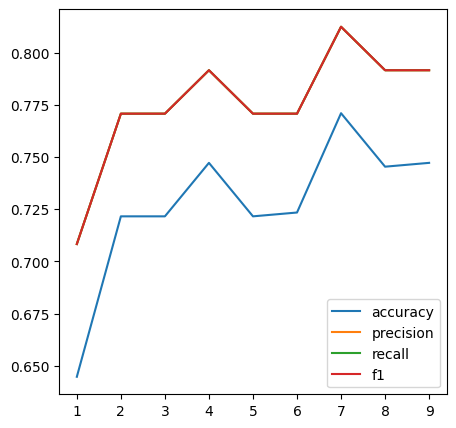

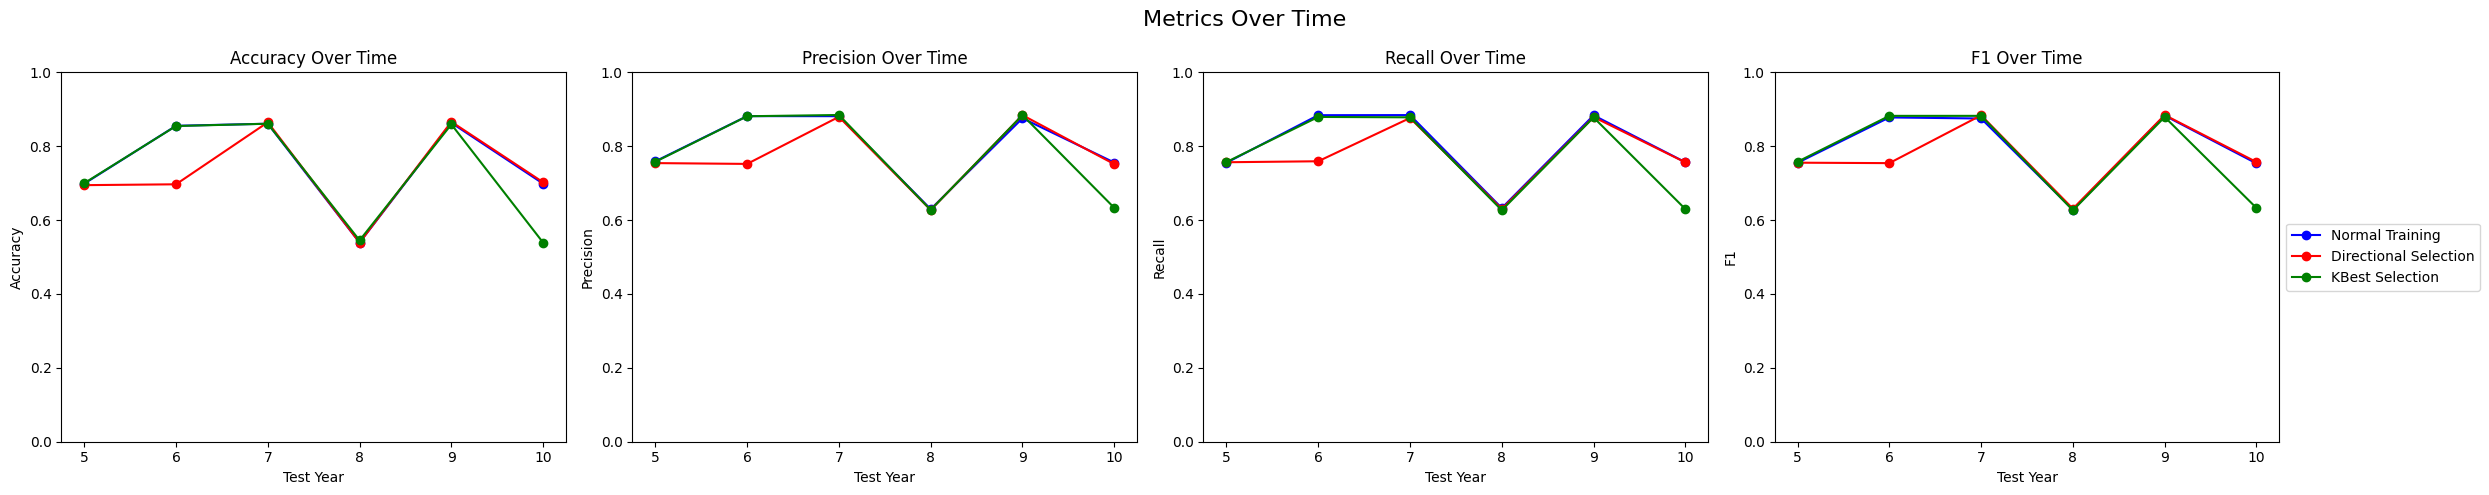

Normal Training
Accuracy: 0.75, Precision: 0.79, Recall: 0.79, F1: 0.79
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75
Directional Selection
Accuracy: 0.72, Precision: 0.77, Recall: 0.77, F1: 0.77
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75
KBest Selection
Accuracy: 0.72, Precision: 0.77, Recall: 0.77, F1: 0.77
10 year
Accuracy: 0.5384615384615384, Precision: 0.625, Recall: 0.625, F1: 0.625


In [33]:
#{'activation': 'identity', 'alpha': 1e-05, 'hidden_layer_sizes': (50, 50), 'max_iter': 100, 'solver': 'sgd'} 0.7985347985347985
model =  MLPClassifier(activation='logistic', alpha=1e-05, hidden_layer_sizes=(20,), max_iter=100, solver='adam')
#{'activation': 'logistic', 'alpha': 1e-05, 'hidden_layer_sizes': (20,), 'max_iter': 100, 'solver': 'adam'} 0.7472527472527473

features = backwards_elimination(df_teams, model, scaling=True)
print(features)
features_kbest = select_k_best(df_teams, model, scaling=True, years_back=4)
print(features_kbest)
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams, scaling=True, title="Normal Training", years_back=4)
years_tested, bidirectional_accuracy_scores, bidirectional_precision_scores, bidirectional_recall_scores, bidirectional_f1_scores = train_evaluate_decision_tree_graph(model, df_teams[features], scaling=True, title="Bidirectional Selection", years_back=4)
years_tested, kbest_accuracy_scores, kbest_precision_scores, kbest_recall_scores, kbest_f1_scores = train_evaluate_decision_tree_graph(model, df_teams[features_kbest], scaling=True, title="KBest Selection", years_back=4)
train_evaluate_decision_tree_years_back(model, df_teams, scaling=True)
plot_metrics_over_time_three(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores, bidirectional_accuracy_scores, bidirectional_precision_scores, bidirectional_recall_scores, bidirectional_f1_scores, kbest_accuracy_scores, kbest_precision_scores, kbest_recall_scores, kbest_f1_scores)


### lightgbm

#### Hyperparameter tuning

In [30]:
# import lightgbm as lgb
# model = lgb.LGBMClassifier()
# param_grid = { 
#     'n_estimators': [50, 100, 200, 300],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'num_leaves': [8, 16, 31, 63],
#     'subsample': [0.6, 0.8, 1.0],
#     'boosting_type' : [ 'dart'], # for better accuracy -> try dart
#     'min_child_samples': [20, 30, 50, 100], # Minimum number of data need in a child(min_data_in_leaf)
# }
# best_param, best_score = custom_grid_search(model, df_teams, param_grid, scaling=True)
# print(best_param, best_score)
# #{'subsample': 0.8, 'num_leaves': 8, 'n_estimators': 300, 'min_child_samples': 20, 'max_depth': -1, 'learning_rate': 0.2, 'boosting_type': 'dart'} 0.695970695970696
# #{'boosting_type': 'dart', 'learning_rate': 0.2, 'min_child_samples': 20, 'n_estimators': 300, 'num_leaves': 8, 'subsample': 0.6} 0.695970695970696


In [31]:
import lightgbm as lgb
#{'boosting_type': 'dart', 'learning_rate': 0.2, 'min_child_samples': 20, 'n_estimators': 300, 'num_leaves': 8, 'subsample': 0.6} 0.695970695970696
model =  lgb.LGBMClassifier(boosting_type='dart', learning_rate=0.2, min_child_samples=20, n_estimators=300, num_leaves=8, subsample=0.6)

features = backwards_elimination(df_teams,model)
print(features)
features_kbest = select_k_best(df_teams, model)
print(features_kbest)
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams, title="Normal Training")
years_tested, bidirectional_accuracy_scores, bidirectional_precision_scores, bidirectional_recall_scores, bidirectional_f1_scores = train_evaluate_decision_tree_graph(model, df_teams[features], title="Bidirectional Selection")
years_tested, kbest_accuracy_scores, kbest_precision_scores, kbest_recall_scores, kbest_f1_scores = train_evaluate_decision_tree_graph(model, df_teams[features_kbest], title="KBest Selection")
train_evaluate_decision_tree_years_back(model, df_teams)
plot_metrics_over_time_three(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores, bidirectional_accuracy_scores, bidirectional_precision_scores, bidirectional_recall_scores, bidirectional_f1_scores, kbest_accuracy_scores, kbest_precision_scores, kbest_recall_scores, kbest_f1_scores)

[LightGBM] [Info] Number of positive: 64, number of negative: 46
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 743
[LightGBM] [Info] Number of data points in the train set: 110, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.581818 -> initscore=0.330242
[LightGBM] [Info] Start training from score 0.330242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li


STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

TypeError: 'NoneType' object is not iterable

### Voting classifier

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb


# First Model
model1 = LogisticRegression(C=0.01, class_weight='balanced', max_iter=200, multi_class='auto', penalty='l2', solver='lbfgs')

# Second Model
model2 = GaussianNB(priors=None, var_smoothing=1e-09)

## Third Model
model3 = KNeighborsClassifier(algorithm='auto', leaf_size=5, metric='minkowski', n_neighbors=10, p=2)
model4 = MLPClassifier(activation='logistic', alpha=1e-05, hidden_layer_sizes=(20,), max_iter=100, solver='adam', early_stopping=True)

['year', 'rank', 'confL', 'attend', 'total_first_round_won', 'total_first_round_lost', 'total_semis_won', 'total_semis_lost', 'total_finals_won', 'total_finals_lost', 'mean_won', 'confID_EA', 'confID_WE', 'GP', 'GS', 'minutes', 'dq', 'PostGP', 'PostGS', 'PostMinutes', 'PostDQ', 'weight', 'post_losses', 'Postperformance', 'tmID_CHA', 'tmID_CHI', 'tmID_CON', 'tmID_DET', 'tmID_MIA', 'tmID_NYL', 'tmID_SEA', 'tmID_UTA', 'playoff', 'tmID_ATL', 'tmID_CLE', 'tmID_HOU', 'tmID_IND', 'tmID_LAS', 'tmID_MIN', 'tmID_ORL', 'tmID_PHO', 'tmID_POR', 'tmID_SAC', 'tmID_SAS', 'tmID_WAS']
hightest_accuracy_score:  0.7728937728937728


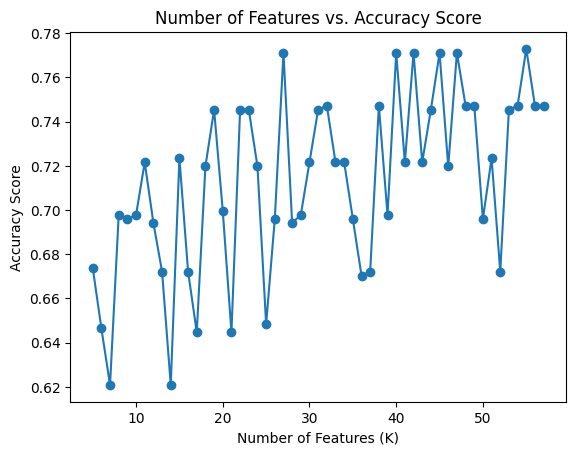

Index(['year', 'rank', 'confW', 'confL', 'num_playoff_appearances',
       'total_first_round_won', 'total_first_round_lost', 'total_semis_won',
       'total_semis_lost', 'total_finals_won', 'total_finals_lost', 'mean_won',
       'mean_lost', 'confID_EA', 'confID_WE', 'GP', 'GS', 'minutes', 'dq',
       'PostGP', 'PostGS', 'PostMinutes', 'PostDQ', 'height', 'weight',
       'award_count_x', 'won', 'lost', 'post_wins', 'post_losses',
       'award_count_y', 'performance', 'Postperformance', 'points_precision',
       'Postpoints_precision', 'tmID_ATL', 'tmID_CHA', 'tmID_CHI', 'tmID_CLE',
       'tmID_CON', 'tmID_DET', 'tmID_HOU', 'tmID_IND', 'tmID_LAS', 'tmID_MIA',
       'tmID_MIN', 'tmID_NYL', 'tmID_ORL', 'tmID_PHO', 'tmID_POR', 'tmID_SAC',
       'tmID_SAS', 'tmID_SEA', 'tmID_UTA', 'tmID_WAS', 'playoff'],
      dtype='object')


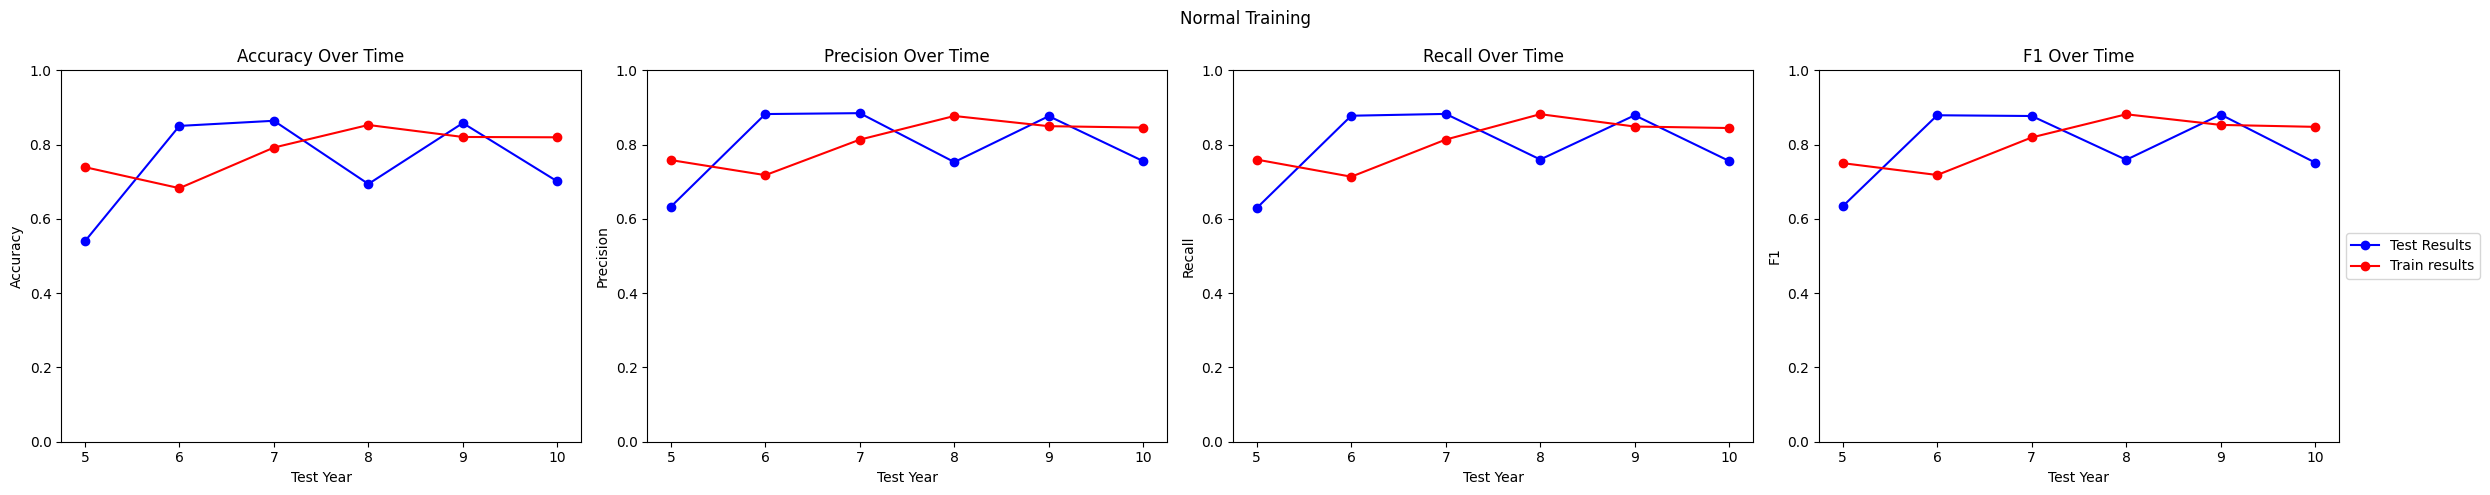

Normal Training
Accuracy: 0.75, Precision: 0.79, Recall: 0.79, F1: 0.79
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


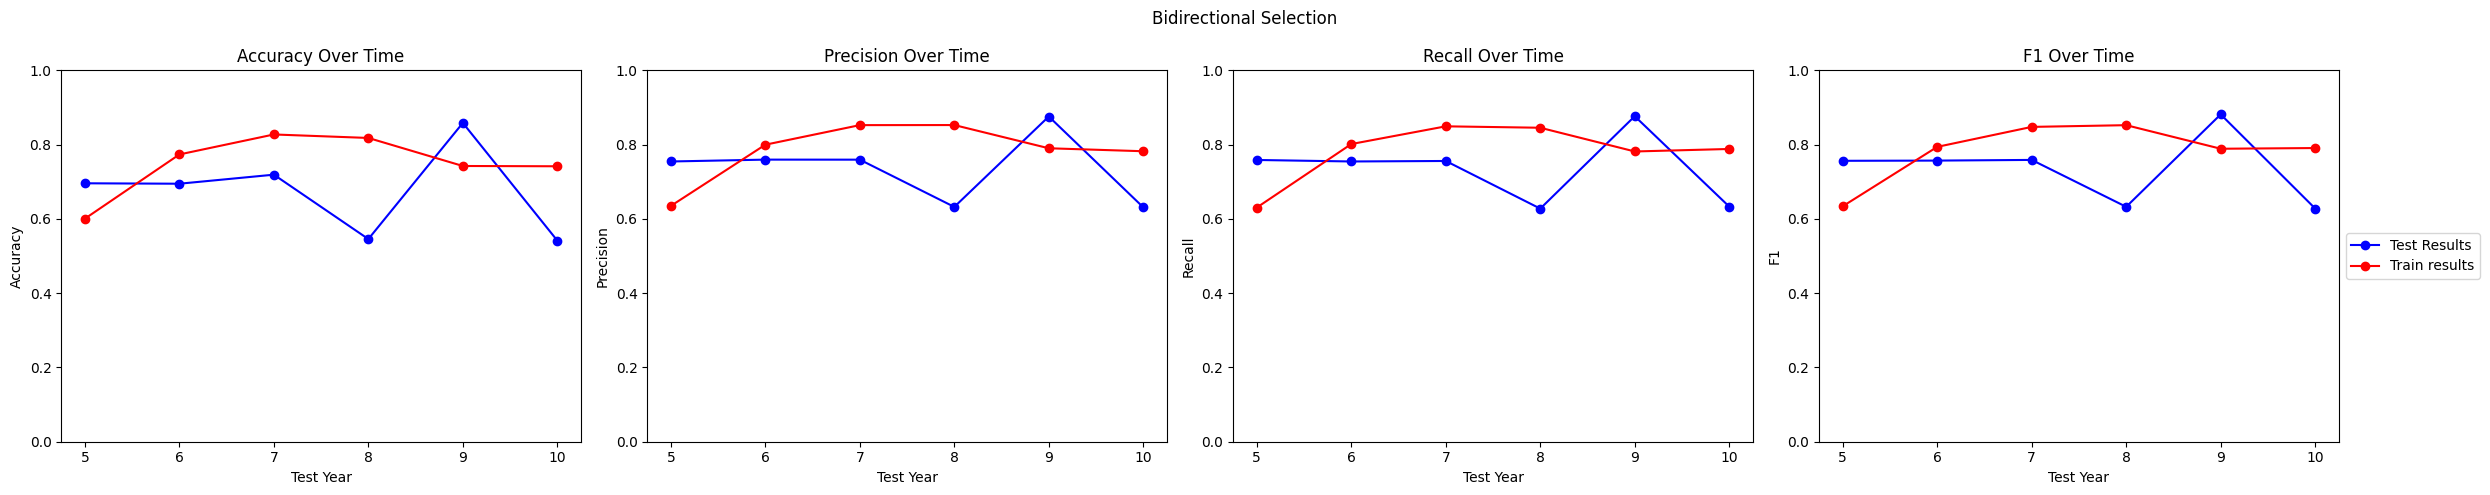

Bidirectional Selection
Accuracy: 0.67, Precision: 0.73, Recall: 0.73, F1: 0.73
10 year
Accuracy: 0.5384615384615384, Precision: 0.625, Recall: 0.625, F1: 0.625


KBest Selection
Accuracy: 0.77, Precision: 0.81, Recall: 0.81, F1: 0.81
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


1 years back
Accuracy: 0.70, Precision: 0.75, Recall: 0.75, F1: 0.75
10 year
Accuracy: 0.5384615384615384, Precision: 0.625, Recall: 0.625, F1: 0.625


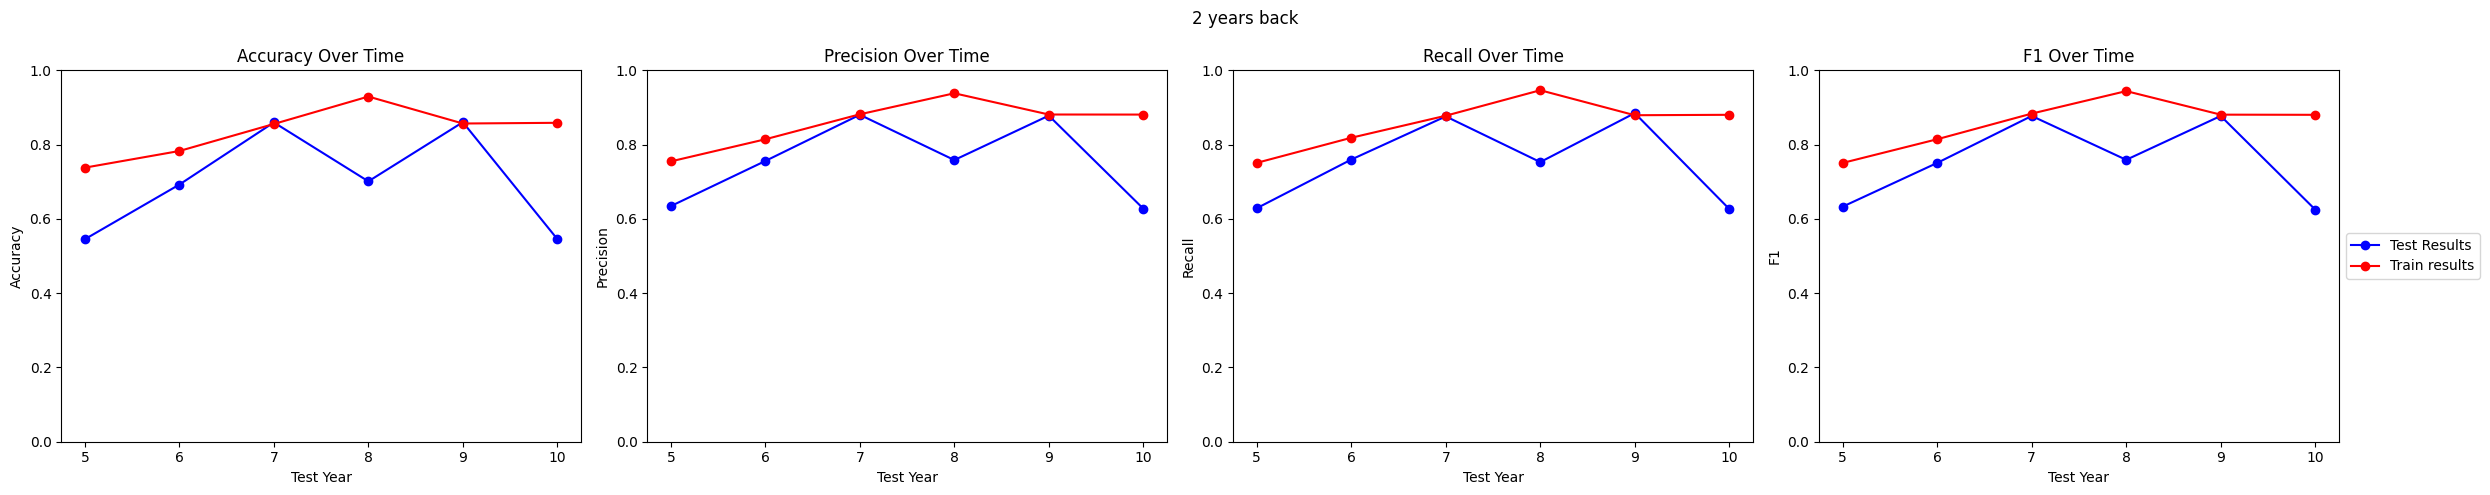

2 years back
Accuracy: 0.70, Precision: 0.75, Recall: 0.75, F1: 0.75
10 year
Accuracy: 0.5384615384615384, Precision: 0.625, Recall: 0.625, F1: 0.625


3 years back
Accuracy: 0.75, Precision: 0.79, Recall: 0.79, F1: 0.79
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


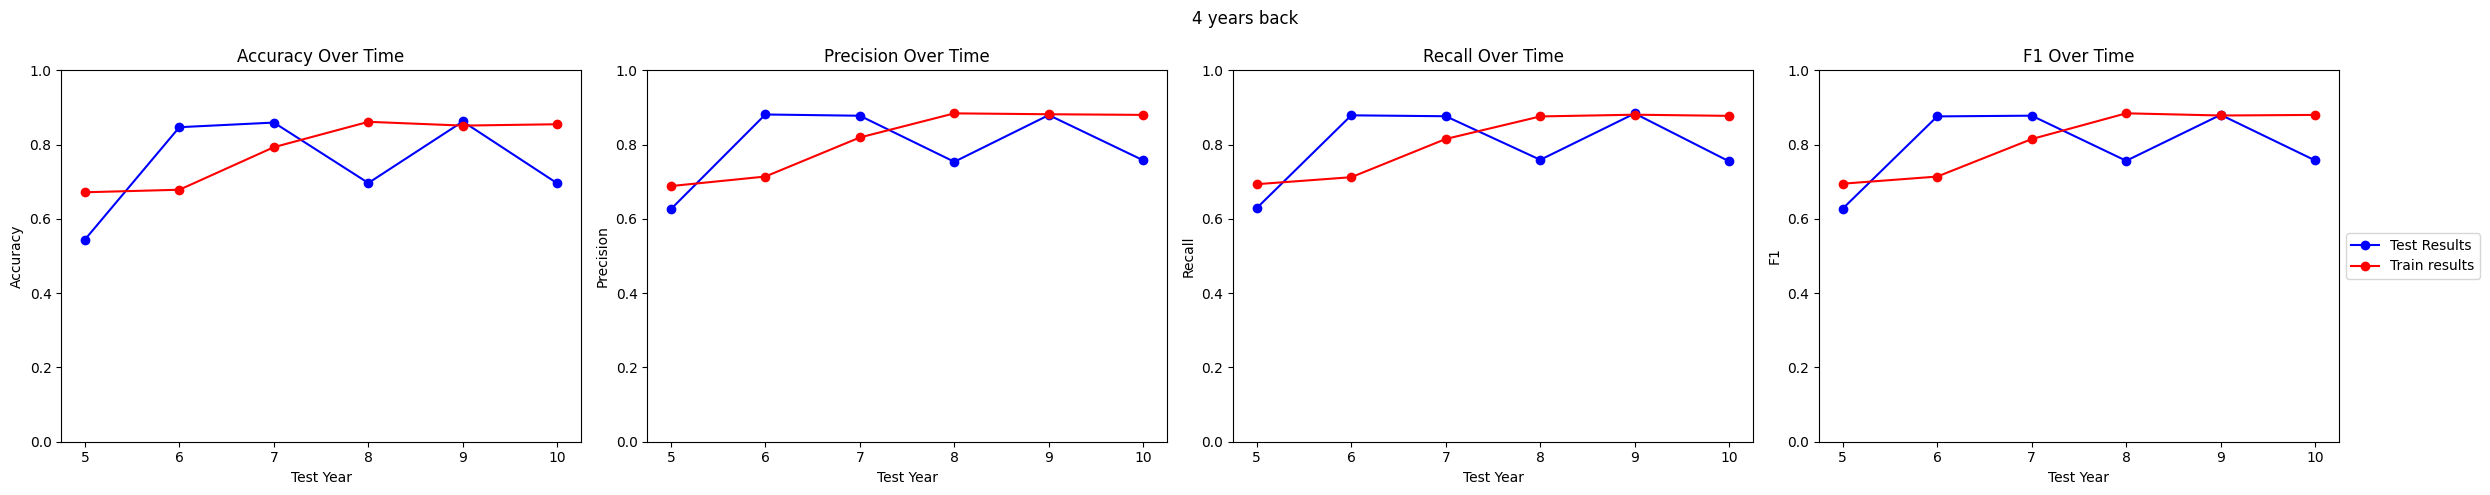

4 years back
Accuracy: 0.75, Precision: 0.79, Recall: 0.79, F1: 0.79
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


5 years back
Accuracy: 0.72, Precision: 0.77, Recall: 0.77, F1: 0.77
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


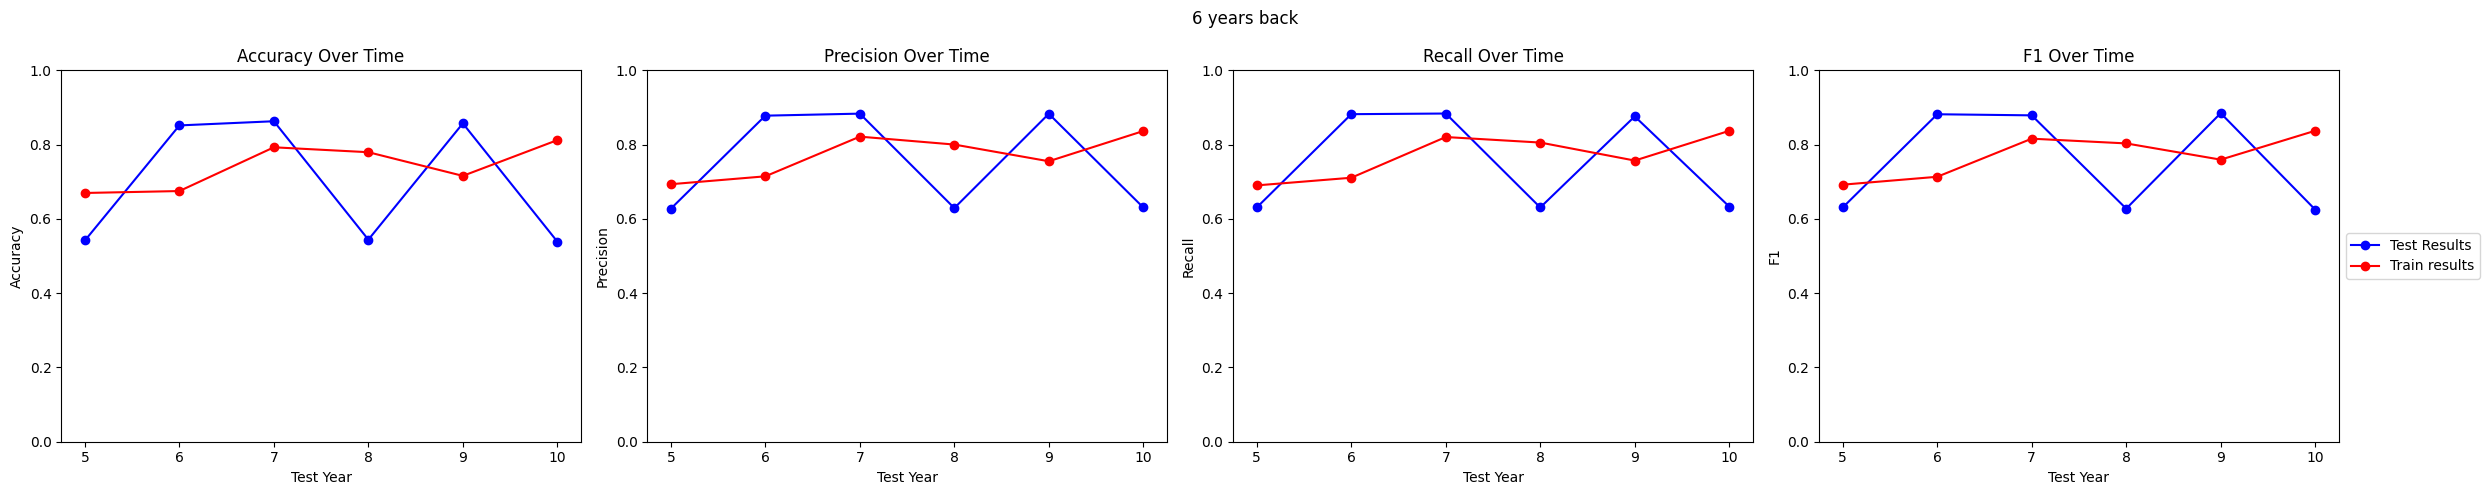

6 years back
Accuracy: 0.70, Precision: 0.75, Recall: 0.75, F1: 0.75
10 year
Accuracy: 0.5384615384615384, Precision: 0.625, Recall: 0.625, F1: 0.625


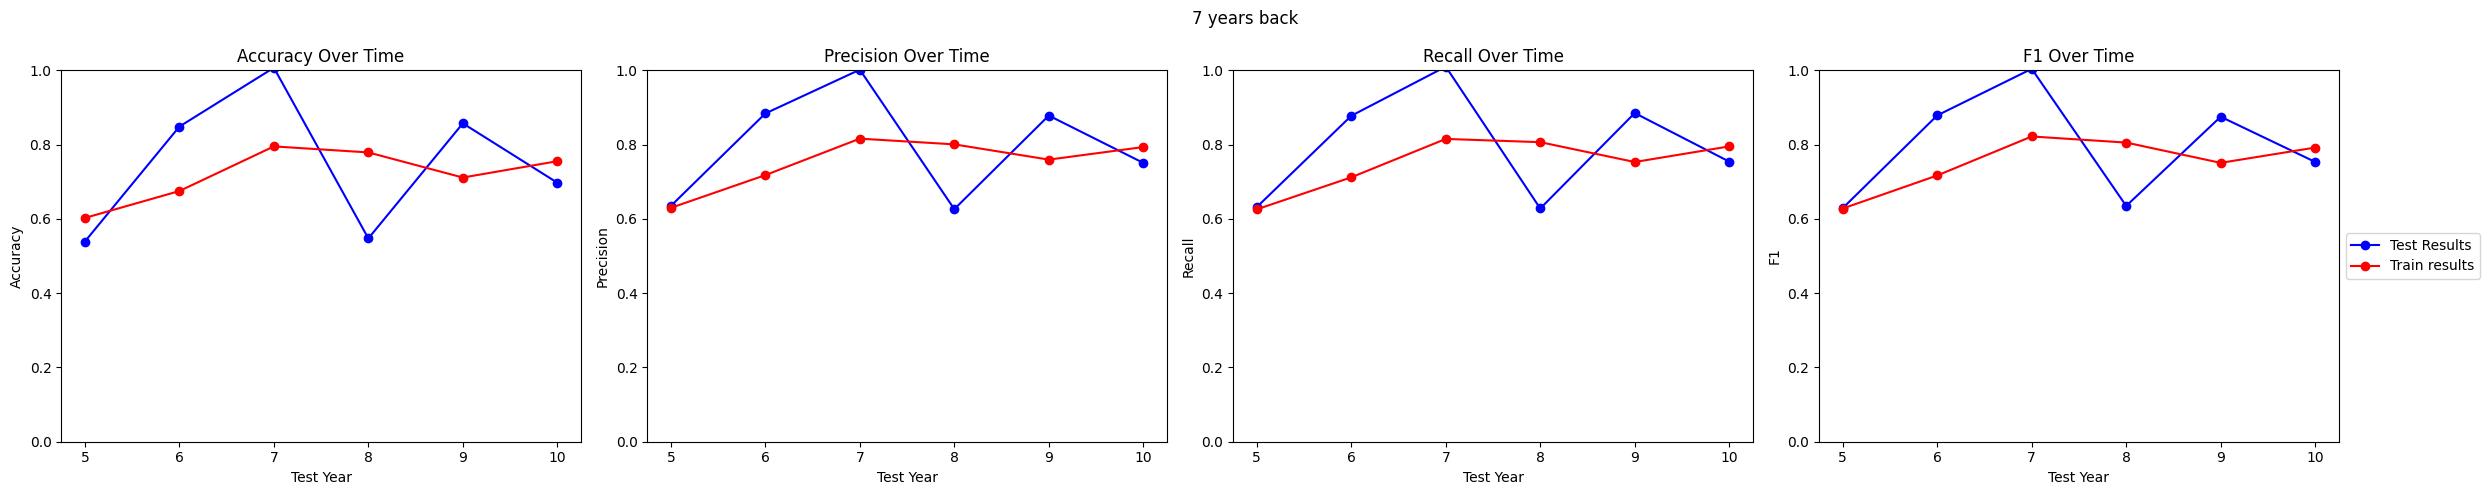

7 years back
Accuracy: 0.75, Precision: 0.79, Recall: 0.79, F1: 0.79
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


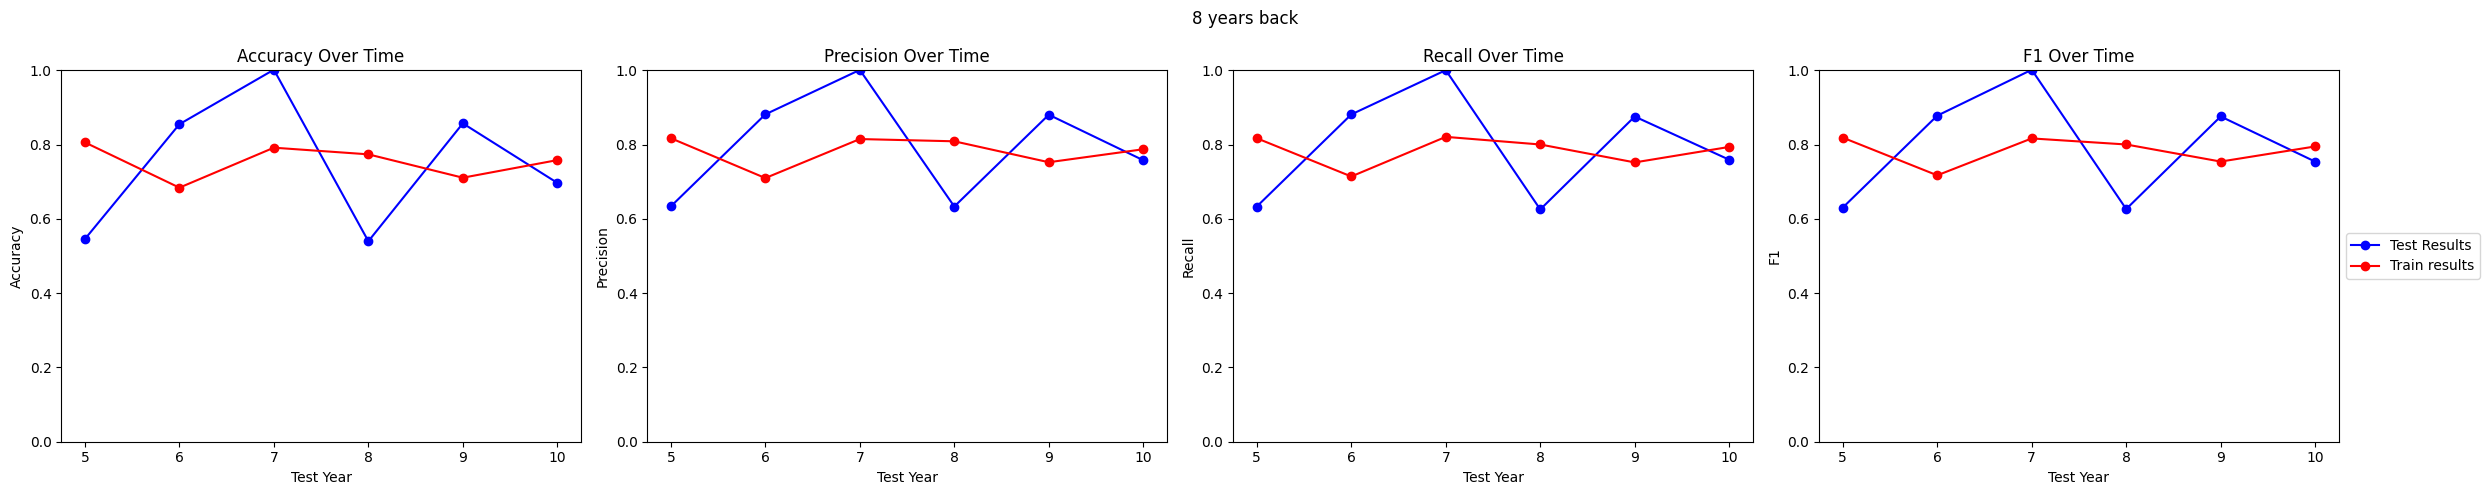

8 years back
Accuracy: 0.75, Precision: 0.79, Recall: 0.79, F1: 0.79
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


9 years back
Accuracy: 0.72, Precision: 0.77, Recall: 0.77, F1: 0.77
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


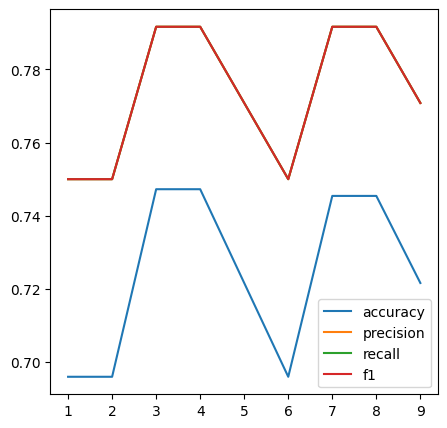

Normal Training
Accuracy: 0.75, Precision: 0.79, Recall: 0.79, F1: 0.79
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75
Directional Selection
Accuracy: 0.67, Precision: 0.73, Recall: 0.73, F1: 0.73
10 year
Accuracy: 0.5384615384615384, Precision: 0.625, Recall: 0.625, F1: 0.625
KBest Selection
Accuracy: 0.77, Precision: 0.81, Recall: 0.81, F1: 0.81
10 year
Accuracy: 0.6923076923076923, Precision: 0.75, Recall: 0.75, F1: 0.75


In [72]:
from sklearn.ensemble import BaggingClassifier, VotingClassifier

# Voting Ensemble
voting_clf = VotingClassifier(estimators=[
    ('model1', model1),
    ('model2', model2),
    ('model3', model3),
    ('model4', model4)
], voting='soft')

# Extract the target variable
target_variable = df_teams["playoff"]

# Fit the ensemble model
voting_clf.fit(df_teams, target_variable)

features = backwards_elimination(df_teams, voting_clf, scaling=True)
print(features)
features_kbest = select_k_best(df_teams, voting_clf, scaling=True, years_back=4)
print(features_kbest)
# Evaluate the ensemble model
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(voting_clf, df_teams, scaling=True, title="Normal Training", years_back=4)
years_tested, bidirectional_accuracy_scores, bidirectional_precision_scores, bidirectional_recall_scores, bidirectional_f1_scores = train_evaluate_decision_tree_graph(voting_clf, df_teams[features], scaling=True, years_back=4, title="Bidirectional Selection")
years_tested, kbest_accuracy_scores, kbest_precision_scores, kbest_recall_scores, kbest_f1_scores = train_evaluate_decision_tree_graph(voting_clf,df_teams[features_kbest], scaling=True, years_back=4, title="KBest Selection")
train_evaluate_decision_tree_years_back(voting_clf, df_teams, scaling=True)
plot_metrics_over_time_three(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores, bidirectional_accuracy_scores, bidirectional_precision_scores, bidirectional_recall_scores, bidirectional_f1_scores, kbest_accuracy_scores, kbest_precision_scores, kbest_recall_scores, kbest_f1_scores)

